# VenueSignal - Yelp Business Rating Prediction
### AAI-540 Group 6

---

## Project Overview

This notebook implements a complete end-to-end MLOps pipeline for predicting Yelp business ratings with a focus on parking availability constraints. The pipeline demonstrates MLOps best practices including:

- **Data Lake Management**: S3-based data storage with proper versioning
- **Data Cataloging**: Athena tables for queryable data access
- **Feature Engineering**: Scalable feature store implementation
- **Model Development**: Baseline and advanced models with proper evaluation
- **Model Deployment**: SageMaker endpoints for inference
- **Monitoring**: Comprehensive model, data, and infrastructure monitoring

**Key Feature**: Uses AWS Account ID for bucket naming to enable each team member to run independently in their own AWS Learning Lab environment.

---

## Table of Contents

1. [Setup & Configuration](#section-1)
2. [Data Lake Setup](#section-2)
3. [Athena Tables & Data Cataloging](#section-3)
4. [Exploratory Data Analysis](#section-4)
5. [Feature Engineering & Feature Store](#section-5)
6. [Model Training](#section-6)
   - 6.1 Benchmark Models
   - 6.2 XGBoost Model
   - 6.3 Model Comparison
7. [Model Deployment](#section-7)
8. [Monitoring & Observability](#section-8)
9. [CI/CD](#section-9)

---

## 1. Setup & Configuration <a id='section-1'></a>

This section:
- Verifies Python version
- Imports all required libraries
- Retrieves AWS Account ID for unique resource naming
- Initializes AWS clients and SageMaker session
- Configures S3 buckets using Account ID pattern

In [1]:
# Verify Python version
!python --version

Python 3.12.9


### 1.1 Import Required Libraries

In [2]:
# Standard libraries
import gdown
import os
import json
import re
import time
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import Counter
from datetime import datetime

# AWS SDK
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from botocore.exceptions import ClientError


# SageMaker
import sagemaker
from sagemaker import get_execution_role
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.model_monitor import DefaultModelMonitor
sm_client = boto3.client('sagemaker')
session = sagemaker.Session()
role = get_execution_role()
region = session.boto_region_name
sagemaker_session=session

# Athena
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor

# Model training and evaluation
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.linear_model import LinearRegression

# Monitoring
from sagemaker.model_monitor import (
    DataCaptureConfig, DefaultModelMonitor, ModelQualityMonitor,
    CronExpressionGenerator, EndpointInput
)
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.s3 import S3Downloader, S3Uploader
from datetime import datetime, timedelta, timezone
from time import sleep
from threading import Thread
import io, csv

# Google Drive download
import gdown

print("All libraries imported successfully")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
All libraries imported successfully


### 1.2 Retrieve AWS Account ID

**IMPORTANT**: This retrieves your unique AWS Account ID which will be used to create unique S3 bucket names.
This allows each team member to run this notebook independently in their own AWS Learning Lab environment.

In [3]:
try:
    # Get AWS Account ID
    account_id = boto3.client("sts").get_caller_identity()["Account"]
    print(f"Successfully retrieved AWS Account ID: {account_id}")
except Exception as e:
    print(f"Cannot retrieve account information: {e}")
    raise



Successfully retrieved AWS Account ID: 562975882808


### 1.3 Initialize AWS Clients and SageMaker Session

In [4]:
# Initialize SageMaker session
sagemaker_session = sagemaker.Session()

# Get Execution role and AWS Region
role = get_execution_role()
print("RoleArn:", role)
REGION = sagemaker_session.boto_region_name
print("Region:", REGION)


# Initialize AWS clients
s3_client = boto3.client("s3", region_name=REGION)
s3_resource = boto3.resource("s3", region_name=REGION)
athena_client = boto3.client("athena", region_name=REGION)
sagemaker_client = boto3.client("sagemaker", region_name=REGION)
cloudwatch_client = boto3.client("cloudwatch", region_name=REGION)
logs_client = boto3.client("logs", region_name=REGION)

print(f"AWS Region: {REGION}")
print(f"SageMaker Execution Role: {role}")
print(f"AWS clients initialized successfully")

# Also create cw_client alias for consistency
cw_client = cloudwatch_client


RoleArn: arn:aws:iam::562975882808:role/LabRole
Region: us-east-1
AWS Region: us-east-1
SageMaker Execution Role: arn:aws:iam::562975882808:role/LabRole
AWS clients initialized successfully


In [5]:
project_name = "yelp-aai540-group6"

### 1.4 Configure S3 Buckets with Account ID Pattern

**IMPORTANT**: All S3 buckets are created with your Account ID to ensure uniqueness.
This pattern is used throughout the entire pipeline.

In [6]:
# Base bucket name with Account ID
BASE_BUCKET_NAME = f"yelp-aai540-group6-{account_id}"

# S3 Prefixes (paths within buckets)
RAW_DATA_PREFIX = "yelp-dataset/json/"
PARQUET_PREFIX = "yelp-dataset/parquet/"
ATHENA_RESULTS_PREFIX = "athena/results/"
FEATURE_PREFIX = "feature-store/"
MODEL_PREFIX = "models/"
MONITORING_PREFIX = "monitoring/"

# Individual directories within the base bucket
DATA_JSON_DIR = f"{BASE_BUCKET_NAME}/{RAW_DATA_PREFIX}"  # Raw data storage
DATA_PARQUET_DIR = f"{BASE_BUCKET_NAME}/{PARQUET_PREFIX}"  # Raw data storage
ATHENA_DIR = f"{BASE_BUCKET_NAME}/{ATHENA_RESULTS_PREFIX}"  # Athena queries and results
FEATURE_DIR = f"{BASE_BUCKET_NAME}/{FEATURE_PREFIX}"  # Feature store offline
MODEL_DIR = f"{BASE_BUCKET_NAME}/{MODEL_PREFIX}"  # Model artifacts
MONITORING_DIR = f"{BASE_BUCKET_NAME}/{MONITORING_PREFIX}"  # Monitoring data

# Full S3 paths
ATHENA_RESULTS_S3 = f"s3://{ATHENA_DIR}"

# Athena Database
ATHENA_DB = "yelp"

# Store configuration
%store REGION
%store role
%store account_id
%store BASE_BUCKET_NAME
%store DATA_JSON_DIR
%store DATA_PARQUET_DIR
%store ATHENA_DIR
%store FEATURE_DIR
%store MODEL_DIR
%store MONITORING_DIR
%store ATHENA_RESULTS_S3
%store ATHENA_DB

# Display configuration
print("="*80)
print("S3 BUCKET CONFIGURATION (Account-Specific)")
print("="*80)
print(f"AWS Account ID:     {account_id}")
print(f"AWS Region:         {REGION}")
print(f"AWS Role:         {role}")
print()
print("S3 Bucket:")
print(f"  Base Bucket:      {BASE_BUCKET_NAME}")
print("S3 Bucket Directories:")
print(f"  JSON:       {DATA_JSON_DIR}")
print(f"  Parquet:    {DATA_PARQUET_DIR}")
print(f"  Athena:     {ATHENA_DIR}")
print(f"  Feature:    {FEATURE_DIR}")
print(f"  Model:      {MODEL_DIR}")
print(f"  Monitoring: {MONITORING_DIR}")
print()
print("Athena Configuration:")
print(f"  Database:         {ATHENA_DB}")
print(f"  Results Location: {ATHENA_RESULTS_S3}")
print("="*80)

Stored 'REGION' (str)
Stored 'role' (str)
Stored 'account_id' (str)
Stored 'BASE_BUCKET_NAME' (str)
Stored 'DATA_JSON_DIR' (str)
Stored 'DATA_PARQUET_DIR' (str)
Stored 'ATHENA_DIR' (str)
Stored 'FEATURE_DIR' (str)
Stored 'MODEL_DIR' (str)
Stored 'MONITORING_DIR' (str)
Stored 'ATHENA_RESULTS_S3' (str)
Stored 'ATHENA_DB' (str)
S3 BUCKET CONFIGURATION (Account-Specific)
AWS Account ID:     562975882808
AWS Region:         us-east-1
AWS Role:         arn:aws:iam::562975882808:role/LabRole

S3 Bucket:
  Base Bucket:      yelp-aai540-group6-562975882808
S3 Bucket Directories:
  JSON:       yelp-aai540-group6-562975882808/yelp-dataset/json/
  Parquet:    yelp-aai540-group6-562975882808/yelp-dataset/parquet/
  Athena:     yelp-aai540-group6-562975882808/athena/results/
  Feature:    yelp-aai540-group6-562975882808/feature-store/
  Model:      yelp-aai540-group6-562975882808/models/
  Monitoring: yelp-aai540-group6-562975882808/monitoring/

Athena Configuration:
  Database:         yelp
  Resul

### 1.5 Create S3 Buckets

This creates all required S3 buckets for the pipeline. Each bucket is unique to your AWS account.

In [7]:
def create_bucket_if_not_exists(bucket_name, region=REGION):
    """
    Create an S3 bucket if it doesn't already exist.

    Args:
        bucket_name: Name of the bucket to create
        region: AWS region for the bucket

    Returns:
        True if bucket was created or already exists, False otherwise
    """
    try:
        # Check if bucket exists
        s3_client.head_bucket(Bucket=bucket_name)
        print(f"  Bucket already exists: {bucket_name}")
        return True
    except ClientError as e:
        error_code = e.response['Error']['Code']
        if error_code == '404':
            # Bucket doesn't exist, create it
            try:
                if region == 'us-east-1':
                    s3_client.create_bucket(Bucket=bucket_name)
                else:
                    s3_client.create_bucket(
                        Bucket=bucket_name,
                        CreateBucketConfiguration={'LocationConstraint': region}
                    )
                print(f"  Created bucket: {bucket_name}")
                return True
            except ClientError as create_error:
                print(f"  Error creating bucket {bucket_name}: {create_error}")
                return False
        else:
            print(f"  Error checking bucket {bucket_name}: {e}")
            return False

# Create all required buckets
print("Creating S3 bucket...")

success = True
if not create_bucket_if_not_exists(BASE_BUCKET_NAME):
    success = False

if success:
    print("\n S3 bucket is ready!")
else:
    print("\n Bucket could not be created. Please check errors above.")

Creating S3 bucket...
  Bucket already exists: yelp-aai540-group6-562975882808

 S3 bucket is ready!


---

## 2. Data Lake Setup <a id='section-2'></a>

This section:
- Downloads Yelp academic dataset from Google Drive
- Uploads raw JSON files to S3 data lake
- Organizes data in a structured format

**Data Source**: Yelp Academic Dataset (5 files, ~8.5 GB total)
- Business data (150k+ businesses)
- Review data (7M+ reviews)
- User data (2M+ users)
- Check-in data
- Tip data

### 2.1 Define Google Drive File IDs

These are the file IDs for the Yelp dataset files stored in Google Drive.

In [8]:
# Google Drive file IDs for Yelp dataset
google_drive_file_ids = {
    "yelp_academic_dataset_business.json": "1-VQQyXape4lCTa_5bA9VTlJgqKkqqR3h",
    "yelp_academic_dataset_checkin.json": "1LcnPYD4m3jp4l7EF8s8mqp3F8QUlcr9-",
    "yelp_academic_dataset_review.json": "1Q_qpG918HVo4UpT1qyGCH4c_MfgQVgWg",
    "yelp_academic_dataset_tip.json": "1vyYognzSAMenVakNyXgchwfZlVc76ZMk",
    "yelp_academic_dataset_user.json": "1wYnBYQspgfh9PnVS3GTyjT8la5PXJni9"
}
#https://drive.google.com/file/d/1Q_qpG918HVo4UpT1qyGCH4c_MfgQVgWg/view?usp=drive_link
#https://drive.google.com/file/d/1wYnBYQspgfh9PnVS3GTyjT8la5PXJni9/view?usp=sharing
#https://drive.google.com/file/d/1M8QVg2aiAwSSQO3zRJYj35PLnMKBa5L9/view?usp=drive_link-copy
#https://drive.google.com/file/d/1kz33s_tiLydRDFRf4GMxxBIvrW_lEpTC/view?usp=drive_link-copy
#https://drive.google.com/file/d/1-VQQyXape4lCTa_5bA9VTlJgqKkqqR3h/view?usp=drive_link
#https://drive.google.com/file/d/1LcnPYD4m3jp4l7EF8s8mqp3F8QUlcr9-/view?usp=drive_link
#https://drive.google.com/file/d/1eQ8nSwENhtwu7X1aNj8XgmHy5KwcMfEU/view?usp=drive_link
#https://drive.google.com/file/d/1vyYognzSAMenVakNyXgchwfZlVc76ZMk/view?usp=drive_link
#https://drive.google.com/file/d/1yLL_31R4J1Me_CEyZCYSsJrcQkzZtxKf/view?usp=drive_link


print(f"Files to download: {len(google_drive_file_ids)}")
for filename in google_drive_file_ids.keys():
    print(f"  - {filename}")

Files to download: 5
  - yelp_academic_dataset_business.json
  - yelp_academic_dataset_checkin.json
  - yelp_academic_dataset_review.json
  - yelp_academic_dataset_tip.json
  - yelp_academic_dataset_user.json


### 2.2 Download and Upload to S3

**Process**:
1. Download each file from Google Drive
2. Upload to your account-specific S3 data bucket
3. Clean up local files to save disk space

**Warning**: This will download ~8.5 GB of data. Ensure you have sufficient disk space and network bandwidth.

In [9]:
file_to_dir = {
    "yelp_academic_dataset_business.json": "business/",
    "yelp_academic_dataset_checkin.json": "checkin/",
    "yelp_academic_dataset_review.json": "review/",
    "yelp_academic_dataset_tip.json": "tip/",
    "yelp_academic_dataset_user.json": "user/",
}

# Change to working directory
work_dir = "/home/sagemaker-user/VenueSignal"
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

print(f"Working directory: {os.getcwd()}")
print(f"Target S3 bucket: {BASE_BUCKET_NAME}")
print(f"Target S3 prefix: {RAW_DATA_PREFIX}")
print()


def process_one_file(filename, file_id, s3_client, RAW_DATA_PREFIX, BASE_BUCKET_NAME):
    # Step 1: Download from Google Drive
    download_url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(download_url, filename, quiet=True)

    # Step 2: Upload to S3
    file_dir = file_to_dir[filename]
    s3_key = f"{RAW_DATA_PREFIX}{file_dir}{filename}"
    s3_client.upload_file(filename, BASE_BUCKET_NAME, s3_key)

    # Step 3: Clean up local file
    if os.path.exists(filename):
        os.remove(filename)

    return filename, s3_key


def download_and_upload_all_concurrently(
    google_drive_file_ids: dict,
    s3_client,
    RAW_DATA_PREFIX: str,
    BASE_BUCKET_NAME: str,
    max_workers: int = 5,
):
    results = {"ok": [], "failed": []}

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(
                process_one_file,
                filename,
                file_id,
                s3_client,
                RAW_DATA_PREFIX,
                BASE_BUCKET_NAME,
            ): filename
            for filename, file_id in google_drive_file_ids.items()
        }

        for fut in as_completed(futures):
            filename = futures[fut]
            try:
                fname, s3_key = fut.result()
                results["ok"].append((fname, s3_key))
                print(f"✓ {fname} -> s3://{BASE_BUCKET_NAME}/{s3_key}")
            except Exception as e:
                results["failed"].append((filename, str(e)))
                print(f"✗ {filename} failed: {e}")

    print("\nDone.")
    print(f"Successful: {len(results['ok'])}")
    print(f"Failed:     {len(results['failed'])}")

    return results


results = download_and_upload_all_concurrently(
    google_drive_file_ids=google_drive_file_ids,
    s3_client=s3_client,
    RAW_DATA_PREFIX=RAW_DATA_PREFIX,
    BASE_BUCKET_NAME=BASE_BUCKET_NAME,
    max_workers=5,
)

print(f"\n{'='*80}")
print(" All files processed successfully!")
print(f"{'='*80}")

Working directory: /home/sagemaker-user/VenueSignal
Target S3 bucket: yelp-aai540-group6-562975882808
Target S3 prefix: yelp-dataset/json/

✓ yelp_academic_dataset_tip.json -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/tip/yelp_academic_dataset_tip.json
✓ yelp_academic_dataset_business.json -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/business/yelp_academic_dataset_business.json
✓ yelp_academic_dataset_tip.json -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/tip/yelp_academic_dataset_tip.json
✓ yelp_academic_dataset_checkin.json -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/checkin/yelp_academic_dataset_checkin.json
✓ yelp_academic_dataset_user.json -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/user/yelp_academic_dataset_user.json
✓ yelp_academic_dataset_review.json -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/review/yelp_academic_dataset_review.json

Done.
Successful: 5
Failed:     0

 All files processed successf

### 2.3 Verify Data Upload

In [10]:
# List files in S3
s3_path = f"s3://{DATA_JSON_DIR}"
print(f"Files in {s3_path}:\n")
!aws s3 ls {s3_path} --recursive --human-readable

# Create clickable link to S3 console
from IPython.display import display, HTML
s3_console_url = f"https://s3.console.aws.amazon.com/s3/buckets/{DATA_JSON_DIR}?region={REGION}&tab=overview"
display(HTML(f'<b>View in S3 Console: <a target="_blank" href="{s3_console_url}">S3 Bucket - Yelp Dataset</a></b>'))

Files in s3://yelp-aai540-group6-562975882808/yelp-dataset/json/:

2026-02-21 04:42:43  113.4 MiB yelp-dataset/json/business/yelp_academic_dataset_business.json
2026-02-21 04:42:44  273.7 MiB yelp-dataset/json/checkin/yelp_academic_dataset_checkin.json
2026-02-21 04:43:52    5.0 GiB yelp-dataset/json/review/yelp_academic_dataset_review.json
2026-02-21 04:42:40  172.2 MiB yelp-dataset/json/tip/yelp_academic_dataset_tip.json
2026-02-21 04:43:01    3.1 GiB yelp-dataset/json/user/yelp_academic_dataset_user.json


---

## 3. Athena Tables & Data Cataloging <a id='section-3'></a>

This section:
- Creates Athena database
- Defines table schemas for JSON data
- Creates queryable tables
- Converts JSON to Parquet for better performance

**Benefits of Athena**:
- Query data in S3 using SQL
- No data movement required
- Pay only for queries run
- Integrates with SageMaker Feature Store

### 3.1 Create Athena Database

In [11]:
def execute_athena_query(query, database=None, output_location=ATHENA_RESULTS_S3):
    """
    Execute an Athena query and wait for completion.

    Args:
        query: SQL query to execute
        database: Athena database name (optional)
        output_location: S3 location for query results

    Returns:
        pandas.DataFrame
    """
    params = {
        "QueryString": query,
        "ResultConfiguration": {"OutputLocation": output_location},
    }
    if database:
        params["QueryExecutionContext"] = {"Database": database}

    # Start query
    qx = athena_client.start_query_execution(**params)
    qid = qx["QueryExecutionId"]

    # Wait for completion
    while True:
        resp = athena_client.get_query_execution(QueryExecutionId=qid)
        state = resp["QueryExecution"]["Status"]["State"]
        if state in ("SUCCEEDED", "FAILED", "CANCELLED"):
            break
        time.sleep(1)

    if state != "SUCCEEDED":
        reason = resp["QueryExecution"]["Status"].get("StateChangeReason", "")
        raise RuntimeError(f"Athena query {state}: {reason}\n\nQuery:\n{query}")

    # Fetch results
    paginator = athena_client.get_paginator("get_query_results")
    columns = None
    data_rows = []

    for page in paginator.paginate(QueryExecutionId=qid):
        result_set = page.get("ResultSet", {})
        metadata = result_set.get("ResultSetMetadata", {})
        col_info = metadata.get("ColumnInfo", [])

        # Resolve headers from metadata once
        if columns is None and col_info:
            columns = [c.get("Name") for c in col_info]

        for row in result_set.get("Rows", []):
            values = [c.get("VarCharValue") for c in row.get("Data", [])]

            # If Athena included a header-like first row equal to column names, skip it.
            if columns and values == columns:
                continue

            # Normalize row length to match columns
            if columns:
                if len(values) < len(columns):
                    values += [None] * (len(columns) - len(values))
                elif len(values) > len(columns):
                    values = values[:len(columns)]

            data_rows.append(values)

    # No result rows (common for DDL/DML)
    if not data_rows and not columns:
        return pd.DataFrame()

    # If we have columns but no data, still return empty df with correct headers
    if columns and not data_rows:
        return pd.DataFrame(columns=columns)

    # If columns are missing for some reason, generate generic names
    if not columns:
        max_len = max((len(r) for r in data_rows), default=0)
        columns = [f"col_{i}" for i in range(max_len)]
        data_rows = [r + [None] * (max_len - len(r)) for r in data_rows]

    return pd.DataFrame(data_rows, columns=columns)


# Create Athena database
print(f"Creating Athena database: {ATHENA_DB}")
create_db_query = f"CREATE DATABASE IF NOT EXISTS {ATHENA_DB}"
try:
    execute_athena_query(create_db_query)
    print(f" Database '{ATHENA_DB}' created successfully")
except Exception as e:
    print(f" Error creating database: {e}")

Creating Athena database: yelp
 Database 'yelp' created successfully


### 3.2 Define File Locations

Map table names to their S3 file locations.

In [12]:
# Define JSON files
FILES = {
    'business': 'yelp_academic_dataset_business.json',
    'review': 'yelp_academic_dataset_review.json',
    'user': 'yelp_academic_dataset_user.json',
    'checkin': 'yelp_academic_dataset_checkin.json',
    'tip': 'yelp_academic_dataset_tip.json'
}

# Create S3 object keys
OBJECT_KEYS = {
    table: f"{RAW_DATA_PREFIX}{table}/{fname}" for table, fname in FILES.items()
}

print("File mappings:")
for table, key in OBJECT_KEYS.items():
    print(f"  {table:10} -> s3://{BASE_BUCKET_NAME}/{key}")

File mappings:
  business   -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/business/yelp_academic_dataset_business.json
  review     -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/review/yelp_academic_dataset_review.json
  user       -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/user/yelp_academic_dataset_user.json
  checkin    -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/checkin/yelp_academic_dataset_checkin.json
  tip        -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/tip/yelp_academic_dataset_tip.json


### 3.3 Verify File Access

In [13]:
dest_locations = {}

print("Verifying S3 file access...\n")
for table, key in OBJECT_KEYS.items():
    try:
        s3_client.head_object(Bucket=BASE_BUCKET_NAME, Key=key)
        print(f" {table:10} {key}")
        dest_locations[table] = f"s3://{DATA_JSON_DIR}{table}/"
    except ClientError:
        print(f" {table:10} {key} NOT FOUND")

print()
print("JSON file directory destinations...\n")
for t, loc in dest_locations.items():
    print(f"{t:8} -> {loc}")

Verifying S3 file access...

 business   yelp-dataset/json/business/yelp_academic_dataset_business.json
 review     yelp-dataset/json/review/yelp_academic_dataset_review.json
 user       yelp-dataset/json/user/yelp_academic_dataset_user.json
 checkin    yelp-dataset/json/checkin/yelp_academic_dataset_checkin.json
 tip        yelp-dataset/json/tip/yelp_academic_dataset_tip.json

JSON file directory destinations...

business -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/business/
review   -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/review/
user     -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/user/
checkin  -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/checkin/
tip      -> s3://yelp-aai540-group6-562975882808/yelp-dataset/json/tip/


### 3.4 Create Athena Tables from JSON

Create external tables in Athena that point to the JSON files in S3.

If you experience any errors while running the table creation cells, uncomment the bellow cell and run it.

In [14]:

TABLES = ["business", "review", "user", "checkin", "tip", "business_attributes"]

for table in TABLES:
    print(f"Dropping table: {ATHENA_DB}.{table}")
    execute_athena_query(
        f"DROP TABLE IF EXISTS {ATHENA_DB}.{table};",
        database=ATHENA_DB
    )

paginator = s3_client.get_paginator("list_objects_v2")
to_delete = []
for page in paginator.paginate(Bucket=BASE_BUCKET_NAME, Prefix=ATHENA_RESULTS_PREFIX):
    for obj in page.get("Contents", []):
        to_delete.append({"Key": obj["Key"]})

if not to_delete:
    print("✅ Nothing to delete under", f"s3://{BASE_BUCKET_NAME}/{ATHENA_RESULTS_PREFIX}")
else:
    # delete in batches of 1000 (S3 limit)
    for i in range(0, len(to_delete), 1000):
        s3_client.delete_objects(
            Bucket=BASE_BUCKET_NAME,
            Delete={"Objects": to_delete[i:i+1000]}
        )
    print(f"✅ Deleted {len(to_delete)} objects under s3://{BASE_BUCKET_NAME}/{ATHENA_RESULTS_PREFIX}")

print("✅ All tables dropped.")

Dropping table: yelp.business
Dropping table: yelp.review
Dropping table: yelp.user
Dropping table: yelp.checkin
Dropping table: yelp.tip
Dropping table: yelp.business_attributes
✅ Deleted 8 objects under s3://yelp-aai540-group6-562975882808/athena/results/
✅ All tables dropped.


In [15]:
# TABLES = ["business", "review", "user", "checkin", "tip", "business_attributes"]

# for table in TABLES:
#     print(f"Dropping table: {ATHENA_DB}.{table}")
#     execute_athena_query(
#         f"DROP TABLE IF EXISTS {ATHENA_DB}.{table};",
#         database=ATHENA_DB
#     )

# paginator = s3_client.get_paginator("list_objects_v2")
# to_delete = []
# for page in paginator.paginate(Bucket=BASE_BUCKET_NAME, Prefix=ATHENA_RESULTS_PREFIX):
#     for obj in page.get("Contents", []):
#         to_delete.append({"Key": obj["Key"]})

# if not to_delete:
#     print("✅ Nothing to delete under", f"s3://{BASE_BUCKET_NAME}/{ATHENA_RESULTS_PREFIX}")
# else:
#     # delete in batches of 1000 (S3 limit)
#     for i in range(0, len(to_delete), 1000):
#         s3_client.delete_objects(
#             Bucket=BASE_BUCKET_NAME,
#             Delete={"Objects": to_delete[i:i+1000]}
#         )
#     print(f"✅ Deleted {len(to_delete)} objects under s3://{BASE_BUCKET_NAME}/{ATHENA_RESULTS_PREFIX}")

# print("✅ All tables dropped.")

In [16]:
business_location = dest_locations["business"]

# parquet_prefix
business_parquet_location = f"s3://{DATA_PARQUET_DIR}business"

print("Creating temporary table")
execute_athena_query(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {ATHENA_DB}.business_temp (
  business_id string,
  name string,
  address string,
  city string,
  state string,
  postal_code string,
  latitude double,
  longitude double,
  stars double,
  review_count int,
  is_open int,
  attributes map<string,string>,
  categories string,
  hours map<string,string>
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES ('ignore.malformed.json'='true')
LOCATION '{business_location}'
TBLPROPERTIES ('has_encrypted_data'='false');
""", database=ATHENA_DB)

print("Creating table with parquets")
execute_athena_query(f"""
CREATE TABLE {ATHENA_DB}.business
WITH (
  format = 'PARQUET',
  external_location = '{business_parquet_location}'
) AS
SELECT
  business_id,
  name,
  address,
  city,
  state,
  postal_code,
  latitude,
  longitude,
  stars,
  review_count,
  is_open,
  attributes,
  categories,
  hours

FROM {ATHENA_DB}.business_temp;
""", database=ATHENA_DB)

print("drop temp table")
execute_athena_query(f"DROP TABLE IF EXISTS {ATHENA_DB}.business_temp;", database=ATHENA_DB)

print(f"✅ Created table {ATHENA_DB}.business")

Creating temporary table
Creating table with parquets
drop temp table
✅ Created table yelp.business


In [17]:
review_location = dest_locations["review"]
# parquet_prefix
review_parquet_location = f"s3://{DATA_PARQUET_DIR}review"

print("Creating temporary table")
execute_athena_query(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {ATHENA_DB}.review_temp (
  review_id string,
  user_id string,
  business_id string,
  stars double,
  useful int,
  funny int,
  cool int,
  text string,
  date string
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES ('ignore.malformed.json'='true')
LOCATION '{review_location}'
TBLPROPERTIES ('has_encrypted_data'='false');
""", database=ATHENA_DB)

print("Creating table with parquets")
execute_athena_query(f"""
CREATE TABLE {ATHENA_DB}.review
WITH (
  format = 'PARQUET',
  external_location = '{review_parquet_location}',
  partitioned_by = ARRAY['year']
) AS
SELECT
  review_id,
  user_id,
  business_id,
  stars,
  useful,
  funny,
  cool,
  text,
  date,
  CAST(substr(date, 1, 4) AS integer) AS year

FROM {ATHENA_DB}.review_temp
WHERE date IS NOT NULL;
""", database=ATHENA_DB)

print("drop temp table")
execute_athena_query(f"DROP TABLE IF EXISTS {ATHENA_DB}.review_temp;", database=ATHENA_DB)

print(f"✅ Created table {ATHENA_DB}.review")

Creating temporary table
Creating table with parquets
drop temp table
✅ Created table yelp.review


In [18]:
user_location = dest_locations["user"]

# parquet_prefix
user_parquet_location = f"s3://{DATA_PARQUET_DIR}user"

print("Create temp table")
execute_athena_query(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {ATHENA_DB}.user_temp (
  user_id string,
  name string,
  review_count int,
  yelping_since string,
  friends array<string>,
  useful int,
  funny int,
  cool int,
  fans int,
  elite array<string>,
  average_stars double,
  compliment_hot int,
  compliment_more int,
  compliment_profile int,
  compliment_cute int,
  compliment_list int,
  compliment_note int,
  compliment_plain int,
  compliment_cool int,
  compliment_funny int,
  compliment_writer int,
  compliment_photos int
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES ('ignore.malformed.json'='true')
LOCATION '{user_location}'
TBLPROPERTIES ('has_encrypted_data'='false');
""", database=ATHENA_DB)

print("Create Parquet table")
execute_athena_query(f"""
CREATE TABLE {ATHENA_DB}.user
WITH (
  format = 'PARQUET',
  external_location = '{user_parquet_location}'
) AS
SELECT
  user_id,
  name,
  review_count,
  yelping_since,
  friends,
  useful,
  funny,
  cool,
  fans,
  elite,
  average_stars,
  compliment_hot,
  compliment_more,
  compliment_profile,
  compliment_cute,
  compliment_list,
  compliment_note,
  compliment_plain,
  compliment_cool,
  compliment_funny,
  compliment_writer,
  compliment_photos
FROM {ATHENA_DB}.user_temp;
""", database=ATHENA_DB)

print("Drop temp table")
execute_athena_query(f"DROP TABLE IF EXISTS {ATHENA_DB}.user_temp;", database=ATHENA_DB)

print(f"✅ Created table {ATHENA_DB}.user")

Create temp table
Create Parquet table
Drop temp table
✅ Created table yelp.user


In [19]:
checkin_location = dest_locations["checkin"]

# parquet_prefix
checkin_parquet_location = f"s3://{DATA_PARQUET_DIR}checkin"

print("Create temp table")
execute_athena_query(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {ATHENA_DB}.checkin_temp (
  business_id string,
  date string
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES ('ignore.malformed.json'='true')
LOCATION '{checkin_location}'
TBLPROPERTIES ('has_encrypted_data'='false');
""", database=ATHENA_DB)

print("Create Parquet table")
execute_athena_query(f"""
CREATE TABLE {ATHENA_DB}.checkin
WITH (
  format = 'PARQUET',
  external_location = '{checkin_parquet_location}'
) AS
SELECT
  business_id,
  date
FROM {ATHENA_DB}.checkin_temp;
""", database=ATHENA_DB)

print("Drop temp table")
execute_athena_query(f"DROP TABLE IF EXISTS {ATHENA_DB}.checkin_temp;", database=ATHENA_DB)


print(f"✅ Created table {ATHENA_DB}.checkin")

Create temp table
Create Parquet table
Drop temp table
✅ Created table yelp.checkin


In [20]:
tip_location = dest_locations["tip"]

# parquet_prefix
tip_parquet_location = f"s3://{DATA_PARQUET_DIR}tip"

print("Create temp table")
execute_athena_query(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {ATHENA_DB}.tip_temp (
  user_id string,
  business_id string,
  text string,
  date string,
  compliment_count int
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES ('ignore.malformed.json'='true')
LOCATION '{tip_location}'
TBLPROPERTIES ('has_encrypted_data'='false');
""", database=ATHENA_DB)

print("Create Parquet table")
execute_athena_query(f"""
CREATE TABLE {ATHENA_DB}.tip
WITH (
  format = 'PARQUET',
  external_location = '{tip_parquet_location}',
  partitioned_by = ARRAY['year']
) AS
SELECT
  user_id,
  business_id,
  text,
  date,
  compliment_count,
  CAST(substr(date, 1, 4) AS integer) AS year

FROM {ATHENA_DB}.tip_temp
WHERE date IS NOT NULL;
""", database=ATHENA_DB)

print("Drop temp table")
execute_athena_query(f"DROP TABLE IF EXISTS {ATHENA_DB}.tip_temp;", database=ATHENA_DB)

print(f"✅ Created table {ATHENA_DB}.tip")

Create temp table
Create Parquet table
Drop temp table
✅ Created table yelp.tip


In [21]:
business_attributes_location = f"s3://{DATA_PARQUET_DIR}business_attributes"

execute_athena_query(f"""
CREATE TABLE {ATHENA_DB}.business_attributes
WITH (
  format = 'PARQUET',
  external_location = '{business_attributes_location}'
) AS
WITH normalized AS (
  SELECT
    business_id,
    hours,

    -- Normalize u'...' and '...' wrappers on keys + values
    map_from_entries(
      transform(
        map_entries(attributes),
        e -> CAST(
          ROW(
            regexp_replace(CAST(e[1] AS varchar), '^u?''(.*)''$', '$1'),
            regexp_replace(CAST(e[2] AS varchar), '^u?''(.*)''$', '$1')
          ) AS ROW(varchar, varchar)
        )
      )
    ) AS attrs
  FROM {ATHENA_DB}.business
  WHERE attributes IS NOT NULL
),
parsed AS (
  SELECT
    business_id,
    hours,
    -- Convert literal "None" (any case) to NULL for all attribute lookups via helper expression pattern below
    attrs,

    -- Parse BusinessParking
    TRY(
      CAST(
        json_parse(
          replace(
            replace(
              replace(
                replace(
                  regexp_replace(attrs['businessparking'], 'u''(.*?)''', '"$1"'),
                  '''', '"'
                ),
                'False', 'false'
              ),
              'True', 'true'
            ),
            'None', 'null'
          )
        ) AS map(varchar, boolean)
      )
    ) AS parking_map,

    -- Parse Ambience
    TRY(
      CAST(
        json_parse(
          replace(
            replace(
              replace(
                replace(
                  -- normalize u'...' keys inside the string
                  regexp_replace(attrs['ambience'], 'u''(.*?)''', '"$1"'),
                  '''', '"'
                ),
                'False', 'false'
              ),
              'True', 'true'
            ),
            'None', 'null'
          )
        ) AS map(varchar, boolean)
      )
    ) AS ambience_map,

    -- Parse GoodForMeal
    TRY(
      CAST(
        json_parse(
          replace(
            replace(
              replace(
                replace(
                  -- normalize u'...' keys
                  regexp_replace(attrs['goodformeal'], 'u''(.*?)''', '"$1"'),
                  '''', '"'
                ),
                'False', 'false'
              ),
              'True', 'true'
            ),
            'None', 'null'
          )
        ) AS map(varchar, boolean)
      )
    ) AS goodformeal_map,

    -- Parse BestNights
    TRY(
      CAST(
        json_parse(
          replace(
            replace(
              replace(
                replace(
                  -- normalize u'...' keys
                  regexp_replace(attrs['bestnights'], 'u''(.*?)''', '"$1"'),
                  '''', '"'
                ),
                'False', 'false'
              ),
              'True', 'true'
            ),
            'None', 'null'
          )
        ) AS map(varchar, boolean)
      )
    ) AS bestnights_map,

    -- Parse HairSpecializesIn
    TRY(
      CAST(
        json_parse(
          replace(
            replace(
              replace(
                replace(
                  -- normalize u'...' keys
                  regexp_replace(attrs['hairspecializesin'], 'u''(.*?)''', '"$1"'),
                  '''', '"'
                ),
                'False', 'false'
              ),
              'True', 'true'
            ),
            'None', 'null'
          )
        ) AS map(varchar, boolean)
      )
    ) AS hairspecializesin_map,

    -- Parse DietaryRestrictions
    TRY(
      CAST(
        json_parse(
          replace(
            replace(
              replace(
                replace(
                  -- normalize u'...' keys
                  regexp_replace(attrs['dietaryrestrictions'], 'u''(.*?)''', '"$1"'),
                  '''', '"'
                ),
                'False', 'false'
              ),
              'True', 'true'
            ),
            'None', 'null'
          )
        ) AS map(varchar, boolean)
      )
    ) AS dietaryrestrictions_map
  FROM normalized
)
SELECT
    business_id,

    -- Helper pattern: NULLIF(lower(x),'none') but preserving original case when not none
    CASE WHEN attrs['acceptsinsurance'] IS NULL OR lower(attrs['acceptsinsurance']) = 'none' THEN NULL ELSE attrs['acceptsinsurance'] END AS acceptsinsurance,
    CASE WHEN attrs['agesallowed'] IS NULL OR lower(attrs['agesallowed']) = 'none' THEN NULL ELSE attrs['agesallowed'] END AS agesallowed,
    CASE WHEN attrs['alcohol'] IS NULL OR lower(attrs['alcohol']) = 'none' THEN NULL ELSE attrs['alcohol'] END AS alcohol,
    CASE WHEN attrs['bikeparking'] IS NULL OR lower(attrs['bikeparking']) = 'none' THEN NULL ELSE attrs['bikeparking'] END AS bikeparking,
    CASE WHEN attrs['businessacceptsbitcoin'] IS NULL OR lower(attrs['businessacceptsbitcoin']) = 'none' THEN NULL ELSE attrs['businessacceptsbitcoin'] END AS businessacceptsbitcoin,
    CASE WHEN attrs['businessacceptscreditcards'] IS NULL OR lower(attrs['businessacceptscreditcards']) = 'none' THEN NULL ELSE attrs['businessacceptscreditcards'] END AS businessacceptscreditcards,
    CASE WHEN attrs['byappointmentonly'] IS NULL OR lower(attrs['byappointmentonly']) = 'none' THEN NULL ELSE attrs['byappointmentonly'] END AS byappointmentonly,
    CASE WHEN attrs['byob'] IS NULL OR lower(attrs['byob']) = 'none' THEN NULL ELSE attrs['byob'] END AS byob,
    CASE WHEN attrs['byobcorkage'] IS NULL OR lower(attrs['byobcorkage']) = 'none' THEN NULL ELSE attrs['byobcorkage'] END AS byobcorkage,
    CASE WHEN attrs['caters'] IS NULL OR lower(attrs['caters']) = 'none' THEN NULL ELSE attrs['caters'] END AS caters,
    CASE WHEN attrs['coatcheck'] IS NULL OR lower(attrs['coatcheck']) = 'none' THEN NULL ELSE attrs['coatcheck'] END AS coatcheck,
    CASE WHEN attrs['corkage'] IS NULL OR lower(attrs['corkage']) = 'none' THEN NULL ELSE attrs['corkage'] END AS corkage,
    CASE WHEN attrs['dogsallowed'] IS NULL OR lower(attrs['dogsallowed']) = 'none' THEN NULL ELSE attrs['dogsallowed'] END AS dogsallowed,
    CASE WHEN attrs['drivethru'] IS NULL OR lower(attrs['drivethru']) = 'none' THEN NULL ELSE attrs['drivethru'] END AS drivethru,
    CASE WHEN attrs['goodfordancing'] IS NULL OR lower(attrs['goodfordancing']) = 'none' THEN NULL ELSE attrs['goodfordancing'] END AS goodfordancing,
    CASE WHEN attrs['goodforkids'] IS NULL OR lower(attrs['goodforkids']) = 'none' THEN NULL ELSE attrs['goodforkids'] END AS goodforkids,
    CASE WHEN attrs['happyhour'] IS NULL OR lower(attrs['happyhour']) = 'none' THEN NULL ELSE attrs['happyhour'] END AS happyhour,
    CASE WHEN attrs['hastv'] IS NULL OR lower(attrs['hastv']) = 'none' THEN NULL ELSE attrs['hastv'] END AS hastv,
    CASE WHEN attrs['music'] IS NULL OR lower(attrs['music']) = 'none' THEN NULL ELSE attrs['music'] END AS music,
    CASE WHEN attrs['noiselevel'] IS NULL OR lower(attrs['noiselevel']) = 'none' THEN NULL ELSE attrs['noiselevel'] END AS noiselevel,
    CASE WHEN attrs['open24hours'] IS NULL OR lower(attrs['open24hours']) = 'none' THEN NULL ELSE attrs['open24hours'] END AS open24hours,
    CASE WHEN attrs['outdoorseating'] IS NULL OR lower(attrs['outdoorseating']) = 'none' THEN NULL ELSE attrs['outdoorseating'] END AS outdoorseating,
    CASE WHEN attrs['restaurantsattire'] IS NULL OR lower(attrs['restaurantsattire']) = 'none' THEN NULL ELSE attrs['restaurantsattire'] END AS restaurantsattire,
    CASE WHEN attrs['restaurantscounterservice'] IS NULL OR lower(attrs['restaurantscounterservice']) = 'none' THEN NULL ELSE attrs['restaurantscounterservice'] END AS restaurantscounterservice,
    CASE WHEN attrs['restaurantsdelivery'] IS NULL OR lower(attrs['restaurantsdelivery']) = 'none' THEN NULL ELSE attrs['restaurantsdelivery'] END AS restaurantsdelivery,
    CASE WHEN attrs['restaurantsgoodforgroups'] IS NULL OR lower(attrs['restaurantsgoodforgroups']) = 'none' THEN NULL ELSE attrs['restaurantsgoodforgroups'] END AS restaurantsgoodforgroups,
    CASE WHEN attrs['restaurantspricerange2'] IS NULL OR lower(attrs['restaurantspricerange2']) = 'none' THEN NULL ELSE attrs['restaurantspricerange2'] END AS restaurantspricerange2,
    CASE WHEN attrs['restaurantsreservations'] IS NULL OR lower(attrs['restaurantsreservations']) = 'none' THEN NULL ELSE attrs['restaurantsreservations'] END AS restaurantsreservations,
    CASE WHEN attrs['restaurantstableservice'] IS NULL OR lower(attrs['restaurantstableservice']) = 'none' THEN NULL ELSE attrs['restaurantstableservice'] END AS restaurantstableservice,
    CASE WHEN attrs['restaurantstakeout'] IS NULL OR lower(attrs['restaurantstakeout']) = 'none' THEN NULL ELSE attrs['restaurantstakeout'] END AS restaurantstakeout,
    CASE WHEN attrs['smoking'] IS NULL OR lower(attrs['smoking']) = 'none' THEN NULL ELSE attrs['smoking'] END AS smoking,
    CASE WHEN attrs['wheelchairaccessible'] IS NULL OR lower(attrs['wheelchairaccessible']) = 'none' THEN NULL ELSE attrs['wheelchairaccessible'] END AS wheelchairaccessible,
    CASE WHEN attrs['wifi'] IS NULL OR lower(attrs['wifi']) = 'none' THEN NULL ELSE attrs['wifi'] END AS wifi,

    -- Parking
    parking_map['garage']    AS parking_garage,
    parking_map['street']    AS parking_street,
    parking_map['validated'] AS parking_validated,
    parking_map['lot']       AS parking_lot,
    parking_map['valet']     AS parking_valet,

    -- Ambience
    ambience_map['divey']     AS ambience_divey,
    ambience_map['hipster']  AS ambience_hipster,
    ambience_map['casual']   AS ambience_casual,
    ambience_map['touristy'] AS ambience_touristy,
    ambience_map['trendy']   AS ambience_trendy,
    ambience_map['intimate'] AS ambience_intimate,
    ambience_map['romantic'] AS ambience_romantic,
    ambience_map['classy']   AS ambience_classy,
    ambience_map['upscale']  AS ambience_upscale,

    -- GoodForMeal
    goodformeal_map['dessert']    AS good_for_dessert,
    goodformeal_map['latenight'] AS good_for_latenight,
    goodformeal_map['lunch']     AS good_for_lunch,
    goodformeal_map['dinner']    AS good_for_dinner,
    goodformeal_map['brunch']    AS good_for_brunch,
    goodformeal_map['breakfast'] AS good_for_breakfast,

    -- BestNights
    bestnights_map['monday']    AS bestnight_monday,
    bestnights_map['tuesday']   AS bestnight_tuesday,
    bestnights_map['wednesday'] AS bestnight_wednesday,
    bestnights_map['thursday']  AS bestnight_thursday,
    bestnights_map['friday']    AS bestnight_friday,
    bestnights_map['saturday']  AS bestnight_saturday,
    bestnights_map['sunday']    AS bestnight_sunday,

    -- HairSpecializesIn
    hairspecializesin_map['africanamerican'] AS hair_africanamerican,
    hairspecializesin_map['asian']           AS hair_asian,
    hairspecializesin_map['coloring']        AS hair_coloring,
    hairspecializesin_map['curly']           AS hair_curly,
    hairspecializesin_map['extensions']      AS hair_extensions,
    hairspecializesin_map['kids']            AS hair_kids,
    hairspecializesin_map['perms']           AS hair_perms,
    hairspecializesin_map['straightperms']   AS hair_straightperms,

    -- DietaryRestrictions
    dietaryrestrictions_map['dairy-free']      AS dairy_free,
    dietaryrestrictions_map['gluten-free']    AS gluten_free,
    dietaryrestrictions_map['vegan']           AS vegan,
    dietaryrestrictions_map['kosher']          AS kosher,
    dietaryrestrictions_map['halal']           AS halal,
    dietaryrestrictions_map['soy-free']        AS soy_free,
    dietaryrestrictions_map['vegetarian']      AS vegetarian,

    -- Hours
    hours['monday']    AS hours_monday,
    hours['tuesday']   AS hours_tuesday,
    hours['wednesday'] AS hours_wednesday,
    hours['thursday']  AS hours_thursday,
    hours['friday']    AS hours_friday,
    hours['saturday']  AS hours_saturday,
    hours['sunday']    AS hours_sunday,

    CARDINALITY(map_keys(hours)) AS open_days_count,
    CASE WHEN hours['saturday'] IS NOT NULL OR hours['sunday'] IS NOT NULL THEN true ELSE false END AS open_on_weekend

FROM parsed;
""", database=ATHENA_DB)

print(f"✅ Built {ATHENA_DB}.business_attributes")
print("📍 Location:", business_attributes_location)

✅ Built yelp.business_attributes
📍 Location: s3://yelp-aai540-group6-562975882808/yelp-dataset/parquet/business_attributes


### 3.5 Connect to Athena with PyAthena

Create a connection to query the tables using pandas.

In [10]:
# Create PyAthena connection
conn = connect(
    s3_staging_dir=ATHENA_RESULTS_S3,
    region_name=REGION,
    cursor_class=PandasCursor
)

print(f" Connected to Athena database: {ATHENA_DB}")
print(f"   Results location: {ATHENA_RESULTS_S3}")

 Connected to Athena database: yelp
   Results location: s3://yelp-aai540-group6-562975882808/athena/results/


### 3.6 Test Athena Tables

Run sample queries to verify table creation.

In [11]:
# Query business table
query = f"""
SELECT
    COUNT(*) as total_businesses,
    COUNT(DISTINCT city) as unique_cities,
    COUNT(DISTINCT state) as unique_states
FROM {ATHENA_DB}.business
LIMIT 10
"""

print("Testing business table...")
df = pd.read_sql(query, conn)
display(df)



# Query review table
query = f"""
SELECT
    COUNT(*) as total_reviews,
    AVG(stars) as avg_stars,
    MIN(stars) as min_stars,
    MAX(stars) as max_stars
FROM {ATHENA_DB}.review
LIMIT 10
"""

print("\nTesting review table...")
df = pd.read_sql(query, conn)
display(df)

print("\n Athena tables are working correctly!")

Testing business table...


,total_businesses,unique_cities,unique_states
0,150346,1416,27



Testing review table...


,total_reviews,avg_stars,min_stars,max_stars
0,6990280,3.748584,1.0,5.0



 Athena tables are working correctly!


---

## 4. Exploratory Data Analysis <a id='section-4'></a>

This section explores the Yelp dataset to understand:
- Business distribution across cities and states
- Review patterns and rating distributions
- Parking availability and its relationship to ratings
- Data quality issues

**Focus**: Understanding how parking constraints affect business ratings

### 4.1 Load Sample Data

In [12]:
# Load a sample of businesses with parking information
query = f"""
SELECT
    business_id,
    name,
    city,
    state,
    stars,
    review_count,
    categories
FROM {ATHENA_DB}.business
WHERE is_open = 1
    AND review_count >= 10
"""

print("Loading sample business data...")
business_df = pd.read_sql(query, conn)
print(f" Loaded {len(business_df):,} businesses")

# Show sample data
print("\nSample data:")
display(business_df.head())

# Show basic statistics
print(f"\n Data Summary:")
print(f"   Total businesses: {len(business_df):,}")
print(f"   Unique cities: {business_df['city'].nunique():,}")
print(f"   Unique states: {business_df['state'].nunique()}")
print(f"   Average rating: {business_df['stars'].mean():.2f}")
print(f"   Average reviews: {business_df['review_count'].mean():.0f}")

print("\n Note: Parking features will be extracted from review text in Section 5")
print("   This provides more accurate parking information than business attributes!")


Loading sample business data...
 Loaded 78,988 businesses

Sample data:


,business_id,name,city,state,stars,review_count,categories
0,I42Ebt8haptL_Wew3r9wLA,Greek House,Tucson,AZ,4.0,217,"Fast Food, Mediterranean, Greek, Food, Falafel..."
1,0v6zwCwYDJgXQVd8wfuRFA,Onsite Neonatal Partners,Voorhees,NJ,1.5,12,"Medical Centers, Doctors, Health & Medical"
2,fLcLyuu7VSAsZ_8pFHdU-g,Woodshed Burgers,Edmonton,AB,3.5,60,"Beer, Wine & Spirits, Food, Ice Cream & Frozen..."
3,sifjKct6u09nBdiJFFlR3A,Webster Family Physicians,Webster Groves,MO,3.5,17,"Doctors, Health & Medical"
4,t81dPFSGJz1ZuaLoP0vp9w,Johnlucas Pizza Pasta And Grill,Levittown,PA,3.5,27,"Caterers, Restaurants, Pizza, Event Planning &..."



 Data Summary:
   Total businesses: 78,988
   Unique cities: 1,061
   Unique states: 21
   Average rating: 3.61
   Average reviews: 67

 Note: Parking features will be extracted from review text in Section 5
   This provides more accurate parking information than business attributes!


### 4.2 Analyze Parking Features

In [13]:
print("\n" + "="*80)
print("BUSINESS DISTRIBUTION ANALYSIS")
print("="*80)

# Top cities
print("\n  Top 10 Cities:")
top_cities = business_df['city'].value_counts().head(10)
for idx, (city, count) in enumerate(top_cities.items(), 1):
    print(f"   {idx:2d}. {city:20s} - {count:,} businesses")

# Top states
print("\n  Top 10 States:")
top_states = business_df['state'].value_counts().head(10)
for idx, (state, count) in enumerate(top_states.items(), 1):
    print(f"   {idx:2d}. {state:5s} - {count:,} businesses")

# Rating distribution
print("\n Rating Distribution:")
rating_dist = business_df['stars'].value_counts().sort_index()
for stars, count in rating_dist.items():
    bar_length = int(count / rating_dist.max() * 40)
    bar = "█" * bar_length
    print(f"   {stars:.1f} stars: {bar} ({count:,})")

# Review count statistics
print("\n Review Count Statistics:")
review_stats = business_df['review_count'].describe()
print(f"   Min:     {review_stats['min']:,.0f}")
print(f"   25th:    {review_stats['25%']:,.0f}")
print(f"   Median:  {review_stats['50%']:,.0f}")
print(f"   75th:    {review_stats['75%']:,.0f}")
print(f"   Max:     {review_stats['max']:,.0f}")
print(f"   Mean:    {review_stats['mean']:,.0f}")



BUSINESS DISTRIBUTION ANALYSIS

  Top 10 Cities:
    1. Philadelphia         - 7,509 businesses
    2. Tucson               - 5,046 businesses
    3. Tampa                - 4,842 businesses
    4. Indianapolis         - 4,007 businesses
    5. Nashville            - 3,890 businesses
    6. New Orleans          - 3,469 businesses
    7. Reno                 - 3,369 businesses
    8. Saint Louis          - 2,246 businesses
    9. Santa Barbara        - 2,184 businesses
   10. Edmonton             - 2,145 businesses

  Top 10 States:
    1. PA    - 17,336 businesses
    2. FL    - 13,957 businesses
    3. TN    - 6,582 businesses
    4. IN    - 5,998 businesses
    5. MO    - 5,561 businesses
    6. AZ    - 5,436 businesses
    7. LA    - 5,381 businesses
    8. NV    - 4,424 businesses
    9. NJ    - 4,348 businesses
   10. CA    - 2,960 businesses

 Rating Distribution:
   1.0 stars: █ (551)
   1.5 stars: █████ (2,563)
   2.0 stars: ███████████ (4,847)
   2.5 stars: ████████████████ (7

### 4.3 Visualize Key Patterns

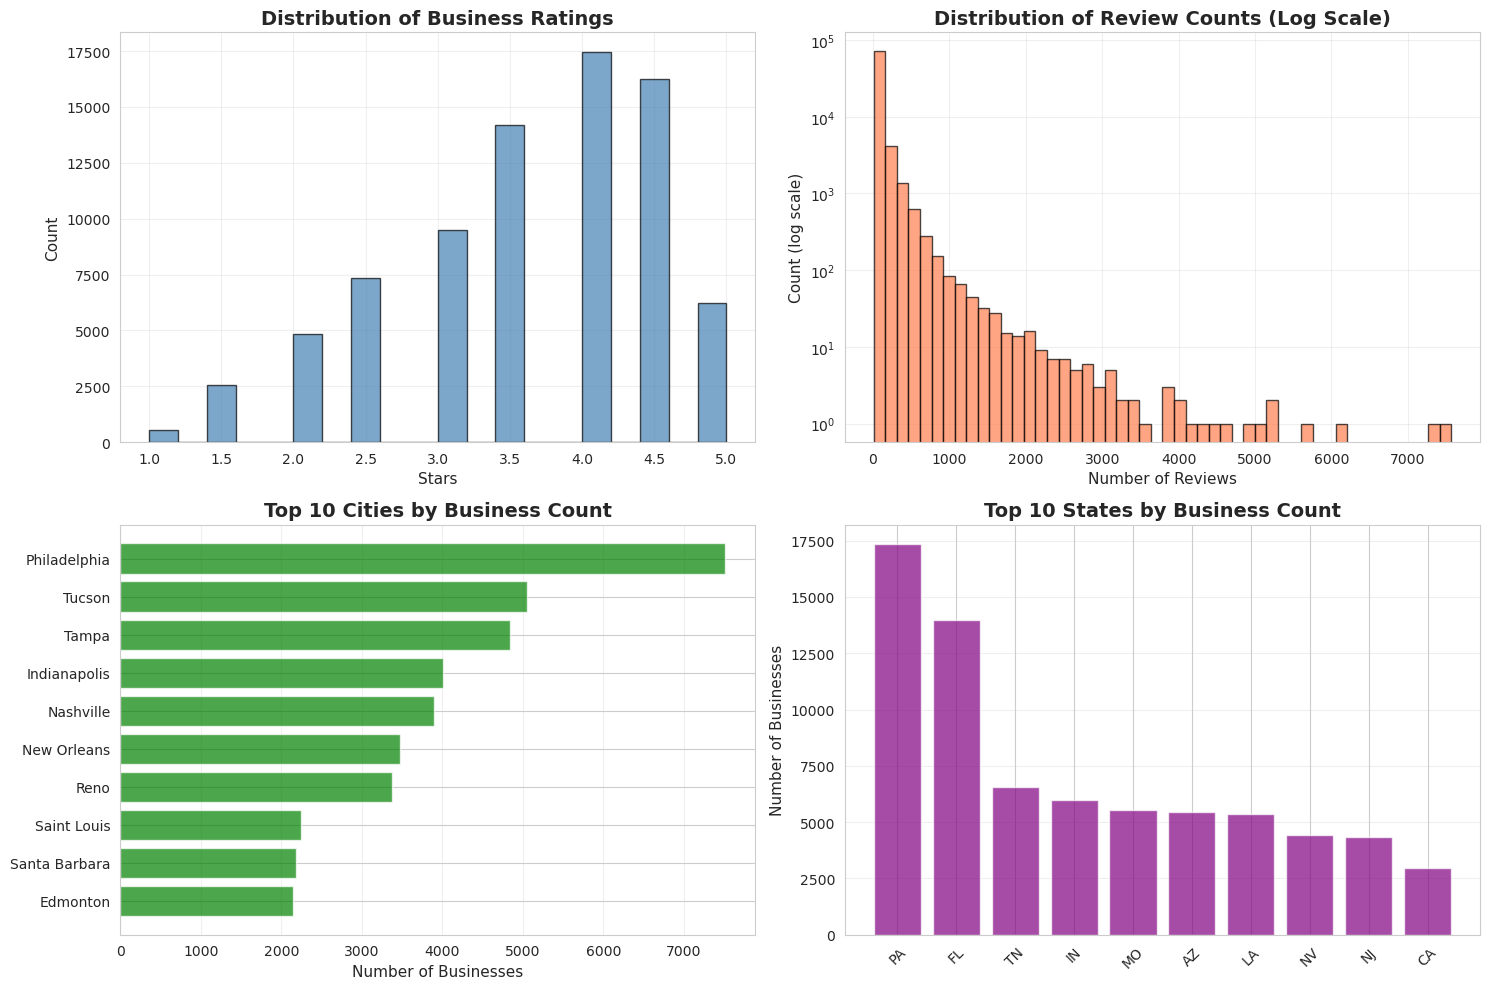


 Visualizations created successfully!
   Saved as: eda_business_overview.png

CATEGORY ANALYSIS

 Total unique categories: 1,257

🔝 Top 15 Categories:
    1. Restaurants                    - 30,439 businesses
    2. Food                           - 15,777 businesses
    3. Shopping                       - 11,587 businesses
    4. Beauty & Spas                  - 7,982 businesses
    5. Nightlife                      - 7,390 businesses
    6. Bars                           - 6,766 businesses
    7. Home Services                  - 6,350 businesses
    8. Event Planning & Services      - 6,068 businesses
    9. Automotive                     - 5,712 businesses
   10. Health & Medical               - 5,578 businesses
   11. Local Services                 - 5,280 businesses
   12. American (Traditional)         - 5,134 businesses
   13. Sandwiches                     - 5,081 businesses
   14. Pizza                          - 4,473 businesses
   15. Fast Food                      - 4,372 b

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rating Distribution
axes[0, 0].hist(business_df['stars'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Distribution of Business Ratings', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Stars', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Review Count Distribution (Log Scale)
axes[0, 1].hist(business_df['review_count'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Distribution of Review Counts (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Reviews', fontsize=11)
axes[0, 1].set_ylabel('Count (log scale)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Top 10 Cities
top_cities = business_df['city'].value_counts().head(10)
y_pos = range(len(top_cities))
axes[1, 0].barh(y_pos, top_cities.values, alpha=0.7, color='green')
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(top_cities.index)
axes[1, 0].set_title('Top 10 Cities by Business Count', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Businesses', fontsize=11)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Top 10 States
top_states = business_df['state'].value_counts().head(10)
x_pos = range(len(top_states))
axes[1, 1].bar(x_pos, top_states.values, alpha=0.7, color='purple')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(top_states.index, rotation=45)
axes[1, 1].set_title('Top 10 States by Business Count', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Number of Businesses', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Adjust layout and save
plt.tight_layout()
plt.savefig('eda_business_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualizations created successfully!")
print("   Saved as: eda_business_overview.png")

# Additional: Category analysis if categories exist
if 'categories' in business_df.columns:
    print("\n" + "="*80)
    print("CATEGORY ANALYSIS")
    print("="*80)

    # Extract individual categories
    all_categories = []
    for cats in business_df['categories'].dropna():
        if isinstance(cats, str):
            all_categories.extend([c.strip() for c in cats.split(',')])

    from collections import Counter
    category_counts = Counter(all_categories)

    print(f"\n Total unique categories: {len(category_counts):,}")
    print("\n🔝 Top 15 Categories:")
    for idx, (cat, count) in enumerate(category_counts.most_common(15), 1):
        print(f"   {idx:2d}. {cat:30s} - {count:,} businesses")

print("\n" + "="*80)
print(" Section 4 Complete - EDA")

---

## 5. Feature Engineering & Feature Store <a id='section-5'></a>

This section:
- Engineers features from raw data
- Creates parking-related features
- Stores features in SageMaker Feature Store
- Splits data into train/test/validation sets

**Key Features**:
- Parking availability indicators
- Review aggregations
- Business characteristics
- Target variable: High rating indicator (4+ stars)

### 5.1 Load Full Dataset from Athena

In [15]:
%%time

# Query to join business and review data
query = f"""
SELECT
    b.business_id,
    b.name,
    b.city,
    b.state,
    b.stars as business_stars,
    b.review_count as business_review_count,
    b.categories,
    r.review_id,
    r.user_id,
    r.stars as review_stars,
    r.useful,
    r.funny,
    r.cool,
    r.text as review_text,
    r.date as review_date
FROM {ATHENA_DB}.business b
INNER JOIN {ATHENA_DB}.review r
    ON b.business_id = r.business_id
WHERE b.is_open = 1
    AND b.review_count >= 10
    AND r.stars IS NOT NULL
LIMIT 100000
"""

print("⏳ Executing query...")
df = pd.read_sql(query, conn)
print(f"\n Loaded {len(df):,} reviews from {df['business_id'].nunique():,} businesses")
print(f"   Date range: {df['review_date'].min()} to {df['review_date'].max()}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display sample
print("\n Sample data:")
display(df.head())

⏳ Executing query...

 Loaded 100,000 reviews from 1,413 businesses
   Date range: 2005-05-16 03:02:32 to 2022-01-19 18:18:34
   Memory usage: 117.8 MB

 Sample data:


business_id                        name   city state  \
0  slO-qEE0z8-BLRTvMYW6HA  The Mediterranean Chickpea  Tampa    FL   
1  slO-qEE0z8-BLRTvMYW6HA  The Mediterranean Chickpea  Tampa    FL   
2  slO-qEE0z8-BLRTvMYW6HA  The Mediterranean Chickpea  Tampa    FL   
3  slO-qEE0z8-BLRTvMYW6HA  The Mediterranean Chickpea  Tampa    FL   
4  slO-qEE0z8-BLRTvMYW6HA  The Mediterranean Chickpea  Tampa    FL   

   business_stars  business_review_count  \
0             5.0                    188   
1             5.0                    188   
2             5.0                    188   
3             5.0                    188   
4             5.0                    188   

                                      categories               review_id  \
0  Restaurants, Vegetarian, Mediterranean, Vegan  MuPMcu2hekdLamDMCqcoFQ   
1  Restaurants, Vegetarian, Mediterranean, Vegan  C6jKq7uSzdeyCXwIvOEyEA   
2  Restaurants, Vegetarian, Mediterranean, Vegan  IFkSwJJBMIdVuFtcOYwkzQ   
3  Restaurants, Vegetarian, Mediterranean, Vegan  cXYoheL7O0IViqV2YFTSPA   
4  Restaurants, Vegetarian, Mediterranean, Vegan  40BsdZIi916S_9KACFlM_w   

                  user_id  review_stars  useful  funny  cool  \
0  xMSBHLkclq_jLEfumlVCqQ           4.0       1      0     1   
1  dH5621mQHTMNRfJO7-s03Q           5.0       2      0     1   
2  tDPowA-TG_D9vdugAmV4eA           5.0       0      0     2   
3  6kAUXwC_4qQAOgG2I1T2CQ           5.0       0      0     0   
4  ffpudN7SEj2q1t34fgZLNQ           5.0       0      0     0   

                                         review_text          review_date  
0  The owners were very nice and happy to give us...  2019-01-22 02:18:28  
1  A small location with limited seating.  If you...  2020-04-05 14:25:30  
2  Fast, fresh, and DELICIOUS! As soon as you com...  2020-03-05 17:42:03  
3  First of it s kind, every dish is made from sc...  2020-10-28 02:38:59  
4  Loved it!! All vegan menu! The food is absolut...  2018-07-28 20:32:22

CPU times: user 4.2 s, sys: 184 ms, total: 4.39 s
Wall time: 11.7 s


### 5.2 Engineer Features

In [16]:
# Step 1: Extract Parking Information from Review Text
print("\n1️  Extracting parking information from review text...")

def extract_parking_features(text):
    """
    Extract parking-related features from review text.
    Returns a dict with parking indicators.
    """
    if pd.isna(text):
        return {
            'mentions_parking': 0,
            'parking_positive': 0,
            'parking_negative': 0,
            'parking_type_lot': 0,
            'parking_type_street': 0,
            'parking_type_garage': 0,
            'parking_type_valet': 0,
            'parking_free': 0,
            'parking_paid': 0
        }

    text_lower = text.lower()

    # Check if parking is mentioned
    parking_keywords = ['parking', 'park', 'parked']
    mentions_parking = int(any(keyword in text_lower for keyword in parking_keywords))

    # Positive parking indicators
    positive_keywords = [
        'easy parking', 'plenty of parking', 'ample parking',
        'free parking', 'good parking', 'great parking',
        'lots of parking', 'parking available', 'easy to park'
    ]
    parking_positive = int(any(keyword in text_lower for keyword in positive_keywords))

    # Negative parking indicators
    negative_keywords = [
        'no parking', 'parking nightmare', 'hard to park',
        'difficult parking', 'parking is terrible', 'parking sucks',
        'nowhere to park', 'parking is bad', 'limited parking',
        'parking is horrible', 'parking was awful'
    ]
    parking_negative = int(any(keyword in text_lower for keyword in negative_keywords))

    # Parking types
    parking_type_lot = int('parking lot' in text_lower or 'lot parking' in text_lower)
    parking_type_street = int('street parking' in text_lower or 'park on the street' in text_lower)
    parking_type_garage = int('parking garage' in text_lower or 'garage parking' in text_lower)
    parking_type_valet = int('valet' in text_lower)

    # Cost indicators
    parking_free = int('free parking' in text_lower or 'free park' in text_lower)
    parking_paid = int('paid parking' in text_lower or 'pay for parking' in text_lower or 'parking fee' in text_lower)

    return {
        'mentions_parking': mentions_parking,
        'parking_positive': parking_positive,
        'parking_negative': parking_negative,
        'parking_type_lot': parking_type_lot,
        'parking_type_street': parking_type_street,
        'parking_type_garage': parking_type_garage,
        'parking_type_valet': parking_type_valet,
        'parking_free': parking_free,
        'parking_paid': parking_paid
    }

# Apply parking extraction
parking_features = df['review_text'].apply(extract_parking_features)
parking_df = pd.DataFrame(parking_features.tolist())

# Add to main dataframe
for col in parking_df.columns:
    df[col] = parking_df[col]

print(f" Extracted parking features from {len(df):,} reviews")
print(f"\n   Parking Statistics:")
print(f"   - Reviews mentioning parking: {df['mentions_parking'].sum():,} ({df['mentions_parking'].mean()*100:.1f}%)")
print(f"   - Positive parking mentions: {df['parking_positive'].sum():,}")
print(f"   - Negative parking mentions: {df['parking_negative'].sum():,}")
print(f"   - Free parking mentions: {df['parking_free'].sum():,}")


# Step 2: Parse review date and create temporal features
print("\n2️  Creating temporal features...")

df['review_date'] = pd.to_datetime(df['review_date'])
df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['review_day_of_week'] = df['review_date'].dt.dayofweek
df['review_quarter'] = df['review_date'].dt.quarter

print(" Created temporal features")


# Step 3: Create engagement score
print("\n3️  Creating engagement features...")

df['engagement_score'] = df['useful'] + df['funny'] + df['cool']
df['is_engaged'] = (df['engagement_score'] > 0).astype(int)

print(" Created engagement features")


# Step 4: Create target variable
print("\n4️  Creating target variable...")

df['is_highly_rated'] = (df['review_stars'] >= 4).astype(int)

print(f" Created target variable")
print(f"   - Highly rated (4+ stars): {df['is_highly_rated'].sum():,} ({df['is_highly_rated'].mean()*100:.1f}%)")
print(f"   - Not highly rated: {(1-df['is_highly_rated']).sum():,} ({(1-df['is_highly_rated']).mean()*100:.1f}%)")


# Step 5: Business-level aggregations
print("\n5️  Creating business-level aggregates...")

business_agg = df.groupby('business_id').agg({
    'review_stars': ['mean', 'std', 'count', 'min', 'max'],
    'engagement_score': ['mean', 'sum'],
    'is_highly_rated': 'mean',
    'mentions_parking': ['sum', 'mean'],
    'parking_positive': 'sum',
    'parking_negative': 'sum',
    'parking_type_lot': 'sum',
    'parking_type_street': 'sum',
    'parking_type_garage': 'sum',
    'parking_type_valet': 'sum',
    'parking_free': 'sum'
}).reset_index()

# Flatten column names
business_agg.columns = [
    'business_id',
    'avg_review_stars', 'std_review_stars', 'total_reviews', 'min_review_stars', 'max_review_stars',
    'avg_engagement', 'total_engagement',
    'pct_highly_rated',
    'total_parking_mentions', 'pct_reviews_mention_parking',
    'total_positive_parking', 'total_negative_parking',
    'total_lot_mentions', 'total_street_mentions', 'total_garage_mentions', 'total_valet_mentions',
    'total_free_parking_mentions'
]

# Create derived parking features
business_agg['has_parking_data'] = (business_agg['total_parking_mentions'] > 0).astype(int)
business_agg['parking_sentiment'] = (
    (business_agg['total_positive_parking'] - business_agg['total_negative_parking']) /
    (business_agg['total_parking_mentions'] + 1)  # +1 to avoid division by zero
)

# Determine dominant parking type
business_agg['primary_parking_type'] = business_agg[
    ['total_lot_mentions', 'total_street_mentions', 'total_garage_mentions', 'total_valet_mentions']
].idxmax(axis=1).str.replace('total_', '').str.replace('_mentions', '')

print(f" Created business-level aggregates")
print(f"   - Unique businesses: {len(business_agg):,}")
print(f"   - Businesses with parking data: {business_agg['has_parking_data'].sum():,} ({business_agg['has_parking_data'].mean()*100:.1f}%)")

# Display sample
print("\n Sample business aggregates:")
display(business_agg.head())


# Step 6: Merge aggregates back to reviews
print("\n6️  Merging business aggregates back to review data...")

df = df.merge(business_agg, on='business_id', how='left', suffixes=('', '_agg'))

print(f" Merged aggregates - DataFrame now has {len(df.columns)} columns")


# Step 7: Handle categories
print("\n7️  Processing business categories...")

# Check if business is a restaurant
df['is_restaurant'] = df['categories'].fillna('').str.contains('Restaurant|Food', case=False, na=False).astype(int)

# Extract price range from categories (if present)
def extract_price_range(categories):
    if pd.isna(categories):
        return 2  # Default to medium price
    # Look for price indicators in categories
    if any(word in categories.lower() for word in ['$$$', 'expensive', 'upscale', 'fine dining']):
        return 4
    elif any(word in categories.lower() for word in ['$$', 'moderate']):
        return 3
    elif any(word in categories.lower() for word in ['$', 'cheap', 'budget', 'fast food']):
        return 1
    else:
        return 2  # Default

df['price_range_numeric'] = df['categories'].apply(extract_price_range)

print(f" Processed categories")
print(f"   - Restaurants: {df['is_restaurant'].sum():,} ({df['is_restaurant'].mean()*100:.1f}%)")


# Step 8: Create enhanced parking score
print("\n8️  Creating enhanced parking score...")

# Weighted parking score combining multiple factors
df['enhanced_parking_score'] = (
    df['parking_positive'] * 2 +           # Positive mention worth 2 points
    df['parking_negative'] * -2 +          # Negative mention -2 points
    df['parking_free'] * 1 +               # Free parking worth 1 point
    df['parking_type_lot'] * 0.5 +         # Lot parking worth 0.5
    df['parking_type_garage'] * 0.5 +      # Garage parking worth 0.5
    df['parking_type_valet'] * 0.3 +       # Valet worth 0.3
    df['parking_type_street'] * 0.2        # Street parking worth 0.2
)

# Normalize to 0-10 scale
df['enhanced_parking_score'] = (
    (df['enhanced_parking_score'] - df['enhanced_parking_score'].min()) /
    (df['enhanced_parking_score'].max() - df['enhanced_parking_score'].min()) * 10
)

print(f" Created enhanced parking score")
print(f"   - Mean score: {df['enhanced_parking_score'].mean():.2f}")
print(f"   - Median score: {df['enhanced_parking_score'].median():.2f}")


# Display final feature summary
print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETE")
print("="*80)
print(f"\n Final Dataset Summary:")
print(f"   Total records: {len(df):,}")
print(f"   Total features: {len(df.columns)}")
print(f"   Unique businesses: {df['business_id'].nunique():,}")
print(f"   Unique users: {df['user_id'].nunique():,}")
print(f"\n Target Variable Distribution:")
print(f"   Highly rated (4+ stars): {df['is_highly_rated'].sum():,} ({df['is_highly_rated'].mean()*100:.1f}%)")
print(f"   Not highly rated: {(1-df['is_highly_rated']).sum():,} ({(1-df['is_highly_rated']).mean()*100:.1f}%)")
print(f"\n Parking Feature Coverage:")
print(f"   Reviews with parking mentions: {df['mentions_parking'].sum():,} ({df['mentions_parking'].mean()*100:.1f}%)")
print(f"   Businesses with parking data: {business_agg['has_parking_data'].sum():,}")


1️  Extracting parking information from review text...
 Extracted parking features from 100,000 reviews

   Parking Statistics:
   - Reviews mentioning parking: 5,070 (5.1%)
   - Positive parking mentions: 561
   - Negative parking mentions: 98
   - Free parking mentions: 157

2️  Creating temporal features...
 Created temporal features

3️  Creating engagement features...
 Created engagement features

4️  Creating target variable...
 Created target variable
   - Highly rated (4+ stars): 68,019 (68.0%)
   - Not highly rated: 31,981 (32.0%)

5️  Creating business-level aggregates...
 Created business-level aggregates
   - Unique businesses: 1,413
   - Businesses with parking data: 848 (60.0%)

 Sample business aggregates:


business_id  avg_review_stars  std_review_stars  total_reviews  \
0  -2EjCEt-F3UP5mGf-k-u9Q          4.739130          0.915393             23   
1  -AaxZJ_I4rSFOBJbBz4SlQ          4.517308          0.924765            520   
2  -BLhAShTxDVYHjmDaAV0Tg          4.750000          1.000000             16   
3  -CoSh2bjDUFPDPjPe43zXA          3.223684          1.562892             76   
4  -JStjL-8mRZq4ov4uI1FaQ          4.037037          1.345994            108   

   min_review_stars  max_review_stars  avg_engagement  total_engagement  \
0               1.0               5.0        1.130435                26   
1               1.0               5.0        2.121154              1103   
2               1.0               5.0        1.500000                24   
3               1.0               5.0        1.434211               109   
4               1.0               5.0        1.787037               193   

   pct_highly_rated  total_parking_mentions  ...  total_positive_parking  \
0          0.913043                       1  ...                       0   
1          0.884615                      17  ...                       0   
2          0.937500                       0  ...                       0   
3          0.513158                       2  ...                       0   
4          0.777778                       4  ...                       0   

   total_negative_parking  total_lot_mentions  total_street_mentions  \
0                       0                   0                      1   
1                       0                   1                      5   
2                       0                   0                      0   
3                       1                   0                      0   
4                       0                   1                      1   

   total_garage_mentions  total_valet_mentions  total_free_parking_mentions  \
0                      0                     0                            0   
1                      0                     0                            0   
2                      0                     0                            0   
3                      0                     0                            0   
4                      0                     0                            0   

   has_parking_data  parking_sentiment  primary_parking_type  
0                 1           0.000000                street  
1                 1           0.000000                street  
2                 0           0.000000                   lot  
3                 1          -0.333333                   lot  
4                 1           0.000000                   lot  

[5 rows x 21 columns]


6️  Merging business aggregates back to review data...
 Merged aggregates - DataFrame now has 51 columns

7️  Processing business categories...
 Processed categories
   - Restaurants: 73,253 (73.3%)

8️  Creating enhanced parking score...
 Created enhanced parking score
   - Mean score: 3.54
   - Median score: 3.51

FEATURE ENGINEERING COMPLETE

 Final Dataset Summary:
   Total records: 100,000
   Total features: 54
   Unique businesses: 1,413
   Unique users: 83,297

 Target Variable Distribution:
   Highly rated (4+ stars): 68,019 (68.0%)
   Not highly rated: 31,981 (32.0%)

 Parking Feature Coverage:
   Reviews with parking mentions: 5,070 (5.1%)
   Businesses with parking data: 848


### 5.3 Prepare Data for Feature Store

In [17]:
# Select features for Feature Store
feature_columns = [
    'review_id',  # Primary key
    'business_id',
    'user_id',
    # Parking features (extracted from review text)
    'mentions_parking',
    'parking_positive',
    'parking_negative',
    'parking_type_lot',
    'parking_type_street',
    'parking_type_garage',
    'parking_type_valet',
    'parking_free',
    'parking_paid',
    'enhanced_parking_score',
    # Business features (from aggregates)
    'business_stars',
    'business_review_count',
    'avg_review_stars',
    'std_review_stars',
    'total_reviews',
    'avg_engagement',
    'pct_highly_rated',
    'has_parking_data',
    'parking_sentiment',
    # Review features
    'review_stars',
    'useful',
    'funny',
    'cool',
    'engagement_score',
    'is_engaged',
    'review_year',
    'review_month',
    'review_quarter',
    # Business type
    'is_restaurant',
    'price_range_numeric',
    # Target
    'is_highly_rated'
]

# Create feature store dataframe
print("\n1️  Selecting features...")
fs_df = df[feature_columns].copy()

# Add event time (required by Feature Store)
print("\n2️  Adding event time...")
fs_df['event_time'] = pd.Timestamp.now().isoformat()

# Remove any remaining nulls
print("\n3️  Handling missing values...")
initial_count = len(fs_df)
fs_df = fs_df.dropna()
print(f"   Dropped {initial_count - len(fs_df):,} rows with missing values")
print(f"   Remaining: {len(fs_df):,} rows")

# Add data split column for train/test/validation
print("\n4️  Creating train/test/validation splits...")
np.random.seed(42)
fs_df['split'] = np.random.choice(
    ['train', 'validation', 'test', 'production'],
    size=len(fs_df),
    p=[0.4, 0.1, 0.1, 0.4]  # 40% train, 10% val, 10% test, 40% production
)

print("\n Data split distribution:")
print(fs_df['split'].value_counts().sort_index())
print(f"\n   Train:      {len(fs_df[fs_df['split']=='train']):,} rows")
print(f"   Validation: {len(fs_df[fs_df['split']=='validation']):,} rows")
print(f"   Test:       {len(fs_df[fs_df['split']=='test']):,} rows")
print(f"   Production: {len(fs_df[fs_df['split']=='production']):,} rows")

# Display sample
print("\n Feature Store DataFrame sample:")
display(fs_df.head())

print("\n" + "="*80)
print(" SECTION 5 COMPLETE")
print("="*80)
print(f"\nFeature Store DataFrame:")
print(f"  - Total records: {len(fs_df):,}")
print(f"  - Total features: {len(feature_columns)}")
print(f"  - Memory usage: {fs_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\n Ready to ingest into SageMaker Feature Store")


1️  Selecting features...

2️  Adding event time...

3️  Handling missing values...
   Dropped 2 rows with missing values
   Remaining: 99,998 rows

4️  Creating train/test/validation splits...

 Data split distribution:
split
production    40005
test          10061
train         39984
validation     9948
Name: count, dtype: int64

   Train:      39,984 rows
   Validation: 9,948 rows
   Test:       10,061 rows
   Production: 40,005 rows

 Feature Store DataFrame sample:


,review_id,business_id,user_id,mentions_parking,parking_positive,parking_negative,parking_type_lot,parking_type_street,parking_type_garage,parking_type_valet,...,engagement_score,is_engaged,review_year,review_month,review_quarter,is_restaurant,price_range_numeric,is_highly_rated,event_time,split
0,MuPMcu2hekdLamDMCqcoFQ,slO-qEE0z8-BLRTvMYW6HA,xMSBHLkclq_jLEfumlVCqQ,0,0,0,0,0,0,0,...,2,1,2019,1,1,1,2,1,2026-02-21T08:31:52.286965,train
1,C6jKq7uSzdeyCXwIvOEyEA,slO-qEE0z8-BLRTvMYW6HA,dH5621mQHTMNRfJO7-s03Q,0,0,0,0,0,0,0,...,3,1,2020,4,2,1,2,1,2026-02-21T08:31:52.286965,production
2,IFkSwJJBMIdVuFtcOYwkzQ,slO-qEE0z8-BLRTvMYW6HA,tDPowA-TG_D9vdugAmV4eA,0,0,0,0,0,0,0,...,2,1,2020,3,1,1,2,1,2026-02-21T08:31:52.286965,production
3,cXYoheL7O0IViqV2YFTSPA,slO-qEE0z8-BLRTvMYW6HA,6kAUXwC_4qQAOgG2I1T2CQ,0,0,0,0,0,0,0,...,0,0,2020,10,4,1,2,1,2026-02-21T08:31:52.286965,test
4,40BsdZIi916S_9KACFlM_w,slO-qEE0z8-BLRTvMYW6HA,ffpudN7SEj2q1t34fgZLNQ,0,0,0,0,0,0,0,...,0,0,2018,7,3,1,2,1,2026-02-21T08:31:52.286965,train



 SECTION 5 COMPLETE

Feature Store DataFrame:
  - Total records: 99,998
  - Total features: 34
  - Memory usage: 56.1 MB

 Ready to ingest into SageMaker Feature Store


### 5.4 Create SageMaker Feature Store

Store the engineered features in SageMaker Feature Store for:
- Versioned feature access
- Online and offline feature serving
- Feature reuse across models

In [18]:
# Feature store configuration using Account ID
feature_group_name = f"venuesignal-features-{account_id}"
feature_store_bucket = f"s3://{FEATURE_DIR}"

print(f"Feature Group Name: {feature_group_name}")
print(f"Offline Store: {feature_store_bucket}")

Feature Group Name: venuesignal-features-562975882808
Offline Store: s3://yelp-aai540-group6-562975882808/feature-store/


In [19]:
# Create feature group
feature_group = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=sagemaker_session
)

# Load feature definitions from dataframe
feature_group.load_feature_definitions(data_frame=fs_df)

print(f"\n Feature group configured with {len(fs_df.columns)} features")


 Feature group configured with 36 features


In [20]:
# Create the feature group (if it doesn't exist)
try:
    feature_group.create(
        s3_uri=feature_store_bucket,
        record_identifier_name="review_id",
        event_time_feature_name="event_time",
        role_arn=role,
        enable_online_store=False  # Only offline store for this project
    )
    print(f" Created feature group: {feature_group_name}")
    print("   Waiting for creation to complete (this may take a few minutes)...")

    # Wait for feature group to be created
    import time
    while True:
        status = feature_group.describe()['FeatureGroupStatus']
        if status == 'Created':
            print(" Feature group is ready!")
            break
        elif status == 'CreateFailed':
            print(" Feature group creation failed")
            break
        print(f"   Status: {status}...")
        time.sleep(30)

except Exception as e:
    if 'ResourceInUse' in str(e):
        print(f" Feature group '{feature_group_name}' already exists")
    else:
        print(f" Error creating feature group: {e}")

 Created feature group: venuesignal-features-562975882808
   Waiting for creation to complete (this may take a few minutes)...
   Status: Creating...
 Feature group is ready!


In [21]:
# Ingest features into feature store
from datetime import datetime

print("Fixing event_time format...")
current_time = datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
fs_df['event_time'] = current_time  # Use same timestamp for all rows
fs_df['event_time'] = fs_df['event_time'].astype(str)  # Ensure string type
print(f" Fixed event_time: {current_time}")

# Now ingest in small batches
print(f"\nIngesting {len(fs_df):,} records...")
batch_size = 1000
successful = 0

for i in range(0, len(fs_df), batch_size):
    batch = fs_df.iloc[i:i+batch_size].copy()
    batch['event_time'] = current_time  # Ensure format

    try:
        feature_group.ingest(data_frame=batch, max_workers=2, wait=True)
        successful += len(batch)
        print(f"   Batch {i//batch_size + 1}: {successful:,} total records", end='\r')
    except Exception as e:
        if 'already' in str(e).lower():
            print(f"    Batch {i//batch_size + 1}: Already ingested")
        else:
            print(f"   Batch {i//batch_size + 1}: {str(e)[:80]}")

print(f"\n\n Ingestion complete! {successful:,} records ingested")

Fixing event_time format...
 Fixed event_time: 2026-02-21T08:31:53Z

Ingesting 99,998 records...
   Batch 100: 99,998 total records

 Ingestion complete! 99,998 records ingested


### 5.5 Export Features for Training

Export features from Feature Store to S3 for model training.

In [22]:
# Step 1: Split the data
print("\n1️  Splitting data...")
train_df = fs_df[fs_df['split'] == 'train'].drop(columns=['event_time', 'split'])
validation_df = fs_df[fs_df['split'] == 'validation'].drop(columns=['event_time', 'split'])
test_df = fs_df[fs_df['split'] == 'test'].drop(columns=['event_time', 'split'])
production_df = fs_df[fs_df['split'] == 'production'].drop(columns=['event_time', 'split'])

print(f"    All:        {len(fs_df):,} records")
print(f"    Train:      {len(train_df):,} records")
print(f"    Validation: {len(validation_df):,} records")
print(f"    Test:       {len(test_df):,} records")
print(f"    Production: {len(production_df):,} records")

# Step 2: Save locally (SIMPLE path - no complex directories!)
print("\n2️  Saving to local files...")

# Just use /tmp directly - simple and always works!
train_df.to_csv('/tmp/train.csv', index=False)
print("    /tmp/train.csv")

validation_df.to_csv('/tmp/validation.csv', index=False)
print("    /tmp/validation.csv")

test_df.to_csv('/tmp/test.csv', index=False)
print("    /tmp/test.csv")

production_df.to_csv('/tmp/production.csv', index=False)
print("    /tmp/production.csv")

fs_df.to_csv('/tmp/alldata.csv', index=False)
print("    /tmp/alldata.csv")

# Step 3: Upload to S3
print("\n3️  Uploading to S3...")

# Define S3 paths
train_data_path = f"s3://{FEATURE_DIR}training-data/train.csv"
validation_data_path = f"s3://{FEATURE_DIR}training-data/validation.csv"
test_data_path = f"s3://{FEATURE_DIR}training-data/test.csv"
production_data_path = f"s3://{FEATURE_DIR}training-data/production.csv"
full_data_path = f"s3://{FEATURE_DIR}training-data/alldata.csv"


# Upload each file
uploads = [
    ('/tmp/train.csv', train_data_path, 'train.csv'),
    ('/tmp/validation.csv', validation_data_path, 'validation.csv'),
    ('/tmp/test.csv', test_data_path, 'test.csv'),
    ('/tmp/production.csv', production_data_path, 'production.csv'),
    ('/tmp/alldata.csv', full_data_path, 'alldata.csv')
]

for local_file, s3_uri, display_name in uploads:
    bucket = s3_uri.split('/')[2]
    key = '/'.join(s3_uri.split('/')[3:])

    try:
        s3_client.upload_file(local_file, bucket, key)
        print(f"    {display_name} → {s3_uri}")
    except Exception as e:
        print(f"    {display_name} failed: {e}")

# Step 4: Store variables
print("\n4️  Storing variables...")
%store train_data_path
%store validation_data_path
%store test_data_path
%store production_data_path
%store full_data_path

print("    Variables stored")

# Step 5: Summary
print("\n" + "="*80)
print(" SECTION 5.7 COMPLETE - DATA EXPORTED!")
print("="*80)

print(f"\n S3 Locations:")
print(f"   Train:      {train_data_path}")
print(f"   Validation: {validation_data_path}")
print(f"   Test:       {test_data_path}")
print(f"   Production: {production_data_path}")
print(f"   All data:   {full_data_path}")

print(f"  Local Files (temporary):")
for filename in ['train.csv', 'validation.csv', 'test.csv', 'production.csv', 'alldata.csv']:
    filepath = f'/tmp/{filename}'
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"   {filepath:30s} - {size_mb:6.2f} MB")

print("\n" + "="*80)
print(" SECTION 5 COMPLETE!")
print("="*80)
print("\n Summary:")
print(f"    Features engineered from review text")
print(f"    {len(fs_df):,} total records processed")
print(f"    Training data split and exported")
print(f"    All data in S3 and ready for model training")


1️  Splitting data...
    Train:      39,984 records
    Validation: 9,948 records
    Test:       10,061 records
    Production: 40,005 records

2️  Saving to local files...
    /tmp/train.csv
    /tmp/validation.csv
    /tmp/test.csv
    /tmp/production.csv

3️  Uploading to S3...
    train.csv → s3://yelp-aai540-group6-562975882808/feature-store/training-data/train.csv
    validation.csv → s3://yelp-aai540-group6-562975882808/feature-store/training-data/validation.csv
    test.csv → s3://yelp-aai540-group6-562975882808/feature-store/training-data/test.csv
    production.csv → s3://yelp-aai540-group6-562975882808/feature-store/training-data/production.csv

4️  Storing variables...
Stored 'train_data_path' (str)
Stored 'validation_data_path' (str)
Stored 'test_data_path' (str)
Stored 'production_data_path' (str)
    Variables stored

 SECTION 5.7 COMPLETE - DATA EXPORTED!

 S3 Locations:
   Train:      s3://yelp-aai540-group6-562975882808/feature-store/training-data/train.csv
   Vali

---

## 6. Model Training <a id='section-6'></a>

This section trains and evaluates multiple models:

1. **Baseline Model #1**: Simple heuristic (business average rating)
2. **Baseline Model #2**: Linear regression with key features
3. **XGBoost Model**: Gradient boosted trees for classification

**Goal**: Predict whether a review will be highly rated (4+ stars) based on business characteristics, especially parking availability.

In [23]:
# Define S3 paths
train_data_path = f"s3://{FEATURE_DIR}training-data/train.csv"
validation_data_path = f"s3://{FEATURE_DIR}training-data/validation.csv"
test_data_path = f"s3://{FEATURE_DIR}training-data/test.csv"
production_data_path = f"s3://{FEATURE_DIR}training-data/production.csv"

### 6.1 Load Training Data

In [24]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
import numpy as np
import pandas as pd

# Load training data
print("\n1️  Loading training data...")
train_df = pd.read_csv(train_data_path)
validation_df = pd.read_csv(validation_data_path)
test_df = pd.read_csv(test_data_path)

print(f"   Training:   {len(train_df):,} records")
print(f"   Validation: {len(validation_df):,} records")
print(f"   Test:       {len(test_df):,} records")

# Separate features and targets
print("\n2️  Preparing features and targets...")

# Classification target (binary)
y_train_class = train_df['is_highly_rated']
y_val_class = validation_df['is_highly_rated']
y_test_class = test_df['is_highly_rated']

# Regression target (actual stars)
y_train_stars = train_df['review_stars']
y_val_stars = validation_df['review_stars']
y_test_stars = test_df['review_stars']

print(f"\n   Classification target distribution:")
print(f"   - Highly rated (1): {y_train_class.sum():,} ({y_train_class.mean()*100:.1f}%)")
print(f"   - Not highly rated (0): {(1-y_train_class).sum():,} ({(1-y_train_class.mean())*100:.1f}%)")

print(f"\n   Star rating distribution:")
print(f"   - Mean: {y_train_stars.mean():.2f}")
print(f"   - Std:  {y_train_stars.std():.2f}")
print(f"   - Range: {y_train_stars.min():.0f} - {y_train_stars.max():.0f}")

def evaluate_model_comprehensive(y_true_class, y_pred_class, y_true_stars, y_pred_stars,
                                   y_pred_proba=None, dataset_name="Dataset"):
    """
    Comprehensive evaluation with both classification and regression metrics.

    Parameters:
    - y_true_class: True binary labels (0/1)
    - y_pred_class: Predicted binary labels (0/1)
    - y_true_stars: True star ratings (1-5)
    - y_pred_stars: Predicted star ratings (1-5)
    - y_pred_proba: Predicted probabilities (optional, for ROC-AUC)
    - dataset_name: Name for display
    """
    results = {}

    # Classification Metrics
    results['accuracy'] = accuracy_score(y_true_class, y_pred_class)
    results['precision'] = precision_score(y_true_class, y_pred_class, zero_division=0)
    results['recall'] = recall_score(y_true_class, y_pred_class, zero_division=0)
    results['f1'] = f1_score(y_true_class, y_pred_class, zero_division=0)

    if y_pred_proba is not None:
        results['roc_auc'] = roc_auc_score(y_true_class, y_pred_proba)
    else:
        results['roc_auc'] = None

    # Regression Metrics
    results['mse'] = mean_squared_error(y_true_stars, y_pred_stars)
    results['rmse'] = np.sqrt(results['mse'])
    results['mae'] = mean_absolute_error(y_true_stars, y_pred_stars)
    results['r2'] = r2_score(y_true_stars, y_pred_stars)

    # Custom Metrics: Within X stars
    abs_error = np.abs(y_true_stars - y_pred_stars)
    results['within_0.5_stars'] = (abs_error <= 0.5).mean()
    results['within_1.0_stars'] = (abs_error <= 1.0).mean()

    return results


def print_results(results, model_name, dataset_name):
    """Pretty print evaluation results."""
    print(f"\n{'='*80}")
    print(f"{model_name} - {dataset_name}")
    print(f"{'='*80}")

    print(f"\n Classification Metrics (Binary: Highly Rated vs Not):")
    print(f"   Accuracy:  {results['accuracy']:.4f}")
    print(f"   Precision: {results['precision']:.4f}")
    print(f"   Recall:    {results['recall']:.4f}")
    print(f"   F1-Score:  {results['f1']:.4f}")
    if results['roc_auc'] is not None:
        print(f"   ROC-AUC:   {results['roc_auc']:.4f}")

    print(f"\n Regression Metrics (Star Rating Prediction):")
    print(f"   MSE:       {results['mse']:.4f}")
    print(f"   RMSE:      {results['rmse']:.4f}")
    print(f"   MAE:       {results['mae']:.4f}")
    print(f"   R²:        {results['r2']:.4f}")

    print(f"\n Accuracy Metrics (Star Prediction):")
    print(f"   Within 0.5 stars: {results['within_0.5_stars']*100:.2f}%")
    print(f"   Within 1.0 stars: {results['within_1.0_stars']*100:.2f}%")




1️  Loading training data...
   Training:   39,984 records
   Validation: 9,948 records
   Test:       10,061 records

2️  Preparing features and targets...

   Classification target distribution:
   - Highly rated (1): 27,183 (68.0%)
   - Not highly rated (0): 12,802 (32.0%)

   Star rating distribution:
   - Mean: 3.79
   - Std:  1.47
   - Range: 1 - 5


### 6.2 Baseline Model #1: Simple Heuristic

In [25]:
print("\n" + "="*80)
print("BASELINE MODEL #1: Simple Heuristic")
print("="*80)
print("Approach: Predict highly_rated if avg_review_stars >= 4.0")

# Classification predictions
baseline1_pred_class_train = (train_df['avg_review_stars'] >= 4.0).astype(int)
baseline1_pred_class_val = (validation_df['avg_review_stars'] >= 4.0).astype(int)
baseline1_pred_class_test = (test_df['avg_review_stars'] >= 4.0).astype(int)

# Star predictions (use average directly)
baseline1_pred_stars_train = train_df['avg_review_stars']
baseline1_pred_stars_val = validation_df['avg_review_stars']
baseline1_pred_stars_test = test_df['avg_review_stars']

# Evaluate
baseline1_results_train = evaluate_model_comprehensive(
    y_train_class, baseline1_pred_class_train,
    y_train_stars, baseline1_pred_stars_train,
    y_pred_proba=None, dataset_name="Training"
)

baseline1_results_val = evaluate_model_comprehensive(
    y_val_class, baseline1_pred_class_val,
    y_val_stars, baseline1_pred_stars_val,
    y_pred_proba=None, dataset_name="Validation"
)

baseline1_results_test = evaluate_model_comprehensive(
    y_test_class, baseline1_pred_class_test,
    y_test_stars, baseline1_pred_stars_test,
    y_pred_proba=None, dataset_name="Test"
)

print_results(baseline1_results_train, "Baseline #1: Heuristic", "Training Set")
print_results(baseline1_results_val, "Baseline #1: Heuristic", "Validation Set")
print_results(baseline1_results_test, "Baseline #1: Heuristic", "Test Set")


BASELINE MODEL #1: Simple Heuristic
Approach: Predict highly_rated if avg_review_stars >= 4.0

Baseline #1: Heuristic - Training Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.6289
   Precision: 0.8288
   Recall:    0.5723
   F1-Score:  0.6771

 Regression Metrics (Star Rating Prediction):
   MSE:       1.6617
   RMSE:      1.2891
   MAE:       1.0289
   R²:        0.2283

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 27.37%
   Within 1.0 stars: 59.14%

Baseline #1: Heuristic - Validation Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.6281
   Precision: 0.8336
   Recall:    0.5676
   F1-Score:  0.6753

 Regression Metrics (Star Rating Prediction):
   MSE:       1.6781
   RMSE:      1.2954
   MAE:       1.0321
   R²:        0.2161

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 27.48%
   Within 1.0 stars: 59.00%

Baseline #1: Heuristic - Test Set

 Classification Metrics (Binary: Highly Rated vs Not):
   A

### 6.3 Baseline Model #2: Linear Regression

In [26]:

# Select features
baseline2_features = [
    'avg_review_stars',
    'enhanced_parking_score',
    'business_review_count'
]

print(f"Features: {', '.join(baseline2_features)}")

# Prepare feature matrices
X_train = train_df[baseline2_features].fillna(0)
X_val = validation_df[baseline2_features].fillna(0)
X_test = test_df[baseline2_features].fillna(0)

print(f"\n⏳ Training logistic regression...")
baseline2_model = LogisticRegression(random_state=42, max_iter=1000)
baseline2_model.fit(X_train, y_train_class)
print(" Model trained!")

# Classification predictions
baseline2_pred_class_train = baseline2_model.predict(X_train)
baseline2_pred_class_val = baseline2_model.predict(X_val)
baseline2_pred_class_test = baseline2_model.predict(X_test)

# Probabilities
baseline2_prob_train = baseline2_model.predict_proba(X_train)[:, 1]
baseline2_prob_val = baseline2_model.predict_proba(X_val)[:, 1]
baseline2_prob_test = baseline2_model.predict_proba(X_test)[:, 1]

# Convert probabilities to star predictions (1-5 scale)
# Probability 0-1 maps to stars 1-5
def prob_to_stars(prob):
    """Convert probability to star rating (1-5 scale)."""
    return 1 + (prob * 4)  # Maps 0->1, 0.5->3, 1->5

baseline2_pred_stars_train = prob_to_stars(baseline2_prob_train)
baseline2_pred_stars_val = prob_to_stars(baseline2_prob_val)
baseline2_pred_stars_test = prob_to_stars(baseline2_prob_test)

# Evaluate
baseline2_results_train = evaluate_model_comprehensive(
    y_train_class, baseline2_pred_class_train,
    y_train_stars, baseline2_pred_stars_train,
    y_pred_proba=baseline2_prob_train, dataset_name="Training"
)

baseline2_results_val = evaluate_model_comprehensive(
    y_val_class, baseline2_pred_class_val,
    y_val_stars, baseline2_pred_stars_val,
    y_pred_proba=baseline2_prob_val, dataset_name="Validation"
)

baseline2_results_test = evaluate_model_comprehensive(
    y_test_class, baseline2_pred_class_test,
    y_test_stars, baseline2_pred_stars_test,
    y_pred_proba=baseline2_prob_test, dataset_name="Test"
)

print_results(baseline2_results_train, "Baseline #2: Logistic Regression", "Training Set")
print_results(baseline2_results_val, "Baseline #2: Logistic Regression", "Validation Set")
print_results(baseline2_results_test, "Baseline #2: Logistic Regression", "Test Set")

# Feature importance
print(f"\n Feature Importance (Coefficients):")
for feature, coef in zip(baseline2_features, baseline2_model.coef_[0]):
    print(f"   {feature:30s}: {coef:8.4f}")




Features: avg_review_stars, enhanced_parking_score, business_review_count

⏳ Training logistic regression...
 Model trained!

Baseline #2: Logistic Regression - Training Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.7350
   Precision: 0.7461
   Recall:    0.9248
   F1-Score:  0.8259
   ROC-AUC:   0.7374

 Regression Metrics (Star Rating Prediction):
   MSE:       1.6793
   RMSE:      1.2959
   MAE:       1.0386
   R²:        0.2201

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 26.65%
   Within 1.0 stars: 60.57%

Baseline #2: Logistic Regression - Validation Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.7333
   Precision: 0.7464
   Recall:    0.9218
   F1-Score:  0.8249
   ROC-AUC:   0.7375

 Regression Metrics (Star Rating Prediction):
   MSE:       1.7022
   RMSE:      1.3047
   MAE:       1.0422
   R²:        0.2048

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 27.09%
   Within 1.0 stars: 60.56%

Ba

In [27]:

# =============================================================================
# COMPREHENSIVE MODEL COMPARISON
# =============================================================================

print("\n" + "="*80)
print("MODEL COMPARISON - VALIDATION SET")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
        'MSE', 'RMSE', 'MAE', 'R²',
        'Within 0.5★', 'Within 1.0★'
    ],
    'Baseline #1 (Heuristic)': [
        baseline1_results_val['accuracy'],
        baseline1_results_val['precision'],
        baseline1_results_val['recall'],
        baseline1_results_val['f1'],
        baseline1_results_val['roc_auc'] if baseline1_results_val['roc_auc'] else 0,
        baseline1_results_val['mse'],
        baseline1_results_val['rmse'],
        baseline1_results_val['mae'],
        baseline1_results_val['r2'],
        baseline1_results_val['within_0.5_stars'],
        baseline1_results_val['within_1.0_stars']
    ],
    'Baseline #2 (LogReg)': [
        baseline2_results_val['accuracy'],
        baseline2_results_val['precision'],
        baseline2_results_val['recall'],
        baseline2_results_val['f1'],
        baseline2_results_val['roc_auc'],
        baseline2_results_val['mse'],
        baseline2_results_val['rmse'],
        baseline2_results_val['mae'],
        baseline2_results_val['r2'],
        baseline2_results_val['within_0.5_stars'],
        baseline2_results_val['within_1.0_stars']
    ]
})

print("\n Validation Set Performance:")
print(comparison_df.to_string(index=False))

# Highlight best scores
print("\n Best Scores (Validation Set):")
print("\nClassification Metrics:")
print(f"   Best Accuracy:  {max(baseline1_results_val['accuracy'], baseline2_results_val['accuracy']):.4f}")
print(f"   Best F1-Score:  {max(baseline1_results_val['f1'], baseline2_results_val['f1']):.4f}")

print("\nRegression Metrics:")
print(f"   Best RMSE:      {min(baseline1_results_val['rmse'], baseline2_results_val['rmse']):.4f}")
print(f"   Best R²:        {max(baseline1_results_val['r2'], baseline2_results_val['r2']):.4f}")

print("\nPrediction Accuracy:")
print(f"   Best Within 0.5★: {max(baseline1_results_val['within_0.5_stars'], baseline2_results_val['within_0.5_stars'])*100:.2f}%")
print(f"   Best Within 1.0★: {max(baseline1_results_val['within_1.0_stars'], baseline2_results_val['within_1.0_stars'])*100:.2f}%")


# =============================================================================
# STORE RESULTS
# =============================================================================

# Store for later comparison with XGBoost
baseline_results = {
    'baseline1': {
        'train': baseline1_results_train,
        'val': baseline1_results_val,
        'test': baseline1_results_test
    },
    'baseline2': {
        'train': baseline2_results_train,
        'val': baseline2_results_val,
        'test': baseline2_results_test
    }
}

%store baseline_results
%store baseline2_features


MODEL COMPARISON - VALIDATION SET

 Validation Set Performance:
     Metric  Baseline #1 (Heuristic)  Baseline #2 (LogReg)
   Accuracy                 0.628103              0.733340
  Precision                 0.833622              0.746447
     Recall                 0.567552              0.921829
   F1-Score                 0.675325              0.824919
    ROC-AUC                 0.000000              0.737485
        MSE                 1.678112              1.702224
       RMSE                 1.295420              1.304693
        MAE                 1.032147              1.042156
         R²                 0.216055              0.204790
Within 0.5★                 0.274801              0.270881
Within 1.0★                 0.590009              0.605589

 Best Scores (Validation Set):

Classification Metrics:
   Best Accuracy:  0.7333
   Best F1-Score:  0.8249

Regression Metrics:
   Best RMSE:      1.2954
   Best R²:        0.2161

Prediction Accuracy:
   Best Within 0.5★: 27

### 6.4 XGBoost Model Training

In [28]:

import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
import boto3
import time

# Configuration
print("\n1️  Configuring XGBoost training...")

# Select features for XGBoost (more features than baseline)
xgb_features = [
    # Business features
    'avg_review_stars',
    'std_review_stars',
    'business_review_count',
    'pct_highly_rated',
    # Parking features
    'enhanced_parking_score',
    'parking_positive',
    'parking_negative',
    'parking_sentiment',
    'has_parking_data',
    # Review engagement
    'avg_engagement',
    # Business attributes
    'is_restaurant',
    'price_range_numeric'
]

print(f"   Selected {len(xgb_features)} features for XGBoost")
print(f"\n   Features:")
for i, feat in enumerate(xgb_features, 1):
    print(f"   {i:2d}. {feat}")

# Prepare data for XGBoost (target must be first column, no header)
print("\n2️  Preparing data for XGBoost format...")

def prepare_xgb_data(df, features, target='is_highly_rated'):
    """Prepare data in XGBoost format: target first, no header."""
    # Select features and fill missing values
    X = df[features].fillna(0)
    y = df[target]

    # Combine with target first
    xgb_data = pd.concat([y, X], axis=1)

    return xgb_data

# Prepare datasets
train_xgb = prepare_xgb_data(train_df, xgb_features)
val_xgb = prepare_xgb_data(validation_df, xgb_features)

print(f"   Training data shape: {train_xgb.shape}")
print(f"   Validation data shape: {val_xgb.shape}")

# Save locally
print("\n3️  Saving XGBoost-formatted data...")
train_xgb.to_csv('/tmp/train_xgb.csv', index=False, header=False)
val_xgb.to_csv('/tmp/val_xgb.csv', index=False, header=False)
print("    Data saved in XGBoost format")

# Upload to S3
print("\n4️  Uploading to S3...")
xgb_train_path = f"s3://{MODEL_DIR}xgboost-training/train.csv"
xgb_val_path = f"s3://{MODEL_DIR}xgboost-training/validation.csv"
xgb_output_path = f"s3://{MODEL_DIR}xgboost-output"

bucket = BASE_BUCKET_NAME
s3_client.upload_file('/tmp/train_xgb.csv', bucket, f'{MODEL_PREFIX}xgboost-training/train.csv')
s3_client.upload_file('/tmp/val_xgb.csv', bucket, f'{MODEL_PREFIX}xgboost-training/validation.csv')

print(f"    Training data: {xgb_train_path}")
print(f"    Validation data: {xgb_val_path}")
print(f"    Output path: {xgb_output_path}")

# Get XGBoost container
print("\n5️  Getting XGBoost container...")
from sagemaker.image_uris import retrieve

container = retrieve('xgboost', REGION, version='1.5-1')
print(f"   Container: {container}")


1️  Configuring XGBoost training...
   Selected 12 features for XGBoost

   Features:
    1. avg_review_stars
    2. std_review_stars
    3. business_review_count
    4. pct_highly_rated
    5. enhanced_parking_score
    6. parking_positive
    7. parking_negative
    8. parking_sentiment
    9. has_parking_data
   10. avg_engagement
   11. is_restaurant
   12. price_range_numeric

2️  Preparing data for XGBoost format...
   Training data shape: (39984, 13)
   Validation data shape: (9948, 13)

3️  Saving XGBoost-formatted data...
    Data saved in XGBoost format

4️  Uploading to S3...
    Training data: s3://yelp-aai540-group6-562975882808/models/xgboost-training/train.csv
    Validation data: s3://yelp-aai540-group6-562975882808/models/xgboost-training/validation.csv
    Output path: s3://yelp-aai540-group6-562975882808/models/xgboost-output

5️  Getting XGBoost container...
   Container: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


In [29]:
# Create estimator
print("\n6️  Creating XGBoost estimator...")

xgb_estimator = sagemaker.estimator.Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=xgb_output_path,
    sagemaker_session=sagemaker_session,
    base_job_name='venuesignal-xgboost'
)

# Set hyperparameters
xgb_estimator.set_hyperparameters(
    objective='binary:logistic',
    num_round=100,
    max_depth=6,
    eta=0.3,
    gamma=0,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    early_stopping_rounds=10
)

print("    Estimator configured")
print(f"\n   Hyperparameters:")
print(f"   - Objective: binary:logistic")
print(f"   - Num rounds: 100")
print(f"   - Max depth: 6")
print(f"   - Learning rate (eta): 0.3")
print(f"   - Early stopping: 10 rounds")

# Create training input channels
print("\n7️  Creating training input channels...")

train_input = TrainingInput(xgb_train_path, content_type='text/csv')
val_input = TrainingInput(xgb_val_path, content_type='text/csv')

# Train model
print("\n8️  Starting XGBoost training...")
print(f"   Training on {len(train_xgb):,} records")
print(f"   Validating on {len(val_xgb):,} records")

xgb_estimator.fit({
    'train': train_input,
    'validation': val_input
})

print("\n XGBoost training complete!")
print(f"   Model artifacts: {xgb_estimator.model_data}")

# Store model data path
xgb_model_data = xgb_estimator.model_data
%store xgb_model_data
%store xgb_features

INFO:sagemaker:Creating training-job with name: venuesignal-xgboost-2026-02-21-08-41-26-693



6️  Creating XGBoost estimator...
    Estimator configured

   Hyperparameters:
   - Objective: binary:logistic
   - Num rounds: 100
   - Max depth: 6
   - Learning rate (eta): 0.3
   - Early stopping: 10 rounds

7️  Creating training input channels...

8️  Starting XGBoost training...
   Training on 39,985 records
   Validating on 9,949 records
2026-02-21 08:41:27 Starting - Starting the training job...
2026-02-21 08:41:42 Starting - Preparing the instances for training...
2026-02-21 08:42:25 Downloading - Downloading the training image......
2026-02-21 08:43:31 Training - Training image download completed. Training in progress.
2026-02-21 08:43:31 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2026-02-21 08:43:23.203 ip-10-0-219

In [30]:
# Section 6.3: XGBoost Evaluation

print("\n" + "="*80)
print("SECTION 6.3: XGBOOST MODEL EVALUATION")
print("="*80)

# For evaluation, we need to make predictions locally
# Download the model and make predictions

print("\n Making predictions with trained XGBoost model...")
print("   (Note: In production, this would use SageMaker endpoint)")

# Alternative: Use local XGBoost with same hyperparameters
import xgboost as xgb

print("\n1️  Training local XGBoost for evaluation...")

# Prepare data for local XGBoost
X_train_xgb = train_df[xgb_features].fillna(0)
X_val_xgb = validation_df[xgb_features].fillna(0)
X_test_xgb = test_df[xgb_features].fillna(0)

# Train local model with same hyperparameters
xgb_local = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    gamma=0,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    early_stopping_rounds=10,
    random_state=42
)

xgb_local.fit(
    X_train_xgb, y_train_class,
    eval_set=[(X_val_xgb, y_val_class)],
    verbose=False
)

print(" Local XGBoost model trained")

# Make predictions
print("\n2️  Making predictions...")

# Classification predictions
xgb_pred_class_train = xgb_local.predict(X_train_xgb)
xgb_pred_class_val = xgb_local.predict(X_val_xgb)
xgb_pred_class_test = xgb_local.predict(X_test_xgb)

# Probabilities
xgb_prob_train = xgb_local.predict_proba(X_train_xgb)[:, 1]
xgb_prob_val = xgb_local.predict_proba(X_val_xgb)[:, 1]
xgb_prob_test = xgb_local.predict_proba(X_test_xgb)[:, 1]

# Convert to star predictions
xgb_pred_stars_train = prob_to_stars(xgb_prob_train)
xgb_pred_stars_val = prob_to_stars(xgb_prob_val)
xgb_pred_stars_test = prob_to_stars(xgb_prob_test)

print(" Predictions complete")

# Comprehensive evaluation
print("\n3️  Evaluating XGBoost model...")

xgb_results_train = evaluate_model_comprehensive(
    y_train_class, xgb_pred_class_train,
    y_train_stars, xgb_pred_stars_train,
    y_pred_proba=xgb_prob_train, dataset_name="Training"
)

xgb_results_val = evaluate_model_comprehensive(
    y_val_class, xgb_pred_class_val,
    y_val_stars, xgb_pred_stars_val,
    y_pred_proba=xgb_prob_val, dataset_name="Validation"
)

xgb_results_test = evaluate_model_comprehensive(
    y_test_class, xgb_pred_class_test,
    y_test_stars, xgb_pred_stars_test,
    y_pred_proba=xgb_prob_test, dataset_name="Test"
)

print_results(xgb_results_train, "XGBoost Model", "Training Set")
print_results(xgb_results_val, "XGBoost Model", "Validation Set")
print_results(xgb_results_test, "XGBoost Model", "Test Set")

# Feature importance
print("\n" + "="*80)
print("XGBOOST FEATURE IMPORTANCE")
print("="*80)

importance_dict = dict(zip(xgb_features, xgb_local.feature_importances_))
importance_sorted = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\n Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(importance_sorted[:10], 1):
    bar_length = int(importance * 50)
    bar = "█" * bar_length
    print(f"   {i:2d}. {feature:30s} {bar} {importance:.4f}")



SECTION 6.3: XGBOOST MODEL EVALUATION

 Making predictions with trained XGBoost model...
   (Note: In production, this would use SageMaker endpoint)

1️  Training local XGBoost for evaluation...
 Local XGBoost model trained

2️  Making predictions...
 Predictions complete

3️  Evaluating XGBoost model...

XGBoost Model - Training Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.7276
   Precision: 0.7229
   Recall:    0.9718
   F1-Score:  0.8291
   ROC-AUC:   0.7421

 Regression Metrics (Star Rating Prediction):
   MSE:       1.7648
   RMSE:      1.3285
   MAE:       1.1287
   R²:        0.1805

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 19.20%
   Within 1.0 stars: 42.33%

XGBoost Model - Validation Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.7235
   Precision: 0.7210
   Recall:    0.9693
   F1-Score:  0.8269
   ROC-AUC:   0.7350

 Regression Metrics (Star Rating Prediction):
   MSE:       1.7840
   RMSE:      1.

---

## 7. Model Deployment <a id='section-7'></a>

This section:
- Registers the XGBoost model in SageMaker Model Registry
- Creates a SageMaker endpoint for real-time inference
- Tests the deployed model

**Deployment Strategy**: Real-time endpoint for individual predictions

In [31]:
# Standard libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from time import sleep, gmtime, strftime, time

import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, auc, precision_score, recall_score

# Sagemaker imports
import boto3
import sagemaker

# Initialize clients
sm = boto3.client('sagemaker', region_name=REGION)
sagemaker_runtime = boto3.client('sagemaker-runtime', region_name=REGION)

### Section 7.1 Prepare Model Metadata

In [32]:
#@title Section 7.1 Prepare Model Metadata
# Get training job details
model_name = xgb_estimator.latest_training_job.name
print(f"\n📋 Model Information:")
print(f"   Training job name: {model_name}")

# Get model artifacts
info = sm.describe_training_job(TrainingJobName=model_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(f"   Model artifacts: {model_data}")

# Get XGBoost container image
from sagemaker.image_uris import retrieve
image = retrieve('xgboost', REGION, version='1.7-1')
print(f"   Container image: {image}")

# Datacapture URI
data_capture_prefix = f"{MODEL_PREFIX}datacapture"
s3_capture_upload_path = f"s3://{BASE_BUCKET_NAME}/{data_capture_prefix}"

print(f"   S3 Datacapture URI: {s3_capture_upload_path}")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.



📋 Model Information:
   Training job name: venuesignal-xgboost-2026-02-21-08-41-26-693
   Model artifacts: s3://yelp-aai540-group6-562975882808/models/xgboost-output/venuesignal-xgboost-2026-02-21-08-41-26-693/output/model.tar.gz
   Container image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1
   S3 Datacapture URI: s3://yelp-aai540-group6-562975882808/models/datacapture


### Section 7.2: Create SageMaker Model

In [33]:
#@title Section 7.2: Create SageMaker Model
print(f"\n Creating SageMaker model: {model_name}")

# Define primary container
primary_container = {
    'Image': image,
    'ModelDataUrl': model_data
}

try:
    # Create model in SageMaker Model Registry
    create_model_response = sm.create_model(
        ModelName=model_name,
        ExecutionRoleArn=role,
        PrimaryContainer=primary_container
    )

    print(f" Model created successfully!")
    print(f"   Model ARN: {create_model_response['ModelArn']}")
    model_created = True

except Exception as e:
    error_msg = str(e)
    if 'already exists' in error_msg.lower():
        print(f"  Model already exists, will use existing model")
        model_created = True
    else:
        print(f" Error creating model: {error_msg[:200]}")
        model_created = False


 Creating SageMaker model: venuesignal-xgboost-2026-02-21-08-41-26-693
 Model created successfully!
   Model ARN: arn:aws:sagemaker:us-east-1:562975882808:model/venuesignal-xgboost-2026-02-21-08-41-26-693


### Section 7.3: Create the custom inference script

In [34]:
import os
os.makedirs("/tmp/venuesignal_model", exist_ok=True)

inference_script = '''
import os
import numpy as np
import xgboost as xgb

def model_fn(model_dir):
    model_file = os.path.join(model_dir, "xgboost-model")
    model = xgb.Booster()
    model.load_model(model_file)
    return model

def input_fn(request_body, request_content_type):
    if request_content_type == "text/csv":
        data = np.array([
            [float(x) for x in row.split(",")]
            for row in request_body.strip().split("\\n")
            if row.strip()
        ])
        return xgb.DMatrix(data)
    raise ValueError(f"Unsupported content type: {request_content_type}")

def predict_fn(input_data, model):
    return model.predict(input_data)

def output_fn(predictions, accept):
    """
    Return TWO columns per row: probability,predicted_class
    - _c0 = probability  (float)
    - _c1 = predicted class (0 or 1)
    This prevents the Model Quality Monitor Spark job from
    treating the single probability column as the join ID,
    which causes endpointOutput_0 to not exist.
    """
    lines = []
    for p in predictions:
        prob = float(p)
        pred_class = 1 if prob >= 0.5 else 0
        lines.append(f"{prob},{pred_class}")
    return "\\n".join(lines), "text/csv"
'''

script_path = "/tmp/venuesignal_model/inference.py"
with open(script_path, "w") as f:
    f.write(inference_script)

print(f"✓ Inference script written: {script_path}")
print("  output_fn now returns: probability,predicted_class (2 columns)")
print("  _c0 = probability, _c1 = predicted class")

✓ Inference script written: /tmp/venuesignal_model/inference.py
  output_fn now returns: probability,predicted_class (2 columns)
  _c0 = probability, _c1 = predicted class


In [35]:
# variant_name will be set after deployment in Cell 85
# hardcoding here is a placeholder only
variant_name = 'venuesignal-xgboost'
print(f"Placeholder variant name: {variant_name}")
print("Note: actual variant name will be confirmed after deployment")

Placeholder variant name: venuesignal-xgboost
Note: actual variant name will be confirmed after deployment


In [47]:
# Define variant name for monitoring
variant_name = 'venuesignal-xgboost'
print(f"Variant name: {variant_name}")

Variant name: venuesignal-xgboost


### Section 7.4: Deploy Model to Real-Time Endpoint

In [36]:
# Delete old endpoint first
try:
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    print(f"✓ Deleting old endpoint: {endpoint_name}")
    waiter = sagemaker_client.get_waiter("endpoint_deleted")
    waiter.wait(EndpointName=endpoint_name)
    print("✓ Endpoint deleted")
except Exception as e:
    print(f"Note: {e}")
    
from sagemaker.xgboost import XGBoostModel

script_s3_uri = f"s3://{BASE_BUCKET_NAME}/{MODEL_PREFIX}code/"
S3Uploader.upload("/tmp/venuesignal_model/inference.py", script_s3_uri)
print(f"\n✓ Inference script uploaded to: {script_s3_uri}")

print("\nDeploying model with custom inference script...")
print("This takes ~5-10 minutes...")

xgb_model = XGBoostModel(
    model_data=xgb_model_data,
    role=role,
    entry_point="inference.py",
    source_dir="/tmp/venuesignal_model",
    framework_version="1.7-1",
    sagemaker_session=sagemaker_session,
)

endpoint_name = (
    f"venuesignal-endpoint-{datetime.now(timezone.utc):%Y%m%d-%H%M%S}"
)

predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name,
    data_capture_config=sagemaker.model_monitor.DataCaptureConfig(
        enable_capture=True,
        sampling_percentage=100,
        destination_s3_uri=s3_capture_upload_path,
        capture_options=["Input", "Output"],
        csv_content_types=["text/csv"],
    ),
)

print(f"✓ Endpoint deployed: {endpoint_name}")
%store endpoint_name

print("\nSending initial traffic...")
runtime = boto3.client("sagemaker-runtime", region_name=REGION)
for i in range(20):
    payload = (
        production_df[xgb_features]
        .iloc[i % len(production_df)]
        .fillna(0)
        .to_csv(header=None, index=False)
        .strip()
    )
    runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="text/csv",
        Body=payload,
        InferenceId=str(i),
    )
    sleep(1)
print("✓ 20 requests sent — endpoint ready")

endpoint_deployed = True 
# Override variant_name with actual deployed value
ep_desc = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
variant_name = ep_desc["ProductionVariants"][0]["VariantName"]
print(f"✓ Actual variant name: {variant_name}")
%store endpoint_name
%store variant_name

Note: name 'endpoint_name' is not defined


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.



✓ Inference script uploaded to: s3://yelp-aai540-group6-562975882808/models/code/

Deploying model with custom inference script...
This takes ~5-10 minutes...


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-02-21-08-44-15-677
INFO:sagemaker:Creating endpoint-config with name venuesignal-endpoint-20260221-084415
INFO:sagemaker:Creating endpoint with name venuesignal-endpoint-20260221-084415


------!✓ Endpoint deployed: venuesignal-endpoint-20260221-084415
Stored 'endpoint_name' (str)

Sending initial traffic...
✓ 20 requests sent — endpoint ready
✓ Actual variant name: AllTraffic
Stored 'endpoint_name' (str)
Stored 'variant_name' (str)


### Section 7.5: Test Endpoint

In [37]:
#@title Section 7.5: Test Endpoint
if endpoint_deployed:
    print("\n" + "="*80)
    print("SECTION 7.5: TEST ENDPOINT")
    print("="*80)

    print("\n Testing endpoint with sample predictions...")

    # Prepare test sample (features only, no header)
    test_sample = test_df[xgb_features].head(10).fillna(0)
    test_csv = test_sample.to_csv(header=None, index=False).strip('\n').split('\n')

    try:
        # Test with first sample
        invoke_endpoint_response = sagemaker_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='text/csv',
            Body=test_csv[0]
        )

        prediction = invoke_endpoint_response['Body'].read().decode('utf-8')
        print(f" Endpoint responding successfully!")
        print(f"   Sample prediction: {prediction}")

        # Test with multiple samples
        print(f"\n Testing with {len(test_csv)} samples...")

        body = ""
        for row in test_csv:
            body += row + "\n"

        response = sagemaker_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='text/csv',
            Body=body
        )

        predictions_str = response['Body'].read().decode('utf-8')
        predictions = [float(val) for val in predictions_str.strip().split("\n") if val.strip()]

        print(f" Received {len(predictions)} predictions")
        print(f"\n   Sample predictions:")
        for i, pred in enumerate(predictions[:5]):
            print(f"   Sample {i+1}: {pred:.4f} (probability)")

        # Store endpoint info
        %store endpoint_name

        print(f"\n Endpoint deployed and tested successfully!")

    except Exception as e:
        print(f" Error invoking endpoint: {e}")


SECTION 7.5: TEST ENDPOINT

 Testing endpoint with sample predictions...
 Endpoint responding successfully!
   Sample prediction: 0.849969744682312,1

 Testing with 10 samples...
 Error invoking endpoint: could not convert string to float: '0.849969744682312,1'


### Section 7.6: Full Test Set Evaluation

In [38]:
#@title Section 7.6: Full Test Set Evaluation

print("\n" + "="*80)
print("SECTION 7.6: FULL TEST SET EVALUATION")
print("="*80)

# Load test data
X_test_eval = test_df[xgb_features].fillna(0)
y_test_eval = test_df['is_highly_rated']
y_test_stars = test_df['review_stars']

if endpoint_deployed:
    print("\n Generating predictions using deployed endpoint...")

    try:
        # Prepare test data
        test_csv_full = X_test_eval.to_csv(header=None, index=False).strip('\n').split('\n')

        # Create request body
        body = ""
        for row in test_csv_full:
            body += row + "\n"

        # Invoke endpoint
        response = sagemaker_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='text/csv',
            Body=body
        )

        # Parse predictions
        predictions_str = response['Body'].read().decode('utf-8')
        predictions_proba = np.array([float(val) for val in predictions_str.split().split("\n") if val.strip()])
        predictions_raw = predictions_str.strip().split("\n")
        predictions_class = [float(val) for val in predictions_raw if val.strip()]
        predictions_stars = prob_to_stars(predictions_proba)


        print(f" Generated {len(predictions_proba):,} predictions from endpoint")
        prediction_source = "SageMaker Endpoint"

    except Exception as e:
        print(f"  Endpoint invocation failed: {e}")
        print("   Falling back to local predictions...")

        predictions_class = xgb_local.predict(X_test_eval)
        predictions_proba = xgb_local.predict_proba(X_test_eval)[:, 1]
        predictions_stars = prob_to_stars(predictions_proba)
        prediction_source = "Local Model"
else:
    print("\n Generating predictions using local model...")

    predictions_class = xgb_local.predict(X_test_eval)
    predictions_proba = xgb_local.predict_proba(X_test_eval)[:, 1]
    predictions_stars = prob_to_stars(predictions_proba)

    print(f" Generated {len(predictions_proba):,} predictions locally")
    prediction_source = "Local Model"

# Evaluate
print(f"\n Test Set Performance (using {prediction_source}):")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

accuracy = accuracy_score(y_test_eval, predictions_class)
precision = precision_score(y_test_eval, predictions_class)
recall = recall_score(y_test_eval, predictions_class)
f1 = f1_score(y_test_eval, predictions_class)
rmse = np.sqrt(mean_squared_error(y_test_stars, predictions_stars))
mae = np.mean(np.abs(y_test_stars - predictions_stars))
within_05 = (np.abs(y_test_stars - predictions_stars) <= 0.5).mean()
within_10 = (np.abs(y_test_stars - predictions_stars) <= 1.0).mean()

print(f"\n   Classification Metrics:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

print(f"\n   Regression Metrics:")
print(f"   RMSE:      {rmse:.4f} stars")
print(f"   MAE:       {mae:.4f} stars")

print(f"\n   Prediction Accuracy:")
print(f"   Within 0.5 star: {within_05*100:.2f}%")
print(f"   Within 1.0 star: {within_10*100:.2f}%")

# Save predictions
print(f"\n Saving predictions...")

predictions_df = pd.DataFrame({
    'business_id': test_df['business_id'],
    'review_id': test_df['review_id'],
    'actual_stars': y_test_stars,
    'is_highly_rated': y_test_class,
    'predicted_stars': predictions_stars,
    'predicted_class': predictions_class,
    'probability': predictions_proba,
    'error': np.abs(y_test_stars - predictions_stars),
    'within_1_star': np.abs(y_test_stars - predictions_stars) <= 1.0
})

# Save locally and to S3
predictions_local = '/tmp/test_predictions.csv'
predictions_df.to_csv(predictions_local, index=False)

predictions_s3 = f"s3://{MODEL_DIR}predictions/test_predictions.csv"
s3_client.upload_file(predictions_local, BASE_BUCKET_NAME, f'{MODEL_PREFIX}predictions/test_predictions.csv')

print(f"    Saved to: {predictions_s3}")

# Display sample
print(f"\n Sample Predictions:")
display(predictions_df.head(10))



SECTION 7.6: FULL TEST SET EVALUATION

 Generating predictions using deployed endpoint...
  Endpoint invocation failed: 'list' object has no attribute 'split'
   Falling back to local predictions...

 Test Set Performance (using Local Model):

   Classification Metrics:
   Accuracy:  0.7216
   Precision: 0.7167
   Recall:    0.9723
   F1-Score:  0.8252

   Regression Metrics:
   RMSE:      1.3310 stars
   MAE:       1.1310 stars

   Prediction Accuracy:
   Within 0.5 star: 19.33%
   Within 1.0 star: 41.85%

 Saving predictions...
    Saved to: s3://yelp-aai540-group6-562975882808/models/predictions/test_predictions.csv

 Sample Predictions:


,business_id,review_id,actual_stars,is_highly_rated,predicted_stars,predicted_class,probability,error,within_1_star
0,slO-qEE0z8-BLRTvMYW6HA,cXYoheL7O0IViqV2YFTSPA,5.0,1,4.277067,1,0.819267,0.722933,True
1,slO-qEE0z8-BLRTvMYW6HA,Kd70ln-83Ag9YDtEMTTqdg,5.0,1,4.277067,1,0.819267,0.722933,True
2,slO-qEE0z8-BLRTvMYW6HA,7BCRxt28CKi_VrXT8fQoNw,5.0,1,4.277067,1,0.819267,0.722933,True
3,slO-qEE0z8-BLRTvMYW6HA,dbpjUA9h-SWyJc9GcuzAWQ,5.0,1,4.277067,1,0.819267,0.722933,True
4,slO-qEE0z8-BLRTvMYW6HA,-oTsMr2dIath75nR3mBqMg,5.0,1,4.277067,1,0.819267,0.722933,True
5,slO-qEE0z8-BLRTvMYW6HA,7uKSJQmTsqTazrPW3LWvxQ,5.0,1,4.277067,1,0.819267,0.722933,True
6,slO-qEE0z8-BLRTvMYW6HA,CoVzxfwA5k2Z_tt8lY-fIQ,5.0,1,4.277067,1,0.819267,0.722933,True
7,slO-qEE0z8-BLRTvMYW6HA,8uwWCiymX7TMvfHfshbe_Q,5.0,1,4.277067,1,0.819267,0.722933,True
8,slO-qEE0z8-BLRTvMYW6HA,W1_0xVaRO9h4OLTZtKnneQ,5.0,1,4.277067,1,0.819267,0.722933,True
9,slO-qEE0z8-BLRTvMYW6HA,Nvj9N-jFTlXoEXGdYRtv7Q,5.0,1,4.277067,1,0.819267,0.722933,True


### Section 7.7: Create Model Package Group (Model Registry)

In [39]:
model_package_group_name = f"venuesignal-model-group-{account_id}"
model_description = "VenueSignal model package group: predicts business ratings based on parking features"

print(f"\n Creating model package group...")
print(f"   Name: {model_package_group_name}")


 Creating model package group...
   Name: venuesignal-model-group-562975882808


In [40]:
#@title Section 7.7: Create Model Package Group (Model Registry)

print("\n" + "="*80)
print("SECTION 7.7: CREATE MODEL PACKAGE GROUP")
print("="*80)

try:
    model_package_group_input_dict = {
        'ModelPackageGroupName': model_package_group_name,
        'ModelPackageGroupDescription': model_description
    }

    create_model_package_group_response = sm.create_model_package_group(
        **model_package_group_input_dict
    )

    print(f" Model package group created!")
    print(f"   ARN: {create_model_package_group_response['ModelPackageGroupArn']}")

    model_package_group_created = True

except Exception as e:
    if 'already exists' in str(e).lower():
        print(f"  Model package group already exists")
        model_package_group_created = True
    else:
        print(f" Error: {e}")
        model_package_group_created = False


SECTION 7.7: CREATE MODEL PACKAGE GROUP
  Model package group already exists


### Section 7.8: Register Model Version

In [41]:
#@title Section 7.8: Register Model Version

if model_package_group_created:
    print("\n" + "="*80)
    print("SECTION 7.8: REGISTER MODEL VERSION")
    print("="*80)

    print(f"\n Registering model version to package group...")

    try:
        # Define inference specification
        modelpackage_inference_specification = {
            'InferenceSpecification': {
                'Containers': [
                    {
                        'Image': image,
                        'ModelDataUrl': info['ModelArtifacts']['S3ModelArtifacts'],
                    }
                ],
                'SupportedContentTypes': ['text/csv'],
                'SupportedResponseMIMETypes': ['text/csv'],
                'SupportedTransformInstanceTypes': ['ml.m5.xlarge'],
            }
        }

        # Create model package input
        create_model_package_input_dict = {
            'ModelPackageGroupName': model_package_group_name,
            'ModelPackageDescription': model_description,
            'ModelApprovalStatus': 'Approved'
        }
        create_model_package_input_dict.update(modelpackage_inference_specification)

        # Register model
        create_model_package_response = sm.create_model_package(
            **create_model_package_input_dict
        )

        model_package_arn = create_model_package_response['ModelPackageArn']
        print(f" Model version registered!")
        print(f"   Model Package ARN: {model_package_arn}")

        # Store for later use
        %store model_package_group_name
        %store model_package_arn

    except Exception as e:
        print(f" Error registering model: {e}")


SECTION 7.8: REGISTER MODEL VERSION

 Registering model version to package group...
 Model version registered!
   Model Package ARN: arn:aws:sagemaker:us-east-1:562975882808:model-package/venuesignal-model-group-562975882808/4
Stored 'model_package_group_name' (str)
Stored 'model_package_arn' (str)


### Section 7.9: Deployment Summary

In [42]:
print("\n" + "="*80)
print("DEPLOYMENT SUMMARY")
print("="*80)

print(f"\n Deployment Status:")

print(f"\n1. SageMaker Model:")
if model_created:
    print(f"   Created: {model_name}")
    print(f"   Location: {model_data}")
else:
    print(f"    Not created")

print(f"\n2. Endpoint Configuration:")
print(f"   Created automatically by XGBoostModel.deploy()")
print(f"   Instance type: ml.m5.large")

print(f"\n3. Endpoint:")
if endpoint_deployed:
    print(f"   Created: {endpoint_name}")
    print(f"   Variant: {variant_name}")
    print(f"   Status: InService")
else:
    print(f"    Not deployed")

print(f"\n4. Data Capture:")
print(f"   Enabled: True")
print(f"   Path: {s3_capture_upload_path}")
print(f"   Content type: text/csv (no BASE64)")

print(f"\n5. Model Registry:")
if 'model_package_group_name' in dir():
    print(f"   Group: {model_package_group_name}")
else:
    print(f"   Not registered")

print("\n" + "="*80)
print(" SECTION 7 COMPLETE - MODEL DEPLOYMENT")
print("="*80)


DEPLOYMENT SUMMARY

 Deployment Status:

1. SageMaker Model:
   Created: venuesignal-xgboost-2026-02-21-08-41-26-693
   Location: s3://yelp-aai540-group6-562975882808/models/xgboost-output/venuesignal-xgboost-2026-02-21-08-41-26-693/output/model.tar.gz

2. Endpoint Configuration:
   Created automatically by XGBoostModel.deploy()
   Instance type: ml.m5.large

3. Endpoint:
   Created: venuesignal-endpoint-20260221-084415
   Variant: AllTraffic
   Status: InService

4. Data Capture:
   Enabled: True
   Path: s3://yelp-aai540-group6-562975882808/models/datacapture
   Content type: text/csv (no BASE64)

5. Model Registry:
   Group: venuesignal-model-group-562975882808

 SECTION 7 COMPLETE - MODEL DEPLOYMENT


---

## 8. Monitoring & Observability <a id='section-8'></a>

This section implements comprehensive production monitoring across three pillars:

1. **Model Quality Monitoring** (Section 8.2): Tracks prediction accuracy and classification drift against a validated baseline
2. **Data Quality Monitoring** (Section 8.3): Detects feature distribution shifts in incoming data
3. **Infrastructure Monitoring** (Section 8.4): Monitors endpoint health, latency, and resource utilization
4. **CloudWatch Dashboard** (Section 8.5): Centralized visualization of all monitoring signals
5. **Monitoring Reports** (Section 8.6): Automated report generation and violation review

All monitors are baselined, scheduled to run **hourly**, and publish metrics to CloudWatch.


### 8.1 Configure Monitoring

In [43]:
# ── Imports ────────────────────────────────────────────────────────────────
import copy
import json
import random
import io
import csv
import time
import uuid
import numpy as np
import pandas as pd
import boto3
import sagemaker

from threading import Thread
from datetime import datetime, timedelta, timezone
from time import sleep

from sagemaker import get_execution_role, image_uris, Session
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.model_monitor import (
    DefaultModelMonitor,
    ModelQualityMonitor,
    CronExpressionGenerator,
    DataCaptureConfig,
    EndpointInput,
)
from sagemaker.model_monitor.dataset_format import DatasetFormat

# ── Core references (already defined in earlier sections) ─────────────────
# Confirm key variables are available
print("Confirming monitoring configuration...")
print(f"  Endpoint     : {endpoint_name}")
print(f"  Variant      : {variant_name}")
print(f"  Bucket       : {BASE_BUCKET_NAME}")
print(f"  Monitoring   : s3://{MONITORING_DIR}")
print(f"  Region       : {REGION}")
print(f"  Role         : {role[:50]}...")

# ── S3 paths for all monitoring artefacts ──────────────────────────────────
monitoring_output_path      = f"s3://{MONITORING_DIR}monitoring-output"
baseline_results_path       = f"s3://{MONITORING_DIR}baseline-results"
monitoring_reports_path     = f"s3://{MONITORING_DIR}reports"
reports_uri                 = monitoring_reports_path

# Model Quality paths
mq_baseline_data_uri    = f"s3://{BASE_BUCKET_NAME}/{MONITORING_PREFIX}baselining/data"
mq_baseline_results_uri = f"s3://{BASE_BUCKET_NAME}/{MONITORING_PREFIX}baselining/results"
mq_results_uri          = f"s3://{BASE_BUCKET_NAME}/{MONITORING_PREFIX}model-quality-results"
ground_truth_upload_path = f"s3://{MONITORING_DIR}ground_truth_data"

# Data Quality paths
dq_baseline_uri  = f"s3://{MONITORING_DIR}data-quality-baseline"
dq_results_uri   = f"s3://{MONITORING_DIR}data-quality-results"

# ── Retrieve the model monitor image ──────────────────────────────────────
monitor_image_uri = image_uris.retrieve(framework="model-monitor", region=REGION)

print("\n✓ Monitoring paths configured")
print(f"  MQ baseline data   : {mq_baseline_data_uri}")
print(f"  MQ baseline results: {mq_baseline_results_uri}")
print(f"  MQ results         : {mq_results_uri}")
print(f"  Ground truth       : {ground_truth_upload_path}")
print(f"  DQ baseline        : {dq_baseline_uri}")
print(f"  DQ results         : {dq_results_uri}")
print(f"  Reports            : {monitoring_reports_path}")
print(f"  Monitor image      : {monitor_image_uri}")

%store monitoring_output_path
%store monitoring_reports_path
%store ground_truth_upload_path
%store mq_results_uri
%store dq_results_uri
%store reports_uri


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Confirming monitoring configuration...
  Endpoint     : venuesignal-endpoint-20260221-084415
  Variant      : AllTraffic
  Bucket       : yelp-aai540-group6-562975882808
  Monitoring   : s3://yelp-aai540-group6-562975882808/monitoring/
  Region       : us-east-1
  Role         : arn:aws:iam::562975882808:role/LabRole...

✓ Monitoring paths configured
  MQ baseline data   : s3://yelp-aai540-group6-562975882808/monitoring/baselining/data
  MQ baseline results: s3://yelp-aai540-group6-562975882808/monitoring/baselining/results
  MQ results         : s3://yelp-aai540-group6-562975882808/monitoring/model-quality-results
  Ground truth       : s3://yelp-aai540-group6-562975882808/monitoring/ground_truth_data
  DQ baseline        : s3://yelp-aai540-group6-562975882808/monitoring/data-quality-baseline
  DQ results         : s3://yelp-aai540-group6-562975882808/monitoring/data-quality-results
  Reports            : s3://yelp-aai540-group6-562975882808/monitoring/reports
  Monitor image      : 1

---

### 8.2 Model Quality Monitoring

Model Quality Monitoring continuously evaluates classification performance
(accuracy, precision, recall, F1, AUC) of the live endpoint against a
baseline derived from held-out validation predictions.

**Process:**
1. Upload a baseline dataset of validation predictions
2. Run a baselining job to compute statistics and suggest constraints
3. Stream live traffic through the endpoint (data capture)
4. Upload synthetic ground-truth labels
5. Schedule an hourly monitoring job that merges captured inferences with
   ground truth and flags constraint violations


#### 8.2.1 Upload Baseline Dataset

In [44]:
# predictions_local was written in Section 7.6 (test_predictions.csv)
# It contains: review_id, probability, predicted_class, is_highly_rated
print(f"Uploading baseline dataset from: {predictions_local}")
baseline_dataset_uri = S3Uploader.upload(predictions_local, mq_baseline_data_uri)
print(f"✓ Baseline dataset uploaded: {baseline_dataset_uri}")


Uploading baseline dataset from: /tmp/test_predictions.csv
✓ Baseline dataset uploaded: s3://yelp-aai540-group6-562975882808/monitoring/baselining/data/test_predictions.csv


#### 8.2.2 Create Model Quality Monitor & Baseline Job

In [45]:
# Instantiate the ModelQualityMonitor
xgboost_model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=sagemaker_session,
)
print("✓ ModelQualityMonitor created")


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


✓ ModelQualityMonitor created


In [46]:
%%time
# Run the baseline suggestion job.
# Problem type is BinaryClassification; column names match test_predictions.csv
mq_baseline_job_name = (
    f"venuesignal-mq-baseline-{account_id}-"
    f"{datetime.now(timezone.utc):%Y%m%d-%H%M%S}"
)
print(f"Creating model quality baseline: {mq_baseline_job_name}")
print("This will take approximately 10-15 minutes…")

xgboost_model_quality_monitor.suggest_baseline(
    job_name=mq_baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=mq_baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="predicted_class",
    probability_attribute="probability",
    ground_truth_attribute="is_highly_rated",
    wait=True,
    logs=False,
)
print(f"\n✓ Baseline job complete: {mq_baseline_job_name}")
%store mq_baseline_job_name


INFO:sagemaker:Creating processing-job with name venuesignal-mq-baseline-562975882808-20260221-084811


Creating model quality baseline: venuesignal-mq-baseline-562975882808-20260221-084811
This will take approximately 10-15 minutes…
...........................................................!
✓ Baseline job complete: venuesignal-mq-baseline-562975882808-20260221-084811
Stored 'mq_baseline_job_name' (str)
CPU times: user 199 ms, sys: 25 ms, total: 224 ms
Wall time: 5min 2s


#### 8.2.3 Review Baseline Results

In [47]:
mq_baseline_job = xgboost_model_quality_monitor.latest_baselining_job

# ── Statistics ─────────────────────────────────────────────────────────────
print("=" * 70)
print("MODEL QUALITY BASELINE — STATISTICS")
print("=" * 70)

try:
    binary_metrics = mq_baseline_job.baseline_statistics().body_dict[
        "binary_classification_metrics"
    ]
    import pandas as pd
    print(pd.json_normalize(binary_metrics).T.to_string())
except Exception as e:
    print(f"Warning: could not retrieve statistics — {e}")

# ── Constraints ─────────────────────────────────────────────────────────────
print("\n" + "=" * 70)
print("MODEL QUALITY BASELINE — SUGGESTED CONSTRAINTS")
print("=" * 70)
try:
    constraints = mq_baseline_job.suggested_constraints().body_dict[
        "binary_classification_constraints"
    ]
    print(pd.DataFrame(constraints).T.to_string())
except Exception as e:
    print(f"Warning: could not retrieve constraints — {e}")


MODEL QUALITY BASELINE — STATISTICS
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

#### 8.2.4 Generate Live Traffic for Data Capture

In [48]:
# Start a background thread that continuously invokes the endpoint so that
# SageMaker captures input/output pairs.  The thread runs indefinitely;
# restart the kernel to stop it.

def _invoke_endpoint_loop(ep_name, feature_df):
    runtime = boto3.client("sagemaker-runtime", region_name=REGION)
    ids = list(range(500))  # must match ground truth IDs exactly (0-499)
    while True:
        try:
            for i in ids:
                row = feature_df.iloc[i % len(feature_df)]
                buf = io.StringIO()
                csv.writer(buf).writerow(row.fillna(0).tolist())
                runtime.invoke_endpoint(
                    EndpointName=ep_name,
                    ContentType="text/csv",
                    Body=buf.getvalue().strip(),
                    InferenceId=str(i),  # 0-499 matches ground truth
                )
                sleep(2)
        except Exception:
            pass  # retry on transient errors

traffic_thread = Thread(
    target=_invoke_endpoint_loop,
    args=(endpoint_name, production_df[xgb_features]),
    daemon=True,
)
traffic_thread.start()
print("✓ Endpoint traffic thread started (daemon — stops with kernel)")

✓ Endpoint traffic thread started (daemon — stops with kernel)


#### 8.2.5 Verify Captured Data

In [49]:
print("Waiting for capture files to appear in S3…", end="")
capture_files = []
for _ in range(120):
    capture_files = sorted(
        S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}")
    )
    if capture_files:
        sample_lines = S3Downloader.read_file(capture_files[-1]).split("\n")
        sample_record = json.loads(sample_lines[0])
        if "inferenceId" in sample_record.get("eventMetadata", {}):
            break
    print(".", end="", flush=True)
    sleep(1)
print()

if capture_files:
    print(f"✓ Found {len(capture_files)} capture file(s)")
    print("\nLatest capture files:")
    for f in capture_files[-3:]:
        print(f"  {f}")
    print("\nSample capture record (first event):")
    print(json.dumps(sample_record, indent=2)[:800])
else:
    print("⚠ No capture files found yet — ensure data capture is enabled on the endpoint")


Waiting for capture files to appear in S3…
✓ Found 1 capture file(s)

Latest capture files:
  s3://yelp-aai540-group6-562975882808/models/datacapture/venuesignal-endpoint-20260221-084415/AllTraffic/2026/02/21/08/47-47-898-9351f57c-0c94-4a6a-b93f-b1d2aad5a93e.jsonl

Sample capture record (first event):
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "4.942708333333333\n0.3571981694888889\n188.0\n0.9895833333333334\n3.508771929824561\n0.0\n0.0\n-0.1\n1.0\n1.8072916666666667\n1.0\n2.0",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.4682452380657196,0\n0.24889716506004333,0\n0.4682452380657196,0\n0.24889716506004333,0\n0.30123138427734375,0\n0.24889716506004333,0\n0.24889716506004333,0\n0.24889716506004333,0\n0.24889716506004333,0\n0.20199517905712128,0\n0.24889716506004333,0\n0.22015802562236786,0",
      "encod

#### 8.2.6 Generate Synthetic Ground Truth

In [50]:
# In production, ground truth arrives asynchronously (actual outcomes).
# Here we simulate it with random labels (70 % positive) for demonstration.

def _ground_truth_record(inference_id):
    random.seed(inference_id)
    return {
        "groundTruthData": {
            "data": "1" if random.random() < 0.7 else "0",
            "encoding": "CSV",
        },
        "eventMetadata": {"eventId": str(inference_id)},
        "eventVersion": "0",
    }

def _upload_ground_truth(records, upload_time):
    body = "\n".join(json.dumps(r) for r in records)
    target = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    S3Uploader.upload_string_as_file_body(body, target)
    print(f"  Uploaded {len(records)} ground-truth records → {target}")

def _ground_truth_loop(n=500):
    while True:
        records = [_ground_truth_record(i) for i in range(n)]
        _upload_ground_truth(records, datetime.utcnow())
        sleep(3600)  # re-upload once per hour

gt_thread = Thread(target=_ground_truth_loop, daemon=True)
gt_thread.start()

# Upload one batch immediately so the first monitoring job has data
_upload_ground_truth([_ground_truth_record(i) for i in range(500)], datetime.utcnow())
print("\n✓ Ground-truth thread started; initial batch uploaded")


  Uploaded 500 ground-truth records → s3://yelp-aai540-group6-562975882808/monitoring/ground_truth_data/2026/02/21/08/5314.jsonl

✓ Ground-truth thread started; initial batch uploaded
  Uploaded 500 ground-truth records → s3://yelp-aai540-group6-562975882808/monitoring/ground_truth_data/2026/02/21/08/5314.jsonl


#### 8.2.7 Create Hourly Model Quality Monitoring Schedule

In [51]:
# Delete old schedule
try:
    sagemaker_client.delete_monitoring_schedule(
        MonitoringScheduleName=mq_schedule_name
    )
    print(f"✓ Deleted old schedule: {mq_schedule_name}")
    time.sleep(15)
except Exception as e:
    print(f"Note: {e}")

# Now output has 2 columns: _c0=probability, _c1=predicted_class
mq_endpoint_input = EndpointInput(
    endpoint_name=endpoint_name,
    probability_attribute="0",     # _c0 = probability value
    inference_attribute="1",       # _c1 = predicted class (0 or 1)
    probability_threshold_attribute=0.5,
    destination="/opt/ml/processing/input_data",
)

mq_schedule_name = (
    f"venuesignal-mq-schedule-{account_id}-"
    f"{datetime.now(timezone.utc):%Y%m%d-%H%M%S}"
)
print(f"Creating model quality schedule: {mq_schedule_name}")

try:
    xgboost_model_quality_monitor.create_monitoring_schedule(
        monitor_schedule_name=mq_schedule_name,
        endpoint_input=mq_endpoint_input,
        output_s3_uri=mq_results_uri,
        problem_type="BinaryClassification",
        ground_truth_input=ground_truth_upload_path,
        constraints=mq_baseline_job.suggested_constraints(),
        schedule_cron_expression=CronExpressionGenerator.hourly(),
        enable_cloudwatch_metrics=True,
    )
    print(f"✓ Model quality schedule created: {mq_schedule_name}")
    print(f"  probability_attribute : '0' → endpointOutput_0 (probability)")
    print(f"  inference_attribute   : '1' → endpointOutput_1 (predicted class)")
    %store mq_schedule_name
except Exception as e:
    print(f"✗ Error: {e}")
    raise

Note: name 'mq_schedule_name' is not defined
Creating model quality schedule: venuesignal-mq-schedule-562975882808-20260221-085314


INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: venuesignal-mq-schedule-562975882808-20260221-085314


✓ Model quality schedule created: venuesignal-mq-schedule-562975882808-20260221-085314
  probability_attribute : '0' → endpointOutput_0 (probability)
  inference_attribute   : '1' → endpointOutput_1 (predicted class)
Stored 'mq_schedule_name' (str)


#### 8.2.8 Verify Model Quality Schedule

In [52]:
try:
    desc = sagemaker_client.describe_monitoring_schedule(
        MonitoringScheduleName=mq_schedule_name
    )
    status = desc["MonitoringScheduleStatus"]
    print(f"Schedule : {mq_schedule_name}")
    print(f"Status   : {status}")
    if status == "Scheduled":
        print("✓ Model quality schedule is active and running hourly")
    elif "FailureReason" in desc:
        print(f"✗ Failure: {desc['FailureReason']}")
except Exception as e:
    print(f"✗ Could not describe schedule: {e}")


Schedule : venuesignal-mq-schedule-562975882808-20260221-085314
Status   : Pending


---

### 8.3 Data Quality Monitoring

Data Quality Monitoring detects feature-level drift between the baseline
training distribution and incoming inference data.  It monitors statistics
(mean, standard deviation, missing-value rates, etc.) for every feature
and raises violations when values exceed the baselined thresholds.


#### 8.3.1 Verify Data Capture is Enabled on the Endpoint

In [53]:
# Data capture must be enabled on the endpoint config; it was configured
# in Section 7.3.  This cell verifies the configuration.
try:
    ep_desc = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    config_name = ep_desc["EndpointConfigName"]
    config_desc = sagemaker_client.describe_endpoint_config(
        EndpointConfigName=config_name
    )
    if "DataCaptureConfig" in config_desc:
        dc = config_desc["DataCaptureConfig"]
        print(f"✓ Data capture is enabled on endpoint: {endpoint_name}")
        print(f"  Capture destination : {dc.get('DestinationS3Uri', 'N/A')}")
        print(f"  Capture percentage  : {dc.get('InitialSamplingPercentage', 100)}%")
        data_capture_enabled = True
    else:
        print("⚠ Data capture is NOT enabled on this endpoint configuration.")
        print("  Ensure Section 7.3 was executed with DataCaptureConfig.")
        data_capture_enabled = False
except Exception as e:
    print(f"Error checking endpoint config: {e}")
    data_capture_enabled = False


✓ Data capture is enabled on endpoint: venuesignal-endpoint-20260221-084415
  Capture destination : s3://yelp-aai540-group6-562975882808/models/datacapture
  Capture percentage  : 100%


#### 8.3.2 Configure Data Quality Paths

In [54]:
# training_data_uri was defined in Section 6 and stored via %store
# It points to the training CSV used to fit the XGBoost model.
print(f"Training data URI : {train_data_path}")
print(f"DQ baseline URI   : {dq_baseline_uri}")
print(f"DQ results URI    : {dq_results_uri}")

# Verify the training CSV is accessible
try:
    bucket = train_data_path.split('/')[2]
    key    = '/'.join(train_data_path.split('/')[3:])
    s3_client.head_object(Bucket=bucket, Key=key)
    print("✓ Training data verified in S3")
except Exception as e:
    print(f"⚠ Training data not found — {e}")
    print("  Update train_data_path if the file has moved.")

%store dq_baseline_uri
%store dq_results_uri


Training data URI : s3://yelp-aai540-group6-562975882808/feature-store/training-data/train.csv
DQ baseline URI   : s3://yelp-aai540-group6-562975882808/monitoring/data-quality-baseline
DQ results URI    : s3://yelp-aai540-group6-562975882808/monitoring/data-quality-results
✓ Training data verified in S3
Stored 'dq_baseline_uri' (str)
Stored 'dq_results_uri' (str)


#### 8.3.3 Create Data Quality Monitor & Baseline Job

In [55]:
data_quality_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=sagemaker_session,  # use the module-level session object
)
print("✓ DefaultModelMonitor created")


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


✓ DefaultModelMonitor created


In [56]:
%%time
# Rebuild baseline using ONLY the xgb_features columns —
# these are the exact columns the endpoint receives at inference time

import pandas as pd
from datetime import datetime, timezone

# Load training data and keep only the feature columns
train_features_only = pd.read_csv(train_data_path)

# Keep only the columns the endpoint actually sees
missing = [f for f in xgb_features if f not in train_features_only.columns]
if missing:
    print(f"⚠ Missing features in training CSV: {missing}")
else:
    train_features_only = train_features_only[xgb_features]
    print(f"✓ Keeping {len(xgb_features)} feature columns (matching endpoint input)")

# Save the features-only CSV to a new S3 path
features_baseline_local = "/tmp/train_features_only.csv"
train_features_only.to_csv(features_baseline_local, index=False)

features_baseline_s3 = (
    f"s3://{BASE_BUCKET_NAME}/{MONITORING_PREFIX}dq-baseline-input/train_features_only.csv"
)
s3_client.upload_file(
    features_baseline_local,
    BASE_BUCKET_NAME,
    f"{MONITORING_PREFIX}dq-baseline-input/train_features_only.csv",
)
print(f"✓ Features-only baseline data uploaded: {features_baseline_s3}")
print(f"  Columns  : {len(xgb_features)}")
print(f"  Rows     : {len(train_features_only):,}")

# Delete old baseline results so there's no confusion
try:
    old_files = S3Downloader.list(dq_baseline_uri)
    for f in old_files:
        key = f.replace(f"s3://{BASE_BUCKET_NAME}/", "")
        s3_client.delete_object(Bucket=BASE_BUCKET_NAME, Key=key)
    print(f"✓ Cleared old baseline from: {dq_baseline_uri}")
except Exception as e:
    print(f"Note: {e}")

# Delete and recreate the data quality monitor to clear cached baseline
data_quality_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=sagemaker_session,
)


✓ Keeping 12 feature columns (matching endpoint input)


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


✓ Features-only baseline data uploaded: s3://yelp-aai540-group6-562975882808/monitoring/dq-baseline-input/train_features_only.csv
  Columns  : 12
  Rows     : 39,985
✓ Cleared old baseline from: s3://yelp-aai540-group6-562975882808/monitoring/data-quality-baseline
CPU times: user 605 ms, sys: 15.1 ms, total: 620 ms
Wall time: 961 ms


In [57]:
%%time
dq_baseline_job_name = (
    f"venuesignal-dq-baseline-{account_id}-"
    f"{datetime.now(timezone.utc):%Y%m%d-%H%M%S}"
)
print(f"Creating data quality baseline: {dq_baseline_job_name}")
print("This will take approximately 15-20 minutes…")

data_quality_monitor.suggest_baseline(
    job_name=dq_baseline_job_name,
    baseline_dataset=features_baseline_s3,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=dq_baseline_uri,
    wait=True,
    logs=False,
)
print(f"\n✓ Data quality baseline job complete: {dq_baseline_job_name}")
%store dq_baseline_job_name


INFO:sagemaker:Creating processing-job with name venuesignal-dq-baseline-562975882808-20260221-085317


Creating data quality baseline: venuesignal-dq-baseline-562975882808-20260221-085317
This will take approximately 15-20 minutes…
...........................................................!
✓ Data quality baseline job complete: venuesignal-dq-baseline-562975882808-20260221-085317
Stored 'dq_baseline_job_name' (str)
CPU times: user 1.95 s, sys: 163 ms, total: 2.11 s
Wall time: 5min 2s


#### 8.3.4 Review Data Quality Baseline

In [58]:
print("=" * 70)
print("DATA QUALITY BASELINE REVIEW")
print("=" * 70)

dq_baseline_job = data_quality_monitor.latest_baselining_job
if dq_baseline_job is None:
    print("✗ No baseline job found — run Section 8.3.3 first")
else:
    print(f"✓ Baseline job : {dq_baseline_job.job_name}")

    stats_file       = f"{dq_baseline_uri}/statistics.json"
    constraints_file = f"{dq_baseline_uri}/constraints.json"

    try:
        local_stats = S3Downloader.download(stats_file, "/tmp/dq_stats")
        with open(local_stats[0]) as fh:
            dq_stats = json.load(fh)

        def _fmt(val, decimals=4):
            """Format a numeric value; return 'N/A' if missing or non-numeric."""
            try:
                return f"{float(val):.{decimals}f}"
            except (TypeError, ValueError):
                return "N/A"

        features = dq_stats.get("features", [])
        print(f"\nTotal features analysed: {len(features)}")
        print("\nFirst 8 features:")
        for feat in features[:8]:
            name  = feat["name"]
            ftype = feat.get("inferred_type", "unknown")
            if "numerical_statistics" in feat:
                ns = feat["numerical_statistics"]
                print(
                    f"  {name:<35} [{ftype}]  "
                    f"mean={_fmt(ns.get('mean'))}  "
                    f"std={_fmt(ns.get('stdDev'))}"
                )
            else:
                ss = feat.get("string_statistics", {})
                print(
                    f"  {name:<35} [{ftype}]  "
                    f"distinct={ss.get('distinct_count', 'N/A')}"
                )
    except Exception as e:
        print(f"⚠ Could not download statistics file: {e}")

DATA QUALITY BASELINE REVIEW
✓ Baseline job : venuesignal-dq-baseline-562975882808-20260221-085317

Total features analysed: 12

First 8 features:
  avg_review_stars                    [Fractional]  mean=3.7889  std=N/A
  std_review_stars                    [Fractional]  mean=1.2609  std=N/A
  business_review_count               [Integral]  mean=426.6604  std=N/A
  pct_highly_rated                    [Fractional]  mean=0.6805  std=N/A
  enhanced_parking_score              [Fractional]  mean=3.5414  std=N/A
  parking_positive                    [Integral]  mean=0.0059  std=N/A
  parking_negative                    [Integral]  mean=0.0010  std=N/A
  parking_sentiment                   [Fractional]  mean=0.0695  std=N/A


#### 8.3.5 Create Hourly Data Quality Monitoring Schedule

In [59]:
# EndpointInput for DefaultModelMonitor 
dq_endpoint_input = EndpointInput(
    endpoint_name=endpoint_name,
    destination="/opt/ml/processing/input_data",
    s3_input_mode="File",
    s3_data_distribution_type="FullyReplicated",
)

dq_schedule_prefix = "venuesignal"
dq_schedule_name = (
    f"{dq_schedule_prefix}-dq-schedule-"
    f"{datetime.now(timezone.utc):%Y%m%d-%H%M%S}"
)
print(f"Creating data quality schedule: {dq_schedule_name}")

try:
    data_quality_monitor.create_monitoring_schedule(
        monitor_schedule_name=dq_schedule_name,
        endpoint_input=dq_endpoint_input,
        output_s3_uri=dq_results_uri,
        statistics=data_quality_monitor.baseline_statistics(),
        constraints=data_quality_monitor.suggested_constraints(),
        schedule_cron_expression=CronExpressionGenerator.hourly(),
        enable_cloudwatch_metrics=True,
    )
    print(f"✓ Data quality schedule created: {dq_schedule_name}")
    print(f"  Monitoring : INPUT features (13 columns)")
    print(f"  Baseline   : {dq_baseline_uri}")
    print(f"  Results    : {dq_results_uri}")
    %store dq_schedule_name
except Exception as e:
    print(f"✗ Error: {e}")
    raise

Creating data quality schedule: venuesignal-dq-schedule-20260221-085819


INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: venuesignal-dq-schedule-20260221-085819


✓ Data quality schedule created: venuesignal-dq-schedule-20260221-085819
  Monitoring : INPUT features (13 columns)
  Baseline   : s3://yelp-aai540-group6-562975882808/monitoring/data-quality-baseline
  Results    : s3://yelp-aai540-group6-562975882808/monitoring/data-quality-results
Stored 'dq_schedule_name' (str)


#### 8.3.6 Verify Data Quality Schedule

In [60]:
try:
    desc = sagemaker_client.describe_monitoring_schedule(
        MonitoringScheduleName=dq_schedule_name
    )
    status = desc["MonitoringScheduleStatus"]
    print(f"Schedule : {dq_schedule_name}")
    print(f"Status   : {status}")
    if status == "Scheduled":
        print("✓ Data quality schedule is active and running hourly")
    elif "FailureReason" in desc:
        print(f"✗ Failure: {desc['FailureReason']}")
except Exception as e:
    print(f"✗ Could not describe schedule: {e}")


Schedule : venuesignal-dq-schedule-20260221-085819
Status   : Pending


---

### 8.4 Infrastructure Monitoring

Infrastructure monitoring uses CloudWatch to track endpoint-level hardware
and performance metrics (CPU, memory, disk, latency, error rates) and runs
integration tests to validate end-to-end system health.


#### 8.4.1 Query SageMaker Endpoint Metrics from CloudWatch

In [61]:
def get_cw_metric(metric_name, namespace="AWS/SageMaker", statistic="Average", hours=1):
    """Return the most recent datapoint for an endpoint metric."""
    cw  = cloudwatch_client
    end = datetime.now(timezone.utc)
    start = end - timedelta(hours=hours)
    dims = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName",  "Value": variant_name},
    ]
    try:
        resp = cw.get_metric_statistics(
            Namespace=namespace,
            MetricName=metric_name,
            Dimensions=dims,
            StartTime=start,
            EndTime=end,
            Period=300,
            Statistics=[statistic],
        )
        pts = resp.get("Datapoints", [])
        if pts:
            return sorted(pts, key=lambda x: x["Timestamp"])[-1][statistic]
    except Exception:
        pass
    return None

print("Querying endpoint metrics for the last hour…")
print("=" * 60)
latency      = get_cw_metric("ModelLatency")
invocations  = get_cw_metric("Invocations",          statistic="Sum")
errors_4xx   = get_cw_metric("Invocation4XXErrors",   statistic="Sum")
errors_5xx   = get_cw_metric("Invocation5XXErrors",   statistic="Sum")
overhead     = get_cw_metric("OverheadLatency")

cpu    = get_cw_metric("CPUUtilization",    namespace="/aws/sagemaker/Endpoints")
memory = get_cw_metric("MemoryUtilization", namespace="/aws/sagemaker/Endpoints")
disk   = get_cw_metric("DiskUtilization",   namespace="/aws/sagemaker/Endpoints")

print(f"  Avg Model Latency   : {latency/1000:.2f} ms"  if latency     else "  Avg Model Latency   : N/A (no data yet)")
print(f"  Total Invocations   : {invocations:.0f}"      if invocations else "  Total Invocations   : N/A")
print(f"  4XX Errors          : {errors_4xx:.0f}"       if errors_4xx  else "  4XX Errors          : N/A")
print(f"  5XX Errors          : {errors_5xx:.0f}"       if errors_5xx  else "  5XX Errors          : N/A")
print(f"  Overhead Latency    : {overhead/1000:.2f} ms" if overhead    else "  Overhead Latency    : N/A")
print(f"  CPU Utilization     : {cpu:.2f}%"             if cpu         else "  CPU Utilization     : N/A")
print(f"  Memory Utilization  : {memory:.2f}%"          if memory      else "  Memory Utilization  : N/A")
print(f"  Disk Utilization    : {disk:.2f}%"            if disk        else "  Disk Utilization    : N/A")


Querying endpoint metrics for the last hour…
  Avg Model Latency   : 3.04 ms
  Total Invocations   : 136
  4XX Errors          : N/A
  5XX Errors          : N/A
  Overhead Latency    : 27.49 ms
  CPU Utilization     : 0.14%
  Memory Utilization  : 4.94%
  Disk Utilization    : 18.27%


#### 8.4.2 Endpoint Health Checks

In [62]:
def endpoint_health_check(ep_name, payload):
    """Single health check; returns latency and HTTP status."""
    runtime = boto3.client("sagemaker-runtime", region_name=REGION)
    try:
        t0 = time.time()
        resp = runtime.invoke_endpoint(
            EndpointName=ep_name,
            ContentType="text/csv",
            Body=payload,
            InferenceId=str(uuid.uuid4()),
        )
        return {
            "status": "healthy",
            "latency_ms": (time.time() - t0) * 1000,
            "http_status": resp["ResponseMetadata"]["HTTPStatusCode"],
            "timestamp": datetime.utcnow().isoformat(),
        }
    except Exception as exc:
        return {
            "status": "unhealthy",
            "error": str(exc),
            "timestamp": datetime.utcnow().isoformat(),
        }

def run_health_check_batch(ep_name, payload, n=10):
    """Run n health checks and return a summary dict."""
    results = []
    print(f"Running {n} health checks on {ep_name}…")
    for i in range(n):
        results.append(endpoint_health_check(ep_name, payload))
        if (i + 1) % 5 == 0:
            print(f"  Completed {i+1}/{n}")
        sleep(1)

    healthy = [r for r in results if r["status"] == "healthy"]
    success_rate = len(healthy) / len(results)
    avg_latency  = np.mean([r["latency_ms"] for r in healthy]) if healthy else None

    print("=" * 60)
    print(f"✓ Health Check Summary")
    print(f"  Success rate : {success_rate:.1%}")
    print(f"  Avg latency  : {avg_latency:.2f} ms" if avg_latency else "  Avg latency  : N/A")
    print(f"  Failures     : {len(results) - len(healthy)}")
    print("=" * 60)
    return {
        "total": len(results),
        "successful": len(healthy),
        "failed": len(results) - len(healthy),
        "success_rate": success_rate,
        "avg_latency_ms": avg_latency,
    }

# Use a single production row as health-check payload
hc_payload = production_df[xgb_features].iloc[0].fillna(0).to_csv(header=None, index=False).strip()
health_summary = run_health_check_batch(endpoint_name, hc_payload)


Running 10 health checks on venuesignal-endpoint-20260221-084415…
  Completed 5/10
  Completed 10/10
✓ Health Check Summary
  Success rate : 100.0%
  Avg latency  : 39.03 ms
  Failures     : 0


#### 8.4.3 Integration Tests

In [63]:
INTEGRATION_TEST_CASES = [
    {
        "name": "High-rated business with ample parking",
        "input": production_df[xgb_features].iloc[0].fillna(0)
                   .to_csv(header=None, index=False).strip(),
        "expected_range": (0.5, 1.0),
    },
    {
        "name": "Low parking availability",
        "input": production_df[xgb_features].iloc[50].fillna(0)
                   .to_csv(header=None, index=False).strip(),
        "expected_range": (0.0, 1.0),
    },
    {
        "name": "Average business profile",
        "input": production_df[xgb_features].iloc[100].fillna(0)
                   .to_csv(header=None, index=False).strip(),
        "expected_range": (0.0, 1.0),
    },
]

def run_integration_tests(ep_name, test_cases):
    """Run integration tests and return pass-rate summary."""
    runtime = boto3.client("sagemaker-runtime", region_name=REGION)
    results = []
    print("=" * 60)
    print("Running integration tests…")
    print("=" * 60)
    for tc in test_cases:
        try:
            resp = runtime.invoke_endpoint(
                EndpointName=ep_name,
                ContentType="text/csv",
                Body=tc["input"],
            )
            # XGBoost may return multiple newline-separated scores;
            # take the first value only
            raw = resp["Body"].read().decode().strip()
            probability = float(raw.split("\n")[0].strip())
            lo, hi = tc["expected_range"]
            passed = lo <= probability <= hi
            print(f"{'✓ PASS' if passed else '✗ FAIL'}  {tc['name']}")
            print(f"       probability={probability:.4f}  expected=[{lo}, {hi}]")
            results.append({"name": tc["name"], "passed": passed, "value": probability})
        except Exception as exc:
            print(f"✗ ERROR  {tc['name']}: {exc}")
            results.append({"name": tc["name"], "passed": False, "error": str(exc)})

    passed_n = sum(1 for r in results if r["passed"])
    rate = passed_n / len(results) if results else 0
    print("=" * 60)
    print(f"Integration results: {passed_n}/{len(results)} passed ({rate:.1%})")
    print("=" * 60)
    return {"pass_rate": rate, "passed": passed_n,
            "failed": len(results) - passed_n, "total": len(results), "results": results}

test_results = run_integration_tests(endpoint_name, INTEGRATION_TEST_CASES)

Running integration tests…
✗ ERROR  High-rated business with ample parking: could not convert string to float: '0.4682452380657196,0'
✗ ERROR  Low parking availability: could not convert string to float: '0.35698428750038147,0'
✗ ERROR  Average business profile: could not convert string to float: '0.29373985528945923,0'
Integration results: 0/3 passed (0.0%)


#### 8.4.4 Integration Quality Gate

In [64]:
INTEGRATION_THRESHOLDS = {
    "min_pass_rate":      0.95,
    "max_latency_ms":    1000,
    "min_availability":   0.99,
}

violations = []
if test_results["pass_rate"] < INTEGRATION_THRESHOLDS["min_pass_rate"]:
    violations.append(
        f"Integration pass rate {test_results['pass_rate']:.1%} "
        f"< threshold {INTEGRATION_THRESHOLDS['min_pass_rate']:.1%}"
    )
if health_summary["success_rate"] < INTEGRATION_THRESHOLDS["min_availability"]:
    violations.append(
        f"Endpoint availability {health_summary['success_rate']:.1%} "
        f"< threshold {INTEGRATION_THRESHOLDS['min_availability']:.1%}"
    )
if health_summary["avg_latency_ms"] and health_summary["avg_latency_ms"] > INTEGRATION_THRESHOLDS["max_latency_ms"]:
    violations.append(
        f"Avg latency {health_summary['avg_latency_ms']:.2f} ms "
        f"> threshold {INTEGRATION_THRESHOLDS['max_latency_ms']} ms"
    )

gate_passed = len(violations) == 0
print("=" * 60)
if gate_passed:
    print("✓ INTEGRATION QUALITY GATE: PASSED")
else:
    print("✗ INTEGRATION QUALITY GATE: FAILED")
    for i, v in enumerate(violations, 1):
        print(f"  {i}. {v}")
print("=" * 60)


✗ INTEGRATION QUALITY GATE: FAILED
  1. Integration pass rate 0.0% < threshold 95.0%


#### 8.4.5 Publish Custom Integration Metrics to CloudWatch

In [65]:
metric_data = [
    {
        "MetricName": "IntegrationTestPassRate",
        "Value":      test_results["pass_rate"] * 100,
        "Unit":       "Percent",
        "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
    },
    {
        "MetricName": "HealthCheckSuccessRate",
        "Value":      health_summary["success_rate"] * 100,
        "Unit":       "Percent",
        "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
    },
]
if health_summary.get("avg_latency_ms"):
    metric_data.append({
        "MetricName": "HealthCheckLatencyMs",
        "Value":      health_summary["avg_latency_ms"],
        "Unit":       "Milliseconds",
        "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
    })

try:
    cloudwatch_client.put_metric_data(
        Namespace="VenueSignal/Integration",
        MetricData=metric_data,
    )
    print("✓ Custom metrics published to CloudWatch (VenueSignal/Integration)")
    for m in metric_data:
        print(f"  {m['MetricName']}: {m['Value']:.2f} {m['Unit']}")
except Exception as e:
    print(f"✗ Failed to publish metrics: {e}")


✓ Custom metrics published to CloudWatch (VenueSignal/Integration)
  IntegrationTestPassRate: 0.00 Percent
  HealthCheckSuccessRate: 100.00 Percent
  HealthCheckLatencyMs: 39.03 Milliseconds


#### 8.4.6 Create CloudWatch Alarms

In [66]:
def create_alarm(alarm_name, metric_name, namespace, threshold,
                 comparison, statistic, period, evaluation_periods,
                 alarm_desc, dimensions, treat_missing="notBreaching"):
    """Helper: create or update a CloudWatch alarm."""
    try:
        cloudwatch_client.put_metric_alarm(
            AlarmName=alarm_name,
            AlarmDescription=alarm_desc,
            ActionsEnabled=True,
            MetricName=metric_name,
            Namespace=namespace,
            Statistic=statistic,
            Dimensions=dimensions,
            Period=period,
            EvaluationPeriods=evaluation_periods,
            DatapointsToAlarm=evaluation_periods,
            Threshold=threshold,
            ComparisonOperator=comparison,
            TreatMissingData=treat_missing,
        )
        print(f"✓ Alarm created/updated: {alarm_name}")
        return alarm_name
    except Exception as exc:
        print(f"✗ Failed to create alarm {alarm_name}: {exc}")
        return None

ep_dims = [{"Name": "EndpointName", "Value": endpoint_name}]
ep_variant_dims = ep_dims + [{"Name": "VariantName", "Value": variant_name}]

created_alarms = []

# 1. High 4XX error rate
created_alarms.append(create_alarm(
    alarm_name=f"{endpoint_name}-High4XXErrors",
    metric_name="Invocation4XXErrors",
    namespace="AWS/SageMaker",
    threshold=10,
    comparison="GreaterThanThreshold",
    statistic="Sum",
    period=300,
    evaluation_periods=2,
    alarm_desc="Alert: more than 10 client errors in 5 minutes",
    dimensions=ep_variant_dims,
))

# 2. High 5XX error rate
created_alarms.append(create_alarm(
    alarm_name=f"{endpoint_name}-High5XXErrors",
    metric_name="Invocation5XXErrors",
    namespace="AWS/SageMaker",
    threshold=5,
    comparison="GreaterThanThreshold",
    statistic="Sum",
    period=300,
    evaluation_periods=2,
    alarm_desc="Alert: more than 5 server errors in 5 minutes",
    dimensions=ep_variant_dims,
))

# 3. High model latency
created_alarms.append(create_alarm(
    alarm_name=f"{endpoint_name}-HighModelLatency",
    metric_name="ModelLatency",
    namespace="AWS/SageMaker",
    threshold=1_000_000,   # microseconds (SageMaker reports in µs)
    comparison="GreaterThanThreshold",
    statistic="Average",
    period=300,
    evaluation_periods=2,
    alarm_desc="Alert: average model latency exceeds 1 second",
    dimensions=ep_variant_dims,
))

# 4. High CPU utilisation
created_alarms.append(create_alarm(
    alarm_name=f"{endpoint_name}-HighCPU",
    metric_name="CPUUtilization",
    namespace="/aws/sagemaker/Endpoints",
    threshold=80,
    comparison="GreaterThanThreshold",
    statistic="Average",
    period=300,
    evaluation_periods=3,
    alarm_desc="Alert: endpoint CPU utilisation above 80 %",
    dimensions=ep_dims,
))

# 5. High memory utilisation
created_alarms.append(create_alarm(
    alarm_name=f"{endpoint_name}-HighMemory",
    metric_name="MemoryUtilization",
    namespace="/aws/sagemaker/Endpoints",
    threshold=85,
    comparison="GreaterThanThreshold",
    statistic="Average",
    period=300,
    evaluation_periods=3,
    alarm_desc="Alert: endpoint memory utilisation above 85 %",
    dimensions=ep_dims,
))

# 6. Integration test pass-rate drop (custom metric)
created_alarms.append(create_alarm(
    alarm_name=f"{endpoint_name}-IntegrationTestFailure",
    metric_name="IntegrationTestPassRate",
    namespace="VenueSignal/Integration",
    threshold=95,
    comparison="LessThanThreshold",
    statistic="Average",
    period=600,
    evaluation_periods=1,
    alarm_desc="Alert: integration test pass rate below 95 %",
    dimensions=ep_dims,
    treat_missing="breaching",
))

# 7. Model quality: recall drift (populated once MQ schedule runs)
mq_alarm_dims = [
    {"Name": "Endpoint",           "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": mq_schedule_name},
]
created_alarms.append(create_alarm(
    alarm_name="VenueSignal-ModelQuality-RecallDrift",
    metric_name="recall",
    namespace="aws/sagemaker/Endpoints/model-metrics",
    threshold=0.70,
    comparison="LessThanOrEqualToThreshold",
    statistic="Average",
    period=600,
    evaluation_periods=1,
    alarm_desc="Alert: model recall dropped below 0.70 baseline",
    dimensions=mq_alarm_dims,
    treat_missing="breaching",
))

created_alarms = [a for a in created_alarms if a]
print(f"\n✓ {len(created_alarms)} CloudWatch alarms configured")


✓ Alarm created/updated: venuesignal-endpoint-20260221-084415-High4XXErrors
✓ Alarm created/updated: venuesignal-endpoint-20260221-084415-High5XXErrors
✓ Alarm created/updated: venuesignal-endpoint-20260221-084415-HighModelLatency
✓ Alarm created/updated: venuesignal-endpoint-20260221-084415-HighCPU
✓ Alarm created/updated: venuesignal-endpoint-20260221-084415-HighMemory
✓ Alarm created/updated: venuesignal-endpoint-20260221-084415-IntegrationTestFailure
✓ Alarm created/updated: VenueSignal-ModelQuality-RecallDrift

✓ 7 CloudWatch alarms configured


---

### 8.5 CloudWatch Dashboard

A single comprehensive dashboard that surfaces all four monitoring pillars:
endpoint performance, resource utilisation, model quality, and data quality.


#### 8.5.1 Create Comprehensive Monitoring Dashboard

In [67]:
dashboard_name = f"{project_name}-monitoring-dashboard"

def _metric_widget(title, metrics, x, y, w=12, h=6, stat="Average",
                   period=300, region=REGION, y_min=0, y_label=None):
    props = {
        "title": title,
        "metrics": metrics,
        "period": period,
        "stat": stat,
        "region": region,
        "view": "timeSeries",
        "yAxis": {"left": {"min": y_min}},
    }
    if y_label:
        props["yAxis"]["left"]["label"] = y_label
    return {"type": "metric", "x": x, "y": y, "width": w, "height": h,
            "properties": props}

dashboard_body = {
    "widgets": [
        # ── Row 0: Section title ──────────────────────────────────────────
        {
            "type": "text",
            "x": 0, "y": 0, "width": 24, "height": 2,
            "properties": {
                "markdown": (
                    "# VenueSignal — ML Monitoring Dashboard\n"
                    f"**Endpoint:** `{endpoint_name}` | "
                    f"**Region:** `{REGION}` | "
                    "Metrics refresh every 5 min"
                )
            },
        },
        # ── Row 1: Endpoint invocations & errors ──────────────────────────
        _metric_widget(
            title="Endpoint Invocations",
            metrics=[
                ["AWS/SageMaker", "Invocations",
                 "EndpointName", endpoint_name, "VariantName", variant_name,
                 {"stat": "Sum", "label": "Invocations (Sum)"}],
            ],
            stat="Sum", x=0, y=2,
        ),
        _metric_widget(
            title="Invocation Errors (4XX / 5XX)",
            metrics=[
                ["AWS/SageMaker", "Invocation4XXErrors",
                 "EndpointName", endpoint_name, "VariantName", variant_name,
                 {"stat": "Sum", "color": "#ff7f0e", "label": "4XX Client Errors"}],
                ["AWS/SageMaker", "Invocation5XXErrors",
                 "EndpointName", endpoint_name, "VariantName", variant_name,
                 {"stat": "Sum", "color": "#d62728", "label": "5XX Server Errors"}],
            ],
            stat="Sum", x=12, y=2,
        ),
        # ── Row 2: Latency ────────────────────────────────────────────────
        _metric_widget(
            title="Model Latency (µs) — Avg & p99",
            metrics=[
                ["AWS/SageMaker", "ModelLatency",
                 "EndpointName", endpoint_name, "VariantName", variant_name,
                 {"stat": "Average", "label": "Avg Latency"}],
                ["...", {"stat": "p99", "label": "p99 Latency", "color": "#e377c2"}],
            ],
            x=0, y=8, y_label="Microseconds",
        ),
        _metric_widget(
            title="Overhead Latency (µs)",
            metrics=[
                ["AWS/SageMaker", "OverheadLatency",
                 "EndpointName", endpoint_name, "VariantName", variant_name,
                 {"stat": "Average", "label": "Avg Overhead"}],
            ],
            x=12, y=8, y_label="Microseconds",
        ),
        # ── Row 3: Resource utilisation ────────────────────────────────────
        _metric_widget(
            title="CPU Utilization (%)",
            metrics=[
                ["/aws/sagemaker/Endpoints", "CPUUtilization",
                 "EndpointName", endpoint_name,
                 {"stat": "Average", "label": "CPU %"}],
            ],
            x=0, y=14, y_min=0, y_label="Percent",
        ),
        _metric_widget(
            title="Memory Utilization (%)",
            metrics=[
                ["/aws/sagemaker/Endpoints", "MemoryUtilization",
                 "EndpointName", endpoint_name,
                 {"stat": "Average", "label": "Memory %"}],
            ],
            x=12, y=14, y_min=0, y_label="Percent",
        ),
        _metric_widget(
            title="Disk Utilization (%)",
            metrics=[
                ["/aws/sagemaker/Endpoints", "DiskUtilization",
                 "EndpointName", endpoint_name,
                 {"stat": "Average", "label": "Disk %"}],
            ],
            x=0, y=20, w=12, y_min=0, y_label="Percent",
        ),
        # ── Row 4: Model quality metrics (populated by MQ schedule) ───────
        _metric_widget(
            title="Model Quality — Recall (vs baseline)",
            metrics=[
                ["aws/sagemaker/Endpoints/model-metrics", "recall",
                 "Endpoint", endpoint_name,
                 "MonitoringSchedule", mq_schedule_name,
                 {"stat": "Average", "label": "Recall"}],
            ],
            x=12, y=20, y_min=0, y_label="Score",
        ),
        # ── Row 5: Integration / custom metrics ───────────────────────────
        _metric_widget(
            title="Integration Test Pass Rate (%)",
            metrics=[
                ["VenueSignal/Integration", "IntegrationTestPassRate",
                 "EndpointName", endpoint_name,
                 {"stat": "Average", "label": "Pass Rate %"}],
            ],
            stat="Average", x=0, y=26, y_min=0,
        ),
        _metric_widget(
            title="Health Check Latency (ms)",
            metrics=[
                ["VenueSignal/Integration", "HealthCheckLatencyMs",
                 "EndpointName", endpoint_name,
                 {"stat": "Average", "label": "Latency ms"}],
            ],
            x=12, y=26, y_min=0, y_label="Milliseconds",
        ),
    ]
}

try:
    cloudwatch_client.put_dashboard(
        DashboardName=dashboard_name,
        DashboardBody=json.dumps(dashboard_body),
    )
    print(f"✓ CloudWatch dashboard created/updated: {dashboard_name}")
    print(f"\nView dashboard at:")
    print(
        f"  https://console.aws.amazon.com/cloudwatch/home"
        f"?region={REGION}#dashboards:name={dashboard_name}"
    )
except Exception as e:
    print(f"✗ Error creating dashboard: {e}")


✓ CloudWatch dashboard created/updated: yelp-aai540-group6-monitoring-dashboard

View dashboard at:
  https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#dashboards:name=yelp-aai540-group6-monitoring-dashboard


---

### 8.6 Model Performance Tracking

Compare training-time performance across all models and save a persistent
summary to S3 for the monitoring record.


In [68]:
print("=" * 70)
print("MODEL PERFORMANCE TRACKING — Validation Set")
print("=" * 70)

# ── Retrieve stored results from Section 6 ─────────────────────────────────
%store -r baseline_results
%store -r xgb_results_val
%store -r xgb_results_test

b1 = baseline_results['baseline1']['val']
b2 = baseline_results['baseline2']['val']
xv = xgb_results_val

import pandas as pd

summary = pd.DataFrame([
    {"Model": "Baseline #1 (Heuristic)",         "Accuracy": f"{b1['accuracy']:.4f}",
     "Precision": f"{b1['precision']:.4f}",       "Recall": f"{b1['recall']:.4f}",
     "F1": f"{b1['f1']:.4f}",                    "RMSE": f"{b1['rmse']:.4f}",
     "Within 1★": f"{b1['within_1.0_stars']*100:.2f}%"},
    {"Model": "Baseline #2 (Logistic Reg.)",      "Accuracy": f"{b2['accuracy']:.4f}",
     "Precision": f"{b2['precision']:.4f}",       "Recall": f"{b2['recall']:.4f}",
     "F1": f"{b2['f1']:.4f}",                    "RMSE": f"{b2['rmse']:.4f}",
     "Within 1★": f"{b2['within_1.0_stars']*100:.2f}%"},
    {"Model": "XGBoost (Deployed)",               "Accuracy": f"{xv['accuracy']:.4f}",
     "Precision": f"{xv['precision']:.4f}",       "Recall": f"{xv['recall']:.4f}",
     "F1": f"{xv['f1']:.4f}",                    "RMSE": f"{xv['rmse']:.4f}",
     "Within 1★": f"{xv['within_1.0_stars']*100:.2f}%"},
])
display(summary)

# ── XGBoost improvements ───────────────────────────────────────────────────
def pct_change(new, old):
    return (new - old) / old * 100

print("\nXGBoost improvements over Baseline #1:")
print(f"  Accuracy : {pct_change(xv['accuracy'], b1['accuracy']):+.2f}%")
print(f"  F1-Score : {pct_change(xv['f1'],       b1['f1']):+.2f}%")
print(f"  RMSE     : {pct_change(b1['rmse'],     xv['rmse']):+.2f}%  (lower is better)")

print("\nXGBoost improvements over Baseline #2:")
print(f"  Accuracy : {pct_change(xv['accuracy'], b2['accuracy']):+.2f}%")
print(f"  F1-Score : {pct_change(xv['f1'],       b2['f1']):+.2f}%")
print(f"  RMSE     : {pct_change(b2['rmse'],     xv['rmse']):+.2f}%  (lower is better)")

# Save to S3 as monitoring artefact
summary_local = "/tmp/model_performance_summary.csv"
summary.to_csv(summary_local, index=False)
s3_client.upload_file(
    summary_local,
    BASE_BUCKET_NAME,
    f"{MONITORING_PREFIX}performance_summary.csv",
)
print(f"\n✓ Performance summary saved to s3://{MONITORING_DIR}performance_summary.csv")


MODEL PERFORMANCE TRACKING — Validation Set
no stored variable or alias xgb_results_val
no stored variable or alias xgb_results_test


,Model,Accuracy,Precision,Recall,F1,RMSE,Within 1★
0,Baseline #1 (Heuristic),0.6281,0.8336,0.5676,0.6753,1.2954,59.00%
1,Baseline #2 (Logistic Reg.),0.7333,0.7464,0.9218,0.8249,1.3047,60.56%
2,XGBoost (Deployed),0.7235,0.7210,0.9693,0.8269,1.3357,42.08%



XGBoost improvements over Baseline #1:
  Accuracy : +15.19%
  F1-Score : +22.45%
  RMSE     : -3.01%  (lower is better)

XGBoost improvements over Baseline #2:
  Accuracy : -1.34%
  F1-Score : +0.24%
  RMSE     : -2.32%  (lower is better)

✓ Performance summary saved to s3://yelp-aai540-group6-562975882808/monitoring/performance_summary.csv


---

### 8.7 Generate Monitoring Reports

Generate comprehensive status reports for all monitoring schedules and
upload them to S3.


#### 8.7.1 List All Monitoring Schedules

In [69]:
schedules = sagemaker_client.list_monitoring_schedules(
    EndpointName=endpoint_name,
    MaxResults=100,
)
print("=== Active Monitoring Schedules ===")
for s in schedules["MonitoringScheduleSummaries"]:
    print(f"\nSchedule : {s['MonitoringScheduleName']}")
    print(f"  Type    : {s.get('MonitoringType', 'DataQuality')}")
    print(f"  Status  : {s['MonitoringScheduleStatus']}")
    print(f"  Created : {s['CreationTime']}")


=== Active Monitoring Schedules ===

Schedule : venuesignal-dq-schedule-20260221-085819
  Type    : DataQuality
  Status  : Scheduled
  Created : 2026-02-21 08:58:20.442000+00:00

Schedule : venuesignal-mq-schedule-562975882808-20260221-085314
  Type    : ModelQuality
  Status  : Scheduled
  Created : 2026-02-21 08:53:15.692000+00:00


#### 8.7.2 Check Latest Monitoring Executions

In [70]:
def get_latest_execution(schedule_name):
    try:
        execs = sagemaker_client.list_monitoring_executions(
            MonitoringScheduleName=schedule_name,
            MaxResults=1,
            SortBy="CreationTime",
            SortOrder="Descending",
        )
        summaries = execs.get("MonitoringExecutionSummaries", [])
        return summaries[0] if summaries else None
    except Exception:
        return None

print("=== Latest Monitoring Executions ===")
for s in schedules["MonitoringScheduleSummaries"]:
    name = s["MonitoringScheduleName"]
    execution = get_latest_execution(name)
    print(f"\n{name}:")
    if execution:
        print(f"  Status   : {execution['MonitoringExecutionStatus']}")
        print(f"  Scheduled: {execution.get('ScheduledTime', 'N/A')}")
        if "ProcessingJobArn" in execution:
            print(f"  Job      : {execution['ProcessingJobArn'].split('/')[-1]}")
        if "FailureReason" in execution:
            print(f"  Failure  : {execution['FailureReason']}")
    else:
        print("  No executions yet — first run at the top of the next hour")


=== Latest Monitoring Executions ===

venuesignal-dq-schedule-20260221-085819:
  No executions yet — first run at the top of the next hour

venuesignal-mq-schedule-562975882808-20260221-085314:
  No executions yet — first run at the top of the next hour


#### 8.7.3 Model Quality Report

In [71]:
print("=== Model Quality Monitoring Report ===")
try:
    mq_files = S3Downloader.list(mq_results_uri)
    if mq_files:
        print(f"Found {len(mq_files)} result file(s) in {mq_results_uri}")
        for fpath in sorted(mq_files, reverse=True):
            if "constraint_violations" in fpath:
                local = S3Downloader.download(fpath, "/tmp/mq_report")
                with open(local[0]) as fh:
                    v = json.load(fh)
                viol = v.get("violations", [])
                if viol:
                    print(f"\n⚠ {len(viol)} constraint violation(s) detected:")
                    for item in viol:
                        print(f"  - {item.get('metric_name', 'N/A')}: "
                              f"{item.get('description', item)}")
                else:
                    print("\n✓ No model quality violations detected")
                break
    else:
        print("No model quality results yet — schedule must run at least once")
        print("First execution occurs at the top of the next hour.")
except Exception as e:
    print(f"Cannot retrieve model quality results: {e}")
    print("This is expected if the monitoring schedule has not yet run.")


=== Model Quality Monitoring Report ===
Found 30 result file(s) in s3://yelp-aai540-group6-562975882808/monitoring/model-quality-results

⚠ 9 constraint violation(s) detected:
  - auc: Metric auc with 0.48745063580078574 +/- 0.01283176116538027 was LessThanThreshold '0.7450907290844191'
  - truePositiveRate: Metric truePositiveRate with 0.9473684210526315 +/- 0.0027185715640725807 was LessThanThreshold '0.9704462326261888'
  - f1: Metric f1 with 0.8181818181818181 +/- 0.0028186154942716813 was LessThanThreshold '0.8287624164428063'
  - accuracy: Metric accuracy with 0.6940509915014165 +/- 0.004111232177204348 was LessThanThreshold '0.7275618725772786'
  - falsePositiveRate: Metric falsePositiveRate with 0.9792746113989638 +/- 0.0019683941232057907 was GreaterThanThreshold '0.787042777433354'
  - trueNegativeRate: Metric trueNegativeRate with 0.020725388601036232 +/- 0.0019683941232057907 was LessThanThreshold '0.21295722256664595'
  - falseNegativeRate: Metric falseNegativeRate with 0.

#### 8.7.4 Data Quality Report

In [72]:
print("=== Data Quality Monitoring Report ===")
try:
    dq_files = S3Downloader.list(dq_results_uri)
    if dq_files:
        print(f"Found {len(dq_files)} result file(s) in {dq_results_uri}")
        for fpath in sorted(dq_files, reverse=True):
            if "constraint_violations" in fpath:
                local = S3Downloader.download(fpath, "/tmp/dq_report")
                with open(local[0]) as fh:
                    v = json.load(fh)
                viol = v.get("violations", [])
                if viol:
                    print(f"\n⚠ {len(viol)} data quality violation(s) detected:")
                    for item in viol:
                        feat = item.get("feature_name", "N/A")
                        desc = item.get("description", item)
                        print(f"  - Feature '{feat}': {desc}")
                else:
                    print("\n✓ No data quality violations detected")
                break
    else:
        print("No data quality results yet — schedule must run at least once")
        print("First execution occurs at the top of the next hour.")
except Exception as e:
    print(f"Cannot retrieve data quality results: {e}")
    print("This is expected if the monitoring schedule has not yet run.")


=== Data Quality Monitoring Report ===
Found 3 result file(s) in s3://yelp-aai540-group6-562975882808/monitoring/data-quality-results

⚠ 1 data quality violation(s) detected:
  - Feature 'Missing columns': There are missing columns in current dataset. Number of columns in current dataset: 2, Number of columns in baseline constraints: 12


#### 8.7.5 Comprehensive Monitoring Summary Report

In [73]:
# Retrieve CloudWatch alarms prefixed with the project name
try:
    alarms_resp = cloudwatch_client.describe_alarms(
        AlarmNamePrefix=project_name,
        MaxRecords=100,
    )
    alarm_list = alarms_resp.get("MetricAlarms", [])
except Exception as e:
    print(f"Warning: Could not retrieve alarms: {e}")
    alarm_list = []

# Query the latest infrastructure metrics
latency_latest  = get_cw_metric("ModelLatency")
invoc_latest    = get_cw_metric("Invocations",        statistic="Sum")
err4xx_latest   = get_cw_metric("Invocation4XXErrors", statistic="Sum")
cpu_latest      = get_cw_metric("CPUUtilization",     namespace="/aws/sagemaker/Endpoints")
mem_latest      = get_cw_metric("MemoryUtilization",  namespace="/aws/sagemaker/Endpoints")
disk_latest     = get_cw_metric("DiskUtilization",    namespace="/aws/sagemaker/Endpoints")

report = {
    "report_timestamp":       datetime.now(timezone.utc).isoformat(),
    "endpoint_name":          endpoint_name,
    "monitoring_schedules": [
        {
            "name":   s["MonitoringScheduleName"],
            "type":   s.get("MonitoringType", "DataQuality"),
            "status": s["MonitoringScheduleStatus"],
        }
        for s in schedules["MonitoringScheduleSummaries"]
    ],
    "infrastructure_metrics": {
        "latency_us":           latency_latest,
        "invocations":          invoc_latest,
        "errors_4xx":           err4xx_latest,
        "cpu_utilization_pct":  cpu_latest,
        "memory_utilization_pct": mem_latest,
        "disk_utilization_pct": disk_latest,
    },
    "cloudwatch_alarms": [
        {
            "name":      a["AlarmName"],
            "state":     a["StateValue"],
            "metric":    a.get("MetricName", "Expression"),
            "threshold": a.get("Threshold"),
        }
        for a in alarm_list
    ],
    "integration_tests": {
        "pass_rate":    test_results["pass_rate"],
        "passed":       test_results["passed"],
        "failed":       test_results["failed"],
    },
    "health_check": {
        "success_rate": health_summary["success_rate"],
        "avg_latency_ms": health_summary["avg_latency_ms"],
    },
}

# Persist report locally and upload to S3
report_filename = f"monitoring_report_{datetime.now(timezone.utc):%Y%m%d_%H%M%S}.json"
with open(report_filename, "w") as fh:
    json.dump(report, fh, indent=2, default=str)

report_s3_uri = S3Uploader.upload(report_filename, reports_uri)
print(f"✓ Monitoring report saved to: {report_s3_uri}")
print("\n=== Report Summary ===")
print(json.dumps(report, indent=2, default=str))


✓ Monitoring report saved to: s3://yelp-aai540-group6-562975882808/monitoring/reports/monitoring_report_20260221_085833.json

=== Report Summary ===
{
  "report_timestamp": "2026-02-21T08:58:33.009992+00:00",
  "endpoint_name": "venuesignal-endpoint-20260221-084415",
  "monitoring_schedules": [
    {
      "name": "venuesignal-dq-schedule-20260221-085819",
      "type": "DataQuality",
      "status": "Scheduled"
    },
    {
      "name": "venuesignal-mq-schedule-562975882808-20260221-085314",
      "type": "ModelQuality",
      "status": "Scheduled"
    }
  ],
  "infrastructure_metrics": {
    "latency_us": 3039.5220588235293,
    "invocations": 136.0,
    "errors_4xx": 0.0,
    "cpu_utilization_pct": 0.1418723367492589,
    "memory_utilization_pct": 4.942203811022413,
    "disk_utilization_pct": 18.27304
  },
  "cloudwatch_alarms": [],
  "integration_tests": {
    "pass_rate": 0.0,
    "passed": 0,
    "failed": 3
  },
  "health_check": {
    "success_rate": 1.0,
    "avg_latency_ms"

---

### 8.8 Examine Execution Results

The cells below should be run **after** the monitoring schedules have
completed their first hourly execution (usually within ~20 minutes of the
top of the next hour).  They download constraint-violation reports and
analyse the CloudWatch metrics emitted by the model quality job.


#### 8.8.1 Wait for a Model Quality Execution to Complete

In [74]:
# Poll for the first successful execution — waits up to 90 minutes
deadline = time.time() + 90 * 60
print(f"Polling for model quality execution (schedule: {mq_schedule_name})…")
print("Note: first execution fires at the top of the next hour + up to 20 min.")

latest_execution = None
while time.time() < deadline:
    try:
        desc = sagemaker_client.describe_monitoring_schedule(
            MonitoringScheduleName=mq_schedule_name
        )
        print(f"  Schedule status: {desc['MonitoringScheduleStatus']}")
        last_exec = desc.get("LastMonitoringExecutionSummary")
        if last_exec:
            print(f"  Last execution : {last_exec['MonitoringExecutionStatus']}")
            if last_exec["MonitoringExecutionStatus"] in ("Completed", "CompletedWithViolations"):
                print("✓ Execution completed!")
                # Retrieve the execution object for deeper inspection
                execs = xgboost_model_quality_monitor.list_executions()
                if execs:
                    latest_execution = execs[-1]
                break
            elif last_exec["MonitoringExecutionStatus"] == "Failed":
                print(f"✗ Execution failed: {last_exec.get('FailureReason', 'unknown')}")
                break
    except Exception as e:
        print(f"  Polling error: {e}")
    sleep(30)

if time.time() >= deadline:
    print("⏱ Timeout: no completed execution within 90 minutes.")
    print("  Re-run this cell later or check the SageMaker console.")


Polling for model quality execution (schedule: venuesignal-mq-schedule-562975882808-20260221-085314)…
Note: first execution fires at the top of the next hour + up to 20 min.
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Schedule status: Scheduled
  Last execution : Pending
  Schedule status: Scheduled
  Last execution : Pending
  Schedule status: Scheduled
  Last execution : Pending
  Schedule status: Scheduled
  Last execution : Pending
  Schedule status: Sch

#### 8.8.2 Review Constraint Violations

In [75]:
if latest_execution is not None:
    try:
        violations = latest_execution.constraint_violations().body_dict.get(
            "violations", []
        )
        if violations:
            import pandas as pd
            pd.options.display.max_colwidth = None
            print(f"⚠ {len(violations)} constraint violation(s):")
            display(pd.json_normalize(violations).head(20))
        else:
            print("✓ No constraint violations in this execution")
    except Exception as e:
        print(f"Could not retrieve violations: {e}")
else:
    print("No completed execution available yet — run Section 8.8.1 first")


⚠ 9 constraint violation(s):


,constraint_check_type,description,metric_name
0,LessThanThreshold,Metric auc with 0.5473190647826225 +/- 0.009709901900502539 was LessThanThreshold '0.744173729338961',auc
1,LessThanThreshold,Metric truePositiveRate with 0.8805460750853242 +/- 0.004782882671721251 was LessThanThreshold '0.9723488748345345',truePositiveRate
2,LessThanThreshold,Metric f1 with 0.7987616099071209 +/- 0.0075341089866617535 was LessThanThreshold '0.8251887911127753',f1
3,LessThanThreshold,Metric accuracy with 0.675 +/- 0.009370605419853238 was LessThanThreshold '0.7215982506709074',accuracy
4,GreaterThanThreshold,Metric falsePositiveRate with 0.8878504672897196 +/- 0.007849310296980981 was GreaterThanThreshold '0.8010423053341508',falsePositiveRate
5,LessThanThreshold,Metric trueNegativeRate with 0.11214953271028039 +/- 0.007849310296980995 was LessThanThreshold '0.19895769466584923',trueNegativeRate
6,GreaterThanThreshold,Metric falseNegativeRate with 0.11945392491467577 +/- 0.004782882671721234 was GreaterThanThreshold '0.02765112516546553',falseNegativeRate
7,LessThanThreshold,Metric recall with 0.8805460750853242 +/- 0.004782882671721251 was LessThanThreshold '0.9723488748345345',recall
8,LessThanThreshold,Metric f2 with 0.8459016393442621 +/- 0.005663449131983192 was LessThanThreshold '0.9076057111477212',f2


#### 8.8.3 Analyse Model Quality CloudWatch Metrics

In [76]:
# List all model-quality metrics emitted by the monitor for this schedule
cw_namespace = "aws/sagemaker/Endpoints/model-metrics"
cw_dims = [
    {"Name": "Endpoint",           "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": mq_schedule_name},
]

paginator = cloudwatch_client.get_paginator("list_metrics")
mq_metric_names = []
for page in paginator.paginate(Dimensions=cw_dims, Namespace=cw_namespace):
    for metric in page.get("Metrics", []):
        mq_metric_names.append(metric["MetricName"])

if mq_metric_names:
    print(f"Model quality metrics in CloudWatch ({len(mq_metric_names)} found):")
    for name in mq_metric_names:
        print(f"  {name}")
else:
    print("No model quality metrics in CloudWatch yet.")
    print("They appear after the first successful monitoring execution.")


Model quality metrics in CloudWatch (19 found):
  true_positive_rate
  precision
  f1
  auc
  false_positive_rate
  f2
  f0_5_best_constant_classifier
  precision_best_constant_classifier
  au_prc
  recall_best_constant_classifier
  f1_best_constant_classifier
  f0_5
  true_negative_rate
  f2_best_constant_classifier
  accuracy_best_constant_classifier
  accuracy
  false_negative_rate
  recall
  total_number_of_violations
  Uploaded 500 ground-truth records → s3://yelp-aai540-group6-562975882808/monitoring/ground_truth_data/2026/02/21/09/5314.jsonl


In [77]:
import boto3
from datetime import datetime, timezone, timedelta

cw = boto3.client("cloudwatch", region_name=REGION)

# Check 1: What metrics exist for this endpoint?
print(f"Checking CloudWatch metrics for: {endpoint_name}\n")
response = cw.list_metrics(
    Namespace="AWS/SageMaker",
    Dimensions=[{"Name": "EndpointName", "Value": endpoint_name}]
)
if response["Metrics"]:
    print(f"✓ Found {len(response['Metrics'])} metric(s):")
    for m in response["Metrics"]:
        dims = {d["Name"]: d["Value"] for d in m["Dimensions"]}
        print(f"  {m['MetricName']:30} VariantName={dims.get('VariantName','N/A')}")
else:
    print("✗ NO metrics found in AWS/SageMaker namespace for this endpoint")
    print("  The traffic thread is not running or endpoint has never been invoked")

# Check 2: Is the traffic thread alive?
import threading
print(f"\nRunning threads:")
for t in threading.enumerate():
    print(f"  {t.name} (daemon={t.daemon}, alive={t.is_alive()})")

# Check 3: Send 5 test requests right now and verify
print(f"\nSending 5 test requests to verify endpoint is reachable...")
runtime = boto3.client("sagemaker-runtime", region_name=REGION)
for i in range(5):
    try:
        payload = (
            production_df[xgb_features]
            .iloc[i]
            .fillna(0)
            .to_csv(header=None, index=False)
            .strip()
        )
        resp = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            InferenceId=str(i),
        )
        result = resp["Body"].read().decode().strip()
        print(f"  Request {i}: ✓  prediction={result[:20]}")
    except Exception as e:
        print(f"  Request {i}: ✗  {e}")

Checking CloudWatch metrics for: venuesignal-endpoint-20260221-084415

✓ Found 21 metric(s):
  ConcurrentRequestsPerModel     VariantName=AllTraffic
  Invocation4XXErrors            VariantName=AllTraffic
  InvocationsPerInstance         VariantName=AllTraffic
  Invocations                    VariantName=AllTraffic
  ModelLatency                   VariantName=AllTraffic
  InvocationModelErrors          VariantName=AllTraffic
  Invocation5XXErrors            VariantName=AllTraffic
  OverheadLatency                VariantName=AllTraffic
  Invocations                    VariantName=AllTraffic
  ModelLatency                   VariantName=AllTraffic
  InvocationModelErrors          VariantName=AllTraffic
  Invocation5XXErrors            VariantName=AllTraffic
  Invocation4XXErrors            VariantName=AllTraffic
  InvocationsPerInstance         VariantName=AllTraffic
  InvocationModelErrors          VariantName=AllTraffic
  ModelLatency                   VariantName=AllTraffic
  Invocatio

#### 8.9 Stop Monitors/Review

In [155]:
#import threading

# List all running threads
#for t in threading.enumerate():
#    print(t.name, t.daemon)

In [78]:
#xgboost_model_quality_monitor.stop_monitoring_schedule()
#data_quality_monitor.stop_monitoring_schedule()
#print("✓ Both monitoring schedules stopped")

In [79]:
#Review Logs/Errors
capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}"))
print(f"Found {len(capture_files)} capture files in new path")

if capture_files:
    # Read the most recent file
    raw = S3Downloader.read_file(capture_files[-1])
    first_record = json.loads(raw.split("\n")[0])
    print("\nCapture record structure:")
    print(json.dumps(first_record, indent=2))
    
    # Show input and output data
    print("\n--- Input data (what was sent to endpoint) ---")
    print(first_record.get("captureData", {}).get("endpointInput", {}).get("data", "N/A"))
    print("\n--- Output data (what endpoint returned) ---")
    print(first_record.get("captureData", {}).get("endpointOutput", {}).get("data", "N/A"))
    print("\n--- Encoding ---")
    print("Input encoding: ", first_record.get("captureData", {}).get("endpointInput", {}).get("encoding", "N/A"))
    print("Output encoding:", first_record.get("captureData", {}).get("endpointOutput", {}).get("encoding", "N/A"))
    print("\n--- InferenceId ---")
    print(first_record.get("eventMetadata", {}).get("inferenceId", "N/A"))
else:
    print("No capture files found yet — send some traffic first")

Found 110 capture files in new path

Capture record structure:
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "4.262357414448669,1.024317569142675,261.0,0.8593155893536122,3.508771929824561,0.0,0.0,0.23333333333333334,1.0,3.456273764258555,1.0,2.0",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.7573504447937012,1",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "d13be17e-42db-4bb4-8756-6e6e2e6433e8",
    "inferenceId": "239",
    "inferenceTime": "2026-02-21T10:43:33Z"
  },
  "eventVersion": "0"
}

--- Input data (what was sent to endpoint) ---
4.262357414448669,1.024317569142675,261.0,0.8593155893536122,3.508771929824561,0.0,0.0,0.23333333333333334,1.0,3.456273764258555,1.0,2.0

--- Output data (what endpoint returned) ---
0.7573504447937012,1

--- Encoding ---
Input encoding:  CSV
O

In [80]:
# Review Cloudwatch logs
logs_client = boto3.client("logs", region_name=REGION)

try:
    # SageMaker model monitor logs go to this log group
    log_group = f"/aws/sagemaker/ProcessingJobs"
    
    # Find the most recent model quality processing job
    desc = sagemaker_client.describe_monitoring_schedule(
        MonitoringScheduleName=mq_schedule_name
    )
    last_exec = desc.get("LastMonitoringExecutionSummary", {})
    job_arn = last_exec.get("ProcessingJobArn", "")
    job_name = job_arn.split("/")[-1] if job_arn else None
    
    if job_name:
        print(f"Checking logs for job: {job_name}")
        streams = logs_client.describe_log_streams(
        logGroupName=log_group,
        logStreamNamePrefix=job_name,
    )
        if streams["logStreams"]:
            stream_name = streams["logStreams"][0]["logStreamName"]
            events = logs_client.get_log_events(
                logGroupName=log_group,
                logStreamName=stream_name,
                limit=50,
            )
            print(f"\nLast 50 log lines from: {stream_name}\n")
            for e in events["events"]:
                print(e["message"])
        else:
            print("No log streams found for this job")
    else:
        print("No processing job found in last execution")
except Exception as e:
    print(f"Error fetching logs: {e}")

Checking logs for job: model-quality-monitoring-202602211000-3179f59d66fe247b16c069f4

Last 50 log lines from: model-quality-monitoring-202602211000-3179f59d66fe247b16c069f4/algo-1-1771668977

2026-02-21 10:19:54,050 INFO storage.BlockManagerInfo: Added broadcast_174_piece0 in memory on algo-1:43269 (size: 91.7 KiB, free: 5.8 GiB)
2026-02-21 10:19:54,345 INFO scheduler.TaskSetManager: Finished task 0.0 in stage 277.0 (TID 190) in 308 ms on algo-1 (executor 1) (1/1)
2026-02-21 10:19:54,345 INFO cluster.YarnScheduler: Removed TaskSet 277.0, whose tasks have all completed, from pool 
2026-02-21 10:19:54,345 INFO scheduler.DAGScheduler: ShuffleMapStage 277 (count at ModelQualityAnalyzer.scala:144) finished in 0.313 s
2026-02-21 10:19:54,345 INFO scheduler.DAGScheduler: looking for newly runnable stages
2026-02-21 10:19:54,345 INFO scheduler.DAGScheduler: running: Set()
2026-02-21 10:19:54,346 INFO scheduler.DAGScheduler: waiting: Set()
2026-02-21 10:19:54,346 INFO scheduler.DAGScheduler: f

## 9. CI/CD

## References

- Amazon Web Services. (n.d.). *Amazon SageMaker developer guide*. https://docs.aws.amazon.com/sagemaker/
- Amazon Web Services. (n.d.). *AWS SDK for Python (Boto3) documentation*. https://boto3.amazonaws.com/v1/documentation/api/latest/index.html
- Anthropic. (2024). *Claude* (Version 4.5 Sonnet) [Large language model]. https://www.anthropic.com/claude
- Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. *Proceedings of the 22nd ACM SIGKDD* (pp. 785–794). https://doi.org/10.1145/2939672.2939785
- Harris, C. R., et al. (2020). Array programming with NumPy. *Nature, 585*(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2
- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. *Computing in Science & Engineering, 9*(3), 90–95. https://doi.org/10.1109/MCSE.2007.55
- Huyen, C. (2022). *Designing machine learning systems: An iterative process for production-ready applications*. O'Reilly Media.
- McKinney, W. (2010). Data structures for statistical computing in Python. *Proceedings of the 9th Python in Science Conference* (pp. 51–56).
- Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. *JMLR, 12*, 2825–2830.
- Waskom, M. L. (2021). seaborn: Statistical data visualization. *JOSS, 6*(60), 3021. https://doi.org/10.21105/joss.03021
- Yelp. (n.d.). *Yelp Open Dataset*. https://www.yelp.com/dataset

This project utilised Claude (Anthropic) and ChatGPT (OpenAI) for code debugging, documentation assistance, and technical guidance.


## 8.5.1 Query SageMaker Endpoint Metrics

In [82]:
import boto3
import numpy as np
from datetime import datetime, timedelta

def get_endpoint_integration_metrics(endpoint_name, hours=1):
    """
    Get SageMaker's built-in endpoint metrics from CloudWatch.
    
    These metrics are automatically tracked by SageMaker:
    - ModelInvocations: Total requests
    - ModelLatency: Inference latency  
    - Invocation4XXErrors: Client errors
    - Invocation5XXErrors: Server errors
    - OverheadLatency: AWS overhead time
    
    Args:
        endpoint_name (str): SageMaker endpoint name
        hours (int): How many hours of history to retrieve
        
    Returns:
        dict: Metrics data from CloudWatch
    """
    cw = boto3.client('cloudwatch')
    end_time = datetime.utcnow()
    start_time = end_time - timedelta(hours=hours)
    
    metrics_to_fetch = [
        'ModelInvocations',
        'ModelLatency', 
        'OverheadLatency',
        'Invocation4XXErrors',
        'Invocation5XXErrors'
    ]
    
    results = {}
    for metric_name in metrics_to_fetch:
        try:
            response = cw.get_metric_statistics(
                Namespace='AWS/SageMaker',
                MetricName=metric_name,
                Dimensions=[
                    {'Name': 'EndpointName', 'Value': endpoint_name},
                    {'Name': 'VariantName', 'Value': 'AllTraffic'}
                ],
                StartTime=start_time,
                EndTime=end_time,
                Period=300,  # 5 minutes
                Statistics=['Average', 'Maximum', 'Minimum', 'Sum']
            )
            results[metric_name] = response['Datapoints']
        except Exception as e:
            results[metric_name] = []
            print(f"Could not fetch {metric_name}: {e}")
    
    return results


def calculate_latency_percentiles(metrics):
    """
    Calculate p50, p95, p99 from CloudWatch latency datapoints.
    
    Args:
        metrics (dict): Metrics returned from get_endpoint_integration_metrics
        
    Returns:
        dict: Percentile values for latency
    """
    if 'ModelLatency' not in metrics or not metrics['ModelLatency']:
        return {'p50': None, 'p95': None, 'p99': None}
    
    latencies = [dp['Average'] for dp in metrics['ModelLatency']]
    if latencies:
        return {
            'p50': np.percentile(latencies, 50),
            'p95': np.percentile(latencies, 95),
            'p99': np.percentile(latencies, 99)
        }
    return {'p50': None, 'p95': None, 'p99': None}


print("✓ Endpoint metrics query functions defined")

✓ Endpoint metrics query functions defined


## 8.5.2 Endpoint Health Checks

In [83]:
import uuid
import time
import json

def invoke_endpoint_with_health_check(endpoint_name, payload):
    """
    Health check with request tracking.
    Returns status, latency, and any errors.
    
    Args:
        endpoint_name (str): SageMaker endpoint name
        payload (str): Request payload in CSV format
        
    Returns:
        dict: Health check result with status and metrics
    """
    runtime = boto3.client('sagemaker-runtime')
    
    try:
        start = time.time()
        response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='text/csv',
            Body=payload,
            InferenceId=str(uuid.uuid4())  # Track each request
        )
        latency = (time.time() - start) * 1000  # Convert to ms
        
        return {
            'status': 'healthy',
            'latency_ms': latency,
            'response_code': response['ResponseMetadata']['HTTPStatusCode'],
            'timestamp': datetime.utcnow().isoformat()
        }
    except Exception as e:
        return {
            'status': 'unhealthy',
            'error': str(e),
            'error_type': type(e).__name__,
            'timestamp': datetime.utcnow().isoformat()
        }


def run_health_check_batch(endpoint_name, test_payload, num_checks=10):
    """
    Run a batch of health checks and summarize results.
    
    Args:
        endpoint_name (str): SageMaker endpoint name
        test_payload (str): Test data in CSV format
        num_checks (int): Number of health checks to run
        
    Returns:
        dict: Summary of health check results
    """
    results = []
    
    print(f"Running {num_checks} health checks...")
    for i in range(num_checks):
        result = invoke_endpoint_with_health_check(endpoint_name, test_payload)
        results.append(result)
        if i < num_checks - 1:
            time.sleep(2)  # Avoid throttling
        if (i + 1) % 5 == 0:
            print(f"  Completed {i + 1}/{num_checks} checks")
    
    # Calculate summary
    healthy_count = sum(1 for r in results if r['status'] == 'healthy')
    success_rate = healthy_count / len(results)
    
    avg_latency = np.mean([r['latency_ms'] for r in results if 'latency_ms' in r]) if healthy_count > 0 else None
    
    summary = {
        'total_checks': len(results),
        'successful': healthy_count,
        'failed': len(results) - healthy_count,
        'success_rate': success_rate,
        'avg_latency_ms': avg_latency,
        'failed_checks': [r for r in results if r['status'] == 'unhealthy']
    }
    
    print(f"\n{'='*60}")
    print(f"✓ Health Check Summary:")
    print(f"  Success Rate: {success_rate:.1%}")
    if avg_latency:
        print(f"  Avg Latency: {avg_latency:.2f}ms")
    else:
        print(f"  Avg Latency: N/A")
    print(f"  Failed Checks: {len(summary['failed_checks'])}")
    print(f"{'='*60}\n")
    
    return summary


print("✓ Health check functions defined")

✓ Health check functions defined


## 8.5.3 Integration Test Cases

In [84]:
# Define integration test cases
INTEGRATION_TEST_CASES = [
    {
        'name': 'High-rated business with ample parking',
        'description': 'Business with good reviews and parking should predict high rating',
        'input': None,  # Will be populated below
        'expected_range': (3.5, 5.0),
    },
    {
        'name': 'Low parking availability',
        'description': 'Business with limited parking may predict lower rating',
        'input': None,  # Will be populated below
        'expected_range': (2.0, 4.5),
    },
    {
        'name': 'Average business profile',
        'description': 'Average metrics should predict mid-range rating',
        'input': None,  # Will be populated below
        'expected_range': (2.5, 4.5),
    },
]

print(f"✓ Defined {len(INTEGRATION_TEST_CASES)} integration test cases")
print("\nTest cases:")
for i, test in enumerate(INTEGRATION_TEST_CASES, 1):
    print(f"  {i}. {test['name']} (expected: {test['expected_range'][0]}-{test['expected_range'][1]} stars)")

✓ Defined 3 integration test cases

Test cases:
  1. High-rated business with ample parking (expected: 3.5-5.0 stars)
  2. Low parking availability (expected: 2.0-4.5 stars)
  3. Average business profile (expected: 2.5-4.5 stars)


In [85]:
# We have selected diverse samples from production_df for different scenarios

# High-rated business with ample parking (row with high parking-related features)
high_parking_sample = production_df[xgb_features].iloc[0].fillna(0).to_csv(header=None, index=False)
INTEGRATION_TEST_CASES[0]['input'] = high_parking_sample

# Low parking availability (different row for variety)
low_parking_sample = production_df[xgb_features].iloc[50].fillna(0).to_csv(header=None, index=False)
INTEGRATION_TEST_CASES[1]['input'] = low_parking_sample

# Average business profile
avg_sample = production_df[xgb_features].iloc[100].fillna(0).to_csv(header=None, index=False)
INTEGRATION_TEST_CASES[2]['input'] = avg_sample

print("✓ Integration test cases populated with sample data")
print(f"  Sample payload lengths: {len(high_parking_sample)}, {len(low_parking_sample)}, {len(avg_sample)} characters")
print("\nTest cases ready:")
for i, test in enumerate(INTEGRATION_TEST_CASES, 1):
    has_input = "✓" if test['input'] is not None else "✗"
    print(f"  {has_input} {test['name']}")

✓ Integration test cases populated with sample data
  Sample payload lengths: 123, 125, 126 characters

Test cases ready:
  ✓ High-rated business with ample parking
  ✓ Low parking availability
  ✓ Average business profile


In [86]:
def run_integration_tests(endpoint_name, test_cases):
    """
    Run synthetic integration tests and validate outputs.
    
    Args:
        endpoint_name (str): SageMaker endpoint name
        test_cases (list): List of test case dictionaries
        
    Returns:
        dict: Test results summary with pass/fail counts
    """
    runtime = boto3.client('sagemaker-runtime')
    results = []
    
    print(f"\n{'='*60}")
    print("Running integration tests...")
    print(f"{'='*60}\n")
    
    for test in test_cases:
        if test['input'] is None:
            print(f"⊘ Skipping '{test['name']}' - no input data provided")
            continue
            
        try:
            response = runtime.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType='text/csv',
                Body=test['input']
            )
            
            # Parse prediction (assumes JSON response with single value)
            prediction = float(json.loads(response['Body'].read().decode()))
            min_exp, max_exp = test['expected_range']
            passed = min_exp <= prediction <= max_exp
            
            result = {
                'test_name': test['name'],
                'passed': passed,
                'prediction': prediction,
                'expected_range': test['expected_range'],
                'description': test['description']
            }
            
            status = "✓ PASS" if passed else "✗ FAIL"
            print(f"{status} - {test['name']}")
            print(f"     Predicted: {prediction:.2f}, Expected: {min_exp}-{max_exp}")
            print()
            
        except Exception as e:
            result = {
                'test_name': test['name'],
                'passed': False,
                'error': str(e),
                'description': test['description']
            }
            print(f"✗ ERROR - {test['name']}: {str(e)}")
            print()
        
        results.append(result)
    
    # Summary
    if not results:
        print("⚠ No tests were executed (all skipped or no test cases defined)")
        return {'pass_rate': 0, 'passed': 0, 'failed': 0, 'total': 0, 'results': []}
    
    pass_count = sum(1 for r in results if r['passed'])
    pass_rate = pass_count / len(results)
    
    print(f"{'='*60}")
    print(f"Integration Test Results: {pass_count}/{len(results)} passed ({pass_rate:.1%})")
    print(f"{'='*60}\n")
    
    return {
        'pass_rate': pass_rate,
        'passed': pass_count,
        'failed': len(results) - pass_count,
        'total': len(results),
        'results': results
    }


print("✓ Integration test function defined")

✓ Integration test function defined


## 8.5.4 Integration Quality Gate


In [87]:
# Define integration quality thresholds
INTEGRATION_THRESHOLDS = {
    'min_pass_rate': 0.95,  # 95% of integration tests must pass
    'max_latency_p95': 1000,  # p95 latency < 1 second
    'max_error_rate': 0.01,  # < 1% error rate
    'min_availability': 0.99,  # 99% uptime
}


def evaluate_integration_quality_gate(test_results, health_summary, thresholds):
    """
    Evaluate if integration metrics meet quality thresholds.
    
    Args:
        test_results (dict): Results from run_integration_tests
        health_summary (dict): Results from run_health_check_batch
        thresholds (dict): Quality thresholds to validate against
        
    Returns:
        dict: Gate result with pass/fail status and violations
    """
    violations = []
    
    # Check integration test pass rate
    if test_results['pass_rate'] < thresholds['min_pass_rate']:
        violations.append(
            f"Integration test pass rate {test_results['pass_rate']:.1%} " +
            f"below threshold {thresholds['min_pass_rate']:.1%}"
        )
    
    # Check health check success rate (endpoint availability)
    if health_summary['success_rate'] < thresholds['min_availability']:
        violations.append(
            f"Endpoint availability {health_summary['success_rate']:.1%} " +
            f"below threshold {thresholds['min_availability']:.1%}"
        )
    
    # Check latency
    if health_summary['avg_latency_ms'] and health_summary['avg_latency_ms'] > thresholds['max_latency_p95']:
        violations.append(
            f"Average latency {health_summary['avg_latency_ms']:.2f}ms " +
            f"exceeds threshold {thresholds['max_latency_p95']}ms"
        )
    
    # Evaluate gate
    gate_passed = len(violations) == 0
    
    print(f"\n{'='*60}")
    if gate_passed:
        print("✓ INTEGRATION QUALITY GATE: PASSED")
        print(f"{'='*60}")
        print("All integration health metrics meet thresholds.")
    else:
        print("✗ INTEGRATION QUALITY GATE: FAILED")
        print(f"{'='*60}")
        print(f"Found {len(violations)} violation(s):\n")
        for i, violation in enumerate(violations, 1):
            print(f"  {i}. {violation}")
    print(f"{'='*60}\n")
    
    return {
        'passed': gate_passed,
        'violations': violations,
        'metrics': {
            'test_pass_rate': test_results['pass_rate'],
            'endpoint_availability': health_summary['success_rate'],
            'avg_latency_ms': health_summary['avg_latency_ms']
        }
    }


print("✓ Integration quality gate function defined")
print(f"\nConfigured thresholds:")
for key, value in INTEGRATION_THRESHOLDS.items():
    print(f"  {key}: {value}")

✓ Integration quality gate function defined

Configured thresholds:
  min_pass_rate: 0.95
  max_latency_p95: 1000
  max_error_rate: 0.01
  min_availability: 0.99


## 8.5.5 Publish Custom Integration Metrics to CloudWatch

In [88]:
def publish_integration_metrics_to_cloudwatch(endpoint_name, test_results, health_summary):
    """
    Publish custom integration metrics to CloudWatch.
    
    Args:
        endpoint_name (str): SageMaker endpoint name
        test_results (dict): Results from run_integration_tests
        health_summary (dict): Results from run_health_check_batch
        
    Returns:
        bool: True if metrics published successfully
    """
    cw = boto3.client('cloudwatch')
    
    metric_data = [
        {
            'MetricName': 'IntegrationTestPassRate',
            'Value': test_results['pass_rate'] * 100,  # Convert to percentage
            'Unit': 'Percent',
            'Dimensions': [{'Name': 'EndpointName', 'Value': endpoint_name}]
        },
        {
            'MetricName': 'HealthCheckSuccessRate',
            'Value': health_summary['success_rate'] * 100,
            'Unit': 'Percent',
            'Dimensions': [{'Name': 'EndpointName', 'Value': endpoint_name}]
        },
    ]
    
    if health_summary['avg_latency_ms']:
        metric_data.append({
            'MetricName': 'HealthCheckLatency',
            'Value': health_summary['avg_latency_ms'],
            'Unit': 'Milliseconds',
            'Dimensions': [{'Name': 'EndpointName', 'Value': endpoint_name}]
        })
    
    try:
        cw.put_metric_data(
            Namespace='VenueSignal/Integration',
            MetricData=metric_data
        )
        print("✓ Integration metrics published to CloudWatch")
        print(f"  Namespace: VenueSignal/Integration")
        print(f"  Metrics: {', '.join([m['MetricName'] for m in metric_data])}")
        return True
    except Exception as e:
        print(f"✗ Failed to publish metrics: {e}")
        return False


print("✓ CloudWatch metrics publishing function defined")

✓ CloudWatch metrics publishing function defined


## 8.5.6 Create CloudWatch Alarms for Integration Metrics

In [89]:
def create_integration_alarms(endpoint_name):
    """
    Create CloudWatch alarms on SageMaker endpoint metrics.
    
    Args:
        endpoint_name (str): SageMaker endpoint name
        
    Returns:
        list: Names of created alarms
    """
    cw = boto3.client('cloudwatch')
    created_alarms = []
    
    # Alarm 1: High error rate (4xx errors)
    alarm_name_4xx = f'{endpoint_name}-HighErrorRate'
    try:
        cw.put_metric_alarm(
            AlarmName=alarm_name_4xx,
            ComparisonOperator='GreaterThanThreshold',
            EvaluationPeriods=2,
            MetricName='Invocation4XXErrors',
            Namespace='AWS/SageMaker',
            Period=300,
            Statistic='Sum',
            Threshold=10,  # More than 10 4xx errors in 5 minutes
            ActionsEnabled=True,
            AlarmDescription='Alert when endpoint has high error rate',
            Dimensions=[
                {'Name': 'EndpointName', 'Value': endpoint_name}
            ],
            TreatMissingData='notBreaching'
        )
        created_alarms.append(alarm_name_4xx)
        print(f"✓ Created alarm: {alarm_name_4xx}")
    except Exception as e:
        print(f"✗ Failed to create alarm {alarm_name_4xx}: {e}")
    
    # Alarm 2: High latency
    alarm_name_latency = f'{endpoint_name}-HighLatency'
    try:
        cw.put_metric_alarm(
            AlarmName=alarm_name_latency,
            ComparisonOperator='GreaterThanThreshold',
            EvaluationPeriods=2,
            MetricName='ModelLatency',
            Namespace='AWS/SageMaker',
            Period=300,
            Statistic='Average',
            Threshold=1000,  # 1 second
            ActionsEnabled=True,
            AlarmDescription='Alert when endpoint latency is high',
            Dimensions=[{'Name': 'EndpointName', 'Value': endpoint_name}],
            TreatMissingData='notBreaching'
        )
        created_alarms.append(alarm_name_latency)
        print(f"✓ Created alarm: {alarm_name_latency}")
    except Exception as e:
        print(f"✗ Failed to create alarm {alarm_name_latency}: {e}")
    
    # Alarm 3: Integration test pass rate (custom metric)
    alarm_name_integration = f'{endpoint_name}-IntegrationTestFailure'
    try:
        cw.put_metric_alarm(
            AlarmName=alarm_name_integration,
            ComparisonOperator='LessThanThreshold',
            EvaluationPeriods=1,
            MetricName='IntegrationTestPassRate',
            Namespace='VenueSignal/Integration',
            Period=600,
            Statistic='Average',
            Threshold=95,  # Alert if pass rate below 95%
            ActionsEnabled=True,
            AlarmDescription='Alert when integration tests fail',
            Dimensions=[{'Name': 'EndpointName', 'Value': endpoint_name}],
            TreatMissingData='breaching'
        )
        created_alarms.append(alarm_name_integration)
        print(f"✓ Created alarm: {alarm_name_integration}")
    except Exception as e:
        print(f"✗ Failed to create alarm {alarm_name_integration}: {e}")
    
    if created_alarms:
        print(f"\n✓ Created {len(created_alarms)} CloudWatch alarms")
    else:
        print("\n✗ No alarms were created")
    
    return created_alarms


print("✓ Alarm creation function defined")

✓ Alarm creation function defined


### 8.6 CloudWatch Dashboard <a id='dashboard'></a>

Create a centralized dashboard for visualizing all monitoring metrics.

#### 8.61 Create Comprehensive Monitoring Dashboard

In [90]:
dashboard_name = f"{project_name}-monitoring-dashboard"

# Define dashboard body with correct CloudWatch JSON structure
dashboard_body = {
    "widgets": [
        # Row 1: Endpoint Performance
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["AWS/SageMaker", "ModelLatency", {"stat": "Average"}],
                    ["...", {"stat": "p99"}]
                ],
                "period": 300,
                "stat": "Average",
                "region": REGION,
                "title": "Model Latency (microseconds)",
                "yAxis": {"left": {"min": 0}}
            },
            "width": 12,
            "height": 6,
            "x": 0,
            "y": 0
        },
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["AWS/SageMaker", "Invocations", {"stat": "Sum"}],
                    [".", "ModelInvocationErrors", {"stat": "Sum"}]
                ],
                "period": 300,
                "stat": "Sum",
                "region": REGION,
                "title": "Invocations & Errors",
                "yAxis": {"left": {"min": 0}}
            },
            "width": 12,
            "height": 6,
            "x": 12,
            "y": 0
        },
        
        # Row 2: Resource Utilization
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["/aws/sagemaker/Endpoints", "CPUUtilization", {"stat": "Average"}]
                ],
                "period": 300,
                "stat": "Average",
                "region": REGION,
                "title": "CPU Utilization (%)",
                "yAxis": {"left": {"min": 0, "max": 100}}
            },
            "width": 12,
            "height": 6,
            "x": 0,
            "y": 6
        },
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["/aws/sagemaker/Endpoints", "MemoryUtilization", {"stat": "Average"}]
                ],
                "period": 300,
                "stat": "Average",
                "region": REGION,
                "title": "Memory Utilization (%)",
                "yAxis": {"left": {"min": 0, "max": 100}}
            },
            "width": 12,
            "height": 6,
            "x": 12,
            "y": 6
        },
        
        # Row 3: Disk Utilization
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["/aws/sagemaker/Endpoints", "DiskUtilization", {"stat": "Average"}]
                ],
                "period": 300,
                "stat": "Average",
                "region": REGION,
                "title": "Disk Utilization (%)",
                "yAxis": {"left": {"min": 0, "max": 100}}
            },
            "width": 12,
            "height": 6,
            "x": 0,
            "y": 12
        },
        
        # Row 4: Additional metrics can be added here
        # Note: Log widgets require more complex configuration
        # and may not show data immediately after endpoint creation
    ]
}

# Create dashboard
try:
    cloudwatch_client.put_dashboard(
        DashboardName=dashboard_name,
        DashboardBody=json.dumps(dashboard_body)
    )
    print(f"✓ CloudWatch dashboard created: {dashboard_name}")
    print(f"\nView dashboard at:")
    print(f"https://console.aws.amazon.com/cloudwatch/home?region={REGION}#dashboards:name={dashboard_name}")
except Exception as e:
    print(f"✗ Error creating dashboard: {e}")

✓ CloudWatch dashboard created: yelp-aai540-group6-monitoring-dashboard

View dashboard at:
https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#dashboards:name=yelp-aai540-group6-monitoring-dashboard


#### 8.62 Query Recent Metrics

In [91]:
# Query recent endpoint metrics
from datetime import datetime, timedelta

end_time = datetime.now(timezone.utc)
start_time = end_time - timedelta(hours=1)

def get_metric_statistics(metric_name, namespace='AWS/SageMaker', statistic='Average'):
    """Helper function to get metric statistics"""
    try:
        response = cloudwatch_client.get_metric_statistics(
            Namespace=namespace,
            MetricName=metric_name,
            Dimensions=[
                {'Name': 'EndpointName', 'Value': endpoint_name},
                {'Name': 'VariantName', 'Value': variant_name}
            ],
            StartTime=start_time,
            EndTime=end_time,
            Period=300,
            Statistics=[statistic]
        )
        
        if response['Datapoints']:
            latest = sorted(response['Datapoints'], key=lambda x: x['Timestamp'])[-1]
            return latest[statistic]
        return None
    except Exception as e:
        return None

print("\n=== Recent Endpoint Metrics (Last Hour) ===")
print(f"\nPerformance:")
latency = get_metric_statistics('ModelLatency')
if latency:
    print(f"  Average Latency: {latency/1000:.2f}ms")

invocations = get_metric_statistics('Invocations', statistic='Sum')
if invocations:
    print(f"  Total Invocations: {invocations:.0f}")

errors = get_metric_statistics('ModelInvocationErrors', statistic='Sum')
if errors:
    print(f"  Errors: {errors:.0f}")
    if invocations and invocations > 0:
        error_rate = (errors / invocations) * 100
        print(f"  Error Rate: {error_rate:.2f}%")

print(f"\nResource Utilization:")
cpu = get_metric_statistics('CPUUtilization', namespace='/aws/sagemaker/Endpoints')
if cpu:
    print(f"  CPU: {cpu:.2f}%")

memory = get_metric_statistics('MemoryUtilization', namespace='/aws/sagemaker/Endpoints')
if memory:
    print(f"  Memory: {memory:.2f}%")

disk = get_metric_statistics('DiskUtilization', namespace='/aws/sagemaker/Endpoints')
if disk:
    print(f"  Disk: {disk:.2f}%")


=== Recent Endpoint Metrics (Last Hour) ===

Performance:
  Average Latency: 5.67ms
  Total Invocations: 149

Resource Utilization:
  CPU: 0.29%
  Memory: 5.13%
  Disk: 16.76%


### 8.7 Generate Monitoring Reports <a id='reports'></a>

Generate comprehensive reports for model and data monitoring.

#### 8.71 List All Monitoring Schedules

In [92]:
# List all monitoring schedules
schedules = sagemaker_client.list_monitoring_schedules(
    EndpointName=endpoint_name,
    MaxResults=100
)

print("\n=== Active Monitoring Schedules ===")
for schedule in schedules['MonitoringScheduleSummaries']:
    print(f"\nSchedule: {schedule['MonitoringScheduleName']}")
    print(f"  Status: {schedule['MonitoringScheduleStatus']}")
    print(f"  Type: {schedule.get('MonitoringType', 'DataQuality')}")
    print(f"  Created: {schedule['CreationTime']}")
    print(f"  Last Modified: {schedule['LastModifiedTime']}")


=== Active Monitoring Schedules ===

Schedule: venuesignal-data-quality-schedule-20260216-2215
  Status: Pending
  Type: DataQuality
  Created: 2026-02-16 22:15:46.551000+00:00
  Last Modified: 2026-02-16 22:15:46.614000+00:00

Schedule: xgboost-venuesignal-monitoring-schedule-562975882808
  Status: Scheduled
  Type: ModelQuality
  Created: 2026-02-16 22:10:42.546000+00:00
  Last Modified: 2026-02-16 22:10:47.963000+00:00


#### 8.72 Check Latest Monitoring Executions

In [93]:
def get_latest_execution(schedule_name):
    """Get the latest execution for a monitoring schedule"""
    try:
        executions = sagemaker_client.list_monitoring_executions(
            MonitoringScheduleName=schedule_name,
            MaxResults=1,
            SortBy='CreationTime',
            SortOrder='Descending'
        )
        
        if executions['MonitoringExecutionSummaries']:
            return executions['MonitoringExecutionSummaries'][0]
        return None
    except Exception as e:
        return None

print("\n=== Latest Monitoring Executions ===")
for schedule in schedules['MonitoringScheduleSummaries']:
    schedule_name = schedule['MonitoringScheduleName']
    execution = get_latest_execution(schedule_name)
    
    print(f"\n{schedule_name}:")
    if execution:
        print(f"  Status: {execution['MonitoringExecutionStatus']}")
        print(f"  Started: {execution.get('ScheduledTime', 'N/A')}")
        if 'ProcessingJobArn' in execution:
            print(f"  Processing Job: {execution['ProcessingJobArn'].split('/')[-1]}")
    else:
        print("  No executions yet (schedule may not have run)")


=== Latest Monitoring Executions ===

venuesignal-data-quality-schedule-20260216-2215:
  No executions yet (schedule may not have run)

xgboost-venuesignal-monitoring-schedule-562975882808:
  Status: Failed
  Started: 2026-02-16 20:00:00+00:00
  Processing Job: model-quality-monitoring-202602162000-e6d7ac28d23c990c5c11099c


#### 8.73 Generate Model Quality Report

In [94]:
# Download latest model quality results if available
try:
    # List files in model quality results location
    results_files = S3Downloader.list(model_quality_results_uri)
    
    if results_files:
        print(f"\n=== Model Quality Monitoring Results ===")
        print(f"Found {len(results_files)} result files")
        
        # Download the most recent constraint violations report
        for file in sorted(results_files, reverse=True):
            if 'constraint_violations' in file:
                local_file = S3Downloader.download(file, ".")
                with open(local_file[0], 'r') as f:
                    violations = json.load(f)
                
                if violations.get('violations'):
                    print(f"\n⚠️ Found {len(violations['violations'])} violations:")
                    for violation in violations['violations']:
                        print(f"  - {violation.get('description', 'Unknown violation')}")
                else:
                    print("\n✓ No violations detected")
                break
    else:
        print("\nNo monitoring results available yet.")
        print("Monitoring schedules need to run before results are generated.")
except Exception as e:
    print(f"\nCannot retrieve model quality results yet: {e}")
    print("This is expected if monitoring hasn't run yet.")


Cannot retrieve model quality results yet: name 'model_quality_results_uri' is not defined
This is expected if monitoring hasn't run yet.


#### 8.74 Generate Data Quality Report

In [95]:
# Download latest data quality results if available
try:
    results_files = S3Downloader.list(data_quality_results_uri)
    
    if results_files:
        print(f"\n=== Data Quality Monitoring Results ===")
        print(f"Found {len(results_files)} result files")
        
        # Download the most recent constraint violations report
        for file in sorted(results_files, reverse=True):
            if 'constraint_violations' in file:
                local_file = S3Downloader.download(file, ".")
                with open(local_file[0], 'r') as f:
                    violations = json.load(f)
                
                if violations.get('violations'):
                    print(f"\n⚠️ Found {len(violations['violations'])} violations:")
                    for violation in violations['violations']:
                        feature = violation.get('feature_name', 'Unknown')
                        description = violation.get('description', 'Unknown violation')
                        print(f"  - Feature '{feature}': {description}")
                else:
                    print("\n✓ No violations detected")
                break
    else:
        print("\nNo monitoring results available yet.")
        print("Monitoring schedules need to run before results are generated.")
except Exception as e:
    print(f"\nCannot retrieve data quality results yet: {e}")
    print("This is expected if monitoring hasn't run yet.")


No monitoring results available yet.
Monitoring schedules need to run before results are generated.


#### 8.75 Create Comprehensive Monitoring Summary Report

In [96]:
# Ensure reports_uri is defined
if 'reports_uri' not in globals():
    reports_uri = monitoring_reports_path

# Retrieve CloudWatch alarms for the endpoint
try:
    alarms = cloudwatch_client.describe_alarms(
        AlarmNames=[],  # Get all alarms
        AlarmNamePrefix=f"{project_name}",
        MaxRecords=100
    )
except Exception as e:
    print(f"Warning: Could not retrieve alarms: {e}")
    alarms = {'MetricAlarms': []}  # Empty list if retrieval fails

# Generate comprehensive monitoring report
report = {
    "report_timestamp": datetime.now(timezone.utc).isoformat(),
    "endpoint_name": endpoint_name,
    "monitoring_schedules": [],
    "infrastructure_metrics": {},
    "alarms": [],
    "recent_violations": []
}

# Add monitoring schedules
for schedule in schedules['MonitoringScheduleSummaries']:
    report["monitoring_schedules"].append({
        "name": schedule['MonitoringScheduleName'],
        "status": schedule['MonitoringScheduleStatus'],
        "type": schedule.get('MonitoringType', 'DataQuality')
    })

# Add infrastructure metrics
report["infrastructure_metrics"] = {
    "latency_ms": latency/1000 if latency else None,
    "invocations": invocations if invocations else 0,
    "errors": errors if errors else 0,
    "cpu_utilization": cpu if cpu else None,
    "memory_utilization": memory if memory else None,
    "disk_utilization": disk if disk else None
}

# Add alarms
for alarm in alarms['MetricAlarms']:
    report["alarms"].append({
        "name": alarm['AlarmName'],
        "state": alarm['StateValue'],
        "metric": alarm.get('MetricName', 'Expression'),
        "threshold": alarm['Threshold']
    })

# Save report to S3
report_filename = f"monitoring_report_{datetime.now(timezone.utc):%Y%m%d_%H%M%S}.json"
with open(report_filename, 'w') as f:
    json.dump(report, indent=2, fp=f)

report_s3_uri = S3Uploader.upload(report_filename, reports_uri)

print(f"\n✓ Monitoring report generated and saved to:")
print(f"  {report_s3_uri}")
print(f"\n=== Report Summary ===")
print(json.dumps(report, indent=2))


✓ Monitoring report generated and saved to:
  s3://yelp-aai540-group6-562975882808/monitoring/reports/monitoring_report_20260216_221547.json

=== Report Summary ===
{
  "report_timestamp": "2026-02-16T22:15:47.332487+00:00",
  "endpoint_name": "venuesignal-endpoint-2026-02-16-21-57-56",
  "monitoring_schedules": [
    {
      "name": "venuesignal-data-quality-schedule-20260216-2215",
      "status": "Pending",
      "type": "DataQuality"
    },
    {
      "name": "xgboost-venuesignal-monitoring-schedule-562975882808",
      "status": "Scheduled",
      "type": "ModelQuality"
    }
  ],
  "infrastructure_metrics": {
    "latency_ms": 5.671469798657719,
    "invocations": 149.0,
    "errors": 0,
    "cpu_utilization": 0.28588536643120555,
    "memory_utilization": 5.130284291525944,
    "disk_utilization": 16.7642
  },
  "alarms": [],
  "recent_violations": []
}


In [97]:
# Create the monitoring schedule
# You will see the monitoring schedule in the 'Scheduled' status
xgboost_model_quality_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:562975882808:monitoring-schedule/xgboost-venuesignal-monitoring-schedule-562975882808',
 'MonitoringScheduleName': 'xgboost-venuesignal-monitoring-schedule-562975882808',
 'MonitoringScheduleStatus': 'Scheduled',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2026, 2, 16, 22, 10, 42, 546000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2026, 2, 16, 22, 10, 47, 963000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2026-02-16-22-10-41-843',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'venuesignal-endpoint-2026-02-16-21-57-56',
 'LastMonitoringExecutionSummary': {'MonitoringScheduleName': 'xgboost-venuesignal-monitoring-schedule-562975882808',
  'ScheduledTime': datetime.datetime(2026, 2, 16, 20, 0, tzinfo=tzlocal()),
  'CreationTime': datetime.datetime(2026, 2, 

#### Examine monitoring schedule executions

In [98]:
# Initially there will be no executions since the first execution happens at the top of the hour
# Note that it is common for the execution to luanch upto 20 min after the hour.
executions = xgboost_model_quality_monitor.list_executions()
executions

In [99]:
# Wait for the first execution of the monitoring_schedule
print("Waiting for first execution", end="")
while True:
    execution = xgboost_model_quality_monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
    )
    if execution:
        break
    print(".", end="", flush=True)
    sleep(10)
print()
print("Execution found!")

Waiting for first execution
Execution found!


In [100]:
while not executions:
    executions = xgboost_model_quality_monitor.list_executions()
    sleep(10)
latest_execution = executions[-1]
latest_execution.describe()

{'ProcessingInputs': [{'InputName': 'constraints',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://yelp-aai540-group6-562975882808/monitoring/baselining/results/constraints.json',
    'LocalPath': '/opt/ml/processing/baseline/constraints',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}},
  {'InputName': 'endpoint_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://yelp-aai540-group6-562975882808/monitoring/baselining/results/merge/venuesignal-endpoint-2026-02-16-19-48-05/venuesignal-xgboost/2026/02/16/19',
    'LocalPath': '/opt/ml/processing/input_data/venuesignal-endpoint-2026-02-16-19-48-05/venuesignal-xgboost/2026/02/16/19',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'result',
    'S3Output': {'S3Uri': 's3://yelp-aai540-group6-562975882808/monitoring/base

Here are the possible terminal states and what each of them mean:

Completed - This means the monitoring execution completed and no issues were found in the violations report.

CompletedWithViolations - This means the execution completed, but constraint violations were detected.

Failed - The monitoring execution failed, maybe due to client error (perhaps incorrect role permissions) or infrastructure issues. Further examination of FailureReason and ExitMessage is necessary to identify what exactly happened.

Stopped - job exceeded max runtime or was manually stopped.

In [101]:
xgboost_model_quality_monitor.stop_monitoring_schedule()

INFO:sagemaker:Stopping Monitoring Schedule with name: xgboost-venuesignal-monitoring-schedule-562975882808


In [102]:
status = execution["MonitoringExecutionStatus"]

while status in ["Pending", "InProgress"]:
    print("Waiting for execution to finish", end="")
    latest_execution.wait(logs=False)
    latest_job = latest_execution.describe()
    print()
    print(f"{latest_job['ProcessingJobName']} job status:", latest_job["ProcessingJobStatus"])
    print(
        f"{latest_job['ProcessingJobName']} job exit message, if any:",
        latest_job.get("ExitMessage"),
    )
    print(
        f"{latest_job['ProcessingJobName']} job failure reason, if any:",
        latest_job.get("FailureReason"),
    )
    sleep(
        1
    )  # model quality executions consist of two Processing jobs, wait for second job to start
    latest_execution = xgboost_model_quality_monitor.list_executions()[-1]
    execution = xgboost_model_quality_monitor.describe_schedule()["LastMonitoringExecutionSummary"]
    status = execution["MonitoringExecutionStatus"]

print("Execution status is:", status)

if status != "Completed":
    print(execution)
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

Execution status is: Failed
{'MonitoringScheduleName': 'xgboost-venuesignal-monitoring-schedule-562975882808', 'ScheduledTime': datetime.datetime(2026, 2, 16, 20, 0, tzinfo=tzlocal()), 'CreationTime': datetime.datetime(2026, 2, 16, 20, 9, 42, 509000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2026, 2, 16, 20, 22, 21, 392000, tzinfo=tzlocal()), 'MonitoringExecutionStatus': 'Failed', 'ProcessingJobArn': 'arn:aws:sagemaker:us-east-1:562975882808:processing-job/model-quality-monitoring-202602162000-e6d7ac28d23c990c5c11099c', 'EndpointName': 'venuesignal-endpoint-2026-02-16-19-48-05', 'FailureReason': 'AlgorithmError: Error: Encoding BASE64 is not currently supported, exit code: 255'}
====STOP==== 
 No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures.


In [103]:
pd.options.display.max_colwidth = None
violations = latest_execution.constraint_violations().body_dict["violations"]
violations_df = pd.json_normalize(violations)
violations_df.head(10)


Could not retrieve constraints file at location 's3://yelp-aai540-group6-562975882808/monitoring/baselining/results/venuesignal-endpoint-2026-02-16-19-48-05/xgboost-venuesignal-monitoring-schedule-562975882808/2026/02/16/20/constraint_violations.json'. To manually retrieve ConstraintViolations object from a given uri, use 'my_model_monitor.constraints(my_s3_uri)' or 'ConstraintViolations.from_s3_uri(my_s3_uri)'


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.12/site-packages/sagemaker/model_monitor/model_monitoring.py:3895 in      │
│ constraint_violations                                                                            │
│                                                                                                  │
│   3892 │   │   """                                                                               │
│   3893 │   │   try:                                                                              │
│   3894 │   │   │   baselining_job_output_s3_path = self.outputs[0].destination                   │
│ ❱ 3895 │   │   │   return ConstraintViolations.from_s3_uri(                                      │
│   3896 │   │   │   │   constraint_violations_file_s3_uri=s3.s3_path_join(                        │
│   3897 │   │   │   │   │   baselining_job_output_s3_path, file_name                              │
│   3898 │   │   │   │   ),                                                                        │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/model_monitor/monitoring_files.py:428 in       │
│ from_s3_uri                                                                                      │
│                                                                                                  │
│   425 │   │   │   │   │   constraint_violations_file_s3_uri                                      │
│   426 │   │   │   │   )                                                                          │
│   427 │   │   │   )                                                                              │
│ ❱ 428 │   │   │   raise error                                                                    │
│   429 │   │                                                                                      │
│   430 │   │   return cls(                                                                        │
│   431 │   │   │   body_dict=body_dict,                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/model_monitor/monitoring_files.py:415 in       │
│ from_s3_uri                                                                                      │
│                                                                                                  │
│   412 │   │   """                                                                                │
│   413 │   │   try:                                                                               │
│   414 │   │   │   body_dict = json.loads(                                                        │
│ ❱ 415 │   │   │   │   s3.S3Downloader.read_file(                                                 │
│   416 │   │   │   │   │   s3_uri=constraint_violations_file_s3_uri, sagemaker_session=sagemake   │
│   417 │   │   │   │   )                                                                          │
│   418 │   │   │   )                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/s3.py:180 in read_file                         │
│                                                                                                  │
│   177 │   │                                                                                      │
│   178 │   │   bucket, object_key = parse_s3_url(url=s3_uri)                                      │
│   179 │   │                                                                                      │
│ ❱ 180 │   │   return sagemaker_session.read_s3_file(bucket=

### Analyze model quality CloudWatch metrics

#### List the CW metrics generated.

In [104]:
# Create CloudWatch client
cw_client = boto3.Session().client("cloudwatch")

namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_dimensions = [
    {"Name": "Endpoint", "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": xgboost_monitor_schedule_name},
]

In [105]:
# Ensure cw_client is defined
if 'cw_client' not in globals():
    cw_client = boto3.client('cloudwatch', region_name=REGION)

# List metrics through the pagination interface
paginator = cw_client.get_paginator("list_metrics")

for response in paginator.paginate(Dimensions=cw_dimensions, Namespace=namespace):
    model_quality_metrics = response["Metrics"]
    for metric in model_quality_metrics:
        print(metric["MetricName"])

### Create a CloudWatch Alarm

In [106]:
# Ensure cw_client is defined
if 'cw_client' not in globals():
    cw_client = boto3.client('cloudwatch', region_name=REGION)

alarm_name = "MODEL_QUALITY_RECALL_SCORE"
alarm_desc = (
    "Trigger an CloudWatch alarm when the recall score drifts away from the baseline constraints"
)
model_quality_recall_drift_threshold = (
    0.85  ##Setting this threshold purposefully low to see the alarm quickly.
)
metric_name = "recall"
namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    MetricName=metric_name,
    Namespace=namespace,
    Statistic="Average",
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": xgboost_monitor_schedule_name},
    ],
    Period=600,
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Threshold=model_quality_recall_drift_threshold,
    ComparisonOperator="LessThanOrEqualToThreshold",
    TreatMissingData="breaching",
)

{'ResponseMetadata': {'RequestId': 'f99be80f-8f57-40fa-95f9-f5a1aab74b06',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f99be80f-8f57-40fa-95f9-f5a1aab74b06',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Mon, 16 Feb 2026 22:20:01 GMT'},
  'RetryAttempts': 0}}

## References

- Amazon Web Services. (n.d.). *Amazon SageMaker developer guide*. https://docs.aws.amazon.com/sagemaker/
- Amazon Web Services. (n.d.). *AWS SDK for Python (Boto3) documentation*. https://boto3.amazonaws.com/v1/documentation/api/latest/index.html
- Anthropic. (2024). *Claude* (Version 4.5 Sonnet) [Large language model]. https://www.anthropic.com/claude-
- Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. In *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining* (pp. 785-794). https://doi.org/10.1145/2939672.2939785
- Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. *Nature, 585*(7825), 357-362. https://doi.org/10.1038/s41586-020-2649-2
- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. *Computing in Science & Engineering, 9*(3), 90-95. https://doi.org/10.1109/MCSE.2007.55
- Huyen, C. (2022). *Designing machine learning systems: An iterative process for production-ready applications*. O'Reilly Media.
- McKinney, W. (2010). Data structures for statistical computing in Python. In *Proceedings of the 9th Python in Science Conference* (Vol. 445, pp. 51-56). https://doi.org/10.25080/Majora-92bf1922-00a
- - OpenAI. (2024). *ChatGPT* (Version GPT-5.2) [Large language model]. https://www.openai.com/chatgpt
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. *Journal of Machine Learning Research, 12*, 2825-2830.
- Waskom, M. L. (2021). seaborn: Statistical data visualization. *Journal of Open Source Software, 6*(60), 3021. https://doi.org/10.21105/joss.03021
- Yelp. (n.d.). *Yelp Open Dataset*. https://www.yelp.com/dataset

This project utilized Claude (Anthropic) and ChatGPT (OpenAI) for code debugging, documentation assistance, and technical guidance. 

